In [1]:
# math libraries
import numpy as np

# ml libraries
import tensorflow as tf
from keras import layers, models, optimizers
from keras import backend as K
from keras.utils import to_categorical
from keras.datasets import mnist, cifar10
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, Lambda, Concatenate, Multiply
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras import callbacks

# visualization
import matplotlib.pyplot as plt
%matplotlib inline

# sys and helpers
import sys
import os
import tqdm

print('Modules imported.')



# device check
from tensorflow.python.client import device_lib
print('Devices:', device_lib.list_local_devices())

# GPU check
if not tf.test.gpu_device_name():
    print('No GPU found.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

C:\Users\husey_000\Miniconda3\envs\capsule-gans\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Modules imported.
Devices: [name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 16828582976748613207
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 1730334720
locality {
  bus_id: 1
}
incarnation: 4423938571302477085
physical_device_desc: "device: 0, name: GeForce GTX 660, pci bus id: 0000:01:00.0, compute capability: 3.0"
]
Default GPU Device: /device:GPU:0


# Loading the data

In [2]:
def load_dataset(dataset, width, height, channels):
    
    if dataset == 'mnist':
        # load MNIST data
        (X_train, y_train), (X_test, y_test) = mnist.load_data()

        # rescale -1 to 1
        X_train = (X_train.astype(np.float32) - 127.5) / 127.5
        X_train = np.expand_dims(X_train, axis=3)
        
    if dataset == 'cifar10':
        # load CIFAR10 data
        (X_train, y_train), (X_test, y_test) = cifar10.load_data()

        # rescale -1 to 1
        X_train = (X_train.astype(np.float32) - 127.5) / 127.5
        
    # defining input dims
    img_rows = width
    img_cols = height
    channels = channels
    img_shape = [img_rows, img_cols, channels]
    
    return X_train, img_shape
    

# if MNIST ('mnist', 28, 28, 1) if CIFAR10 ('cifar10', 32, 32, 3)
dataset, shape = load_dataset('cifar10', 32, 32, 3)
print('Dataset shape: {0}, Image shape: {1}'.format(dataset.shape, shape))

Dataset shape: (50000, 32, 32, 3), Image shape: [32, 32, 3]


## Helper functions for Capsule layers

In [3]:
# squash function of capsule layers, borrowed from Xifeng Guo's implementation of Keras CapsNet `https://github.com/XifengGuo/CapsNet-Keras`
def squash(vectors, axis=-1):
    """
    The non-linear activation used in Capsule. It drives the length of a large vector to near 1 and small vector to 0
    :param vectors: some vectors to be squashed, N-dim tensor
    :param axis: the axis to squash
    :return: a Tensor with same shape as input vectors
    """
    s_squared_norm = K.sum(K.square(vectors), axis, keepdims=True)
    scale = s_squared_norm / (1 + s_squared_norm) / K.sqrt(s_squared_norm + K.epsilon())
    return scale * vectors

## Defining the model

In [4]:
# discriminator structure
def build_discriminator():

    """
    This is the part my 'Capsule Layer as a Discriminator in Generative Adversarial Networks' paper focuses on,
    as it introduces a new structure to the discriminator of DCGAN by using Capsule Layers architecture from original
    'Dynamic Routing Between Capsules' paper by S. Sabour, N. Frosst and G. Hinton.
    
    Discriminator takes real/generated images and outputs its prediction.
    """

    # depending on dataset we define input shape for our network
    img = Input(shape=(shape[0], shape[1], shape[2]))

    # first typical convlayer outputs a 20x20x256 matrix
    x = Conv2D(filters=256, kernel_size=9, strides=1, padding='valid', name='conv1')(img)
    x = LeakyReLU()(x)
    
    # original 'Dynamic Routing Between Capsules' paper does not include the batch norm layer after the first conv group
    x = BatchNormalization(momentum=0.8)(x)

    
    """
    NOTE: Capsule architecture starts from here.
    """
    #
    # primarycaps coming first
    #
    
    # filters 256 (n_vectors=8 * channels=32)
    x = Conv2D(filters=8 * 32, kernel_size=9, strides=2, padding='valid', name='primarycap_conv2')(x)
    
    # reshape into the 8D vector for all 32 feature maps combined
    # (primary capsule has collections of activations which denote orientation of the digit
    # while intensity of the vector which denotes the presence of the digit)
    x = Reshape(target_shape=[-1, 8], name='primarycap_reshape')(x)
    
    # the purpose is to output a number between 0 and 1 for each capsule where the length of the input decides the amount
    x = Lambda(squash, name='primarycap_squash')(x)
    x = BatchNormalization(momentum=0.8)(x)


    #
    # digitcaps are here
    #
    """
    NOTE: My approach is a simplified version of digitcaps i.e. without expanding dimensions into
    [None, 1, input_n_vectors, input_dim_capsule (feature maps)]
    and tiling it into [None, num_capsule, input_n_vectors, input_dim_capsule (feature maps)].
    Instead I replace it with ordinary Keras Dense layers as weight holders in the following lines.
    
    ANY CORRECTIONS ARE APPRECIATED IN THIS PART, PLEASE SUBMIT PULL REQUESTS!
    """
    x = Flatten()(x)
    # capsule (i) in a lower-level layer needs to decide how to send its output vector to higher-level capsules (j)
    # it makes this decision by changing scalar weight (c=coupling coefficient) that will multiply its output vector and then be treated as input to a higher-level capsule
    #
    # uhat = prediction vector, w = weight matrix but will act as a dense layer, u = output from a previous layer
    # uhat = u * w
    # neurons 160 (num_capsules=10 * num_vectors=16)
    uhat = Dense(160, kernel_initializer='he_normal', bias_initializer='zeros', name='uhat_digitcaps')(x)
    
    # c = coupling coefficient (softmax over the bias weights, log prior) | "the coupling coefficients between capsule (i) and all the capsules in the layer above sum to 1"
    # we treat the coupling coefficiant as a softmax over bias weights from the previous dense layer
    c = Activation('softmax', name='softmax_digitcaps1')(uhat) # softmax will make sure that each weight c_ij is a non-negative number and their sum equals to one
    
    # s_j (output of the current capsule level) = uhat * c
    c = Dense(160)(c) # compute s_j
    x = Multiply()([uhat, c])
    """
    NOTE: Squashing the capsule outputs creates severe blurry artifacts, thus we replace it with Leaky ReLu.
    """
    s_j = LeakyReLU()(x)


    #
    # we will repeat the routing part 2 more times (num_routing=3) to unfold the loop
    #
    c = Activation('softmax', name='softmax_digitcaps2')(s_j) # softmax will make sure that each weight c_ij is a non-negative number and their sum equals to one
    c = Dense(160)(c) # compute s_j
    x = Multiply()([uhat, c])
    s_j = LeakyReLU()(x)

    c = Activation('softmax', name='softmax_digitcaps3')(s_j) # softmax will make sure that each weight c_ij is a non-negative number and their sum equals to one
    c = Dense(160)(c) # compute s_j
    x = Multiply()([uhat, c])
    s_j = LeakyReLU()(x)

    pred = Dense(1, activation='sigmoid')(s_j)

    
    return Model(img, pred)

In [5]:
# build and compile the discriminator
discriminator = build_discriminator()
print('DISCRIMINATOR:')
discriminator.summary()
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5), metrics=['accuracy'])

DISCRIMINATOR:
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 24, 24, 256)  62464       input_1[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)       (None, 24, 24, 256)  0           conv1[0][0]                      
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 24, 24, 256)  1024        leaky_re_lu_1[0][0]              
______________________________________________________________________________________________

In [6]:
# generator structure
def build_generator():

    """
    Generator follows the DCGAN architecture and creates generated image representations through learning.
    """

    noise_shape = (100,)
    x_noise = Input(shape=noise_shape)

    # we apply different kernel sizes in order to match the original image size
    
    if (shape[0] == 28 and shape[1] == 28):
        x = Dense(128 * 7 * 7, activation="relu")(x_noise)
        x = Reshape((7, 7, 128))(x)
        x = BatchNormalization(momentum=0.8)(x)
        x = UpSampling2D()(x)
        x = Conv2D(128, kernel_size=3, padding="same")(x)
        x = Activation("relu")(x)
        x = BatchNormalization(momentum=0.8)(x)
        x = UpSampling2D()(x)
        x = Conv2D(64, kernel_size=3, padding="same")(x)
        x = Activation("relu")(x)
        x = BatchNormalization(momentum=0.8)(x)
        x = Conv2D(1, kernel_size=3, padding="same")(x)
        gen_out = Activation("tanh")(x)
        
        return Model(x_noise, gen_out)

    if (shape[0] == 32 and shape[1] == 32):
        x = Dense(128 * 8 * 8, activation="relu")(x_noise)
        x = Reshape((8, 8, 128))(x)
        x = BatchNormalization(momentum=0.8)(x)
        x = UpSampling2D()(x)
        x = Conv2D(128, kernel_size=3, padding="same")(x)
        x = Activation("relu")(x)
        x = BatchNormalization(momentum=0.8)(x)
        x = UpSampling2D()(x)
        x = Conv2D(64, kernel_size=3, padding="same")(x)
        x = Activation("relu")(x)
        x = BatchNormalization(momentum=0.8)(x)
        x = Conv2D(3, kernel_size=3, padding="same")(x)
        gen_out = Activation("tanh")(x)
        
        return Model(x_noise, gen_out)

In [7]:
# build and compile the generator
generator = build_generator()
print('GENERATOR:')
generator.summary()
generator.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))

GENERATOR:
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 100)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 8192)              827392    
_________________________________________________________________
reshape_1 (Reshape)          (None, 8, 8, 128)         0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 8, 8, 128)         512       
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 128)       147584    
_________________________________________________________________
activation_1 (Activation)    (None, 16, 16, 128)       0         

In [8]:
# feeding noise to generator
z = Input(shape=(100,))
img = generator(z)

In [9]:
# for the combined model we will only train the generator
discriminator.trainable = False

In [10]:
# try to discriminate generated images
valid = discriminator(img)

In [11]:
# the combined model (stacked generator and discriminator) takes
# noise as input => generates images => determines validity 
combined = Model(z, valid)
print('COMBINED:')
combined.summary()
combined.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))

COMBINED:
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 100)               0         
_________________________________________________________________
model_2 (Model)              (None, 32, 32, 3)         1051779   
_________________________________________________________________
model_1 (Model)              (None, 1)                 8071233   
Total params: 9,123,012
Trainable params: 1,051,139
Non-trainable params: 8,071,873
_________________________________________________________________


## Training

In [12]:
# loss values for further plotting
D_L_REAL = []
D_L_FAKE = []
D_L = []
D_ACC = []
G_L = []

In [13]:
def train(dataset_title, epochs, batch_size=32, save_interval=50):

        half_batch = int(batch_size / 2)

        for epoch in range(epochs):

            # ---------------------
            #  Train Discriminator
            # ---------------------

            # select a random half batch of images
            idx = np.random.randint(0, dataset.shape[0], half_batch)
            imgs = dataset[idx]

            noise = np.random.normal(0, 1, (half_batch, 100))

            # generate a half batch of new images
            gen_imgs = generator.predict(noise)

            # train the discriminator by feeding both real and fake (generated) images one by one
            d_loss_real = discriminator.train_on_batch(imgs, np.ones((half_batch, 1))*0.9) # 0.9 for label smoothing
            d_loss_fake = discriminator.train_on_batch(gen_imgs, np.zeros((half_batch, 1)))
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)


            # ---------------------
            #  Train Generator
            # ---------------------

            noise = np.random.normal(0, 1, (batch_size, 100))

            # the generator wants the discriminator to label the generated samples
            # as valid (ones)
            valid_y = np.array([1] * 32)

            # train the generator
            g_loss = combined.train_on_batch(noise, np.ones((batch_size, 1)))

            
            # Plot the progress
            print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))
            D_L_REAL.append(d_loss_real)
            D_L_FAKE.append(d_loss_fake)
            D_L.append(d_loss)
            D_ACC.append(d_loss[1])
            G_L.append(g_loss)

            # if at save interval => save generated image samples
            if epoch % save_interval == 0:
                save_imgs(dataset_title, epoch)

In [22]:
def save_imgs(dataset_title, epoch):
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, 100))
        gen_imgs = generator.predict(noise)

        # rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        
        # iterate in order to create a subplot
        for i in range(r):
            for j in range(c):
                if dataset_title == 'mnist':
                    axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
                    axs[i,j].axis('off')
                    cnt += 1
                elif dataset_title == 'cifar10':
                    axs[i,j].imshow(gen_imgs[cnt, :,:,:])
                    axs[i,j].axis('off')
                    cnt += 1
                else:
                    print('Please indicate the image options.')
        
        if not os.path.exists('images_{0}'.format(dataset_title)):
            os.makedirs('images_{0}'.format(dataset_title))
        
        fig.savefig("images_{0}/{1}.png".format(dataset_title, epoch))
        plt.close()

In [23]:
history = train('cifar10', epochs=30000, batch_size=32, save_interval=50)
#generator.save('mnist_model.h5')
generator.save('cifar10_model.h5')

C:\Users\husey_000\Miniconda3\envs\capsule-gans\lib\site-packages\keras\engine\training.py:953: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [D loss: 0.679034, acc.: 40.62%] [G loss: 1.158108]
1 [D loss: 0.557253, acc.: 46.88%] [G loss: 1.219650]
2 [D loss: 0.583380, acc.: 37.50%] [G loss: 1.271745]
3 [D loss: 0.658472, acc.: 34.38%] [G loss: 1.315959]
4 [D loss: 0.743394, acc.: 34.38%] [G loss: 1.254300]
5 [D loss: 0.611043, acc.: 37.50%] [G loss: 1.301583]
6 [D loss: 0.536289, acc.: 40.62%] [G loss: 1.250903]
7 [D loss: 0.569582, acc.: 50.00%] [G loss: 1.305738]
8 [D loss: 0.697629, acc.: 40.62%] [G loss: 1.110253]
9 [D loss: 0.633359, acc.: 34.38%] [G loss: 1.220654]
10 [D loss: 0.647548, acc.: 37.50%] [G loss: 1.010660]
11 [D loss: 0.645025, acc.: 34.38%] [G loss: 0.966744]
12 [D loss: 0.675812, acc.: 34.38%] [G loss: 1.108353]
13 [D loss: 0.704086, acc.: 37.50%] [G loss: 1.197377]
14 [D loss: 0.570579, acc.: 37.50%] [G loss: 1.223514]
15 [D loss: 0.603083, acc.: 34.38%] [G loss: 1.023049]
16 [D loss: 0.672639, acc.: 28.12%] [G loss: 0.978517]
17 [D loss: 0.596117, acc.: 37.50%] [G loss: 1.293413]
18 [D loss: 0.696612

148 [D loss: 0.672564, acc.: 37.50%] [G loss: 1.206735]
149 [D loss: 0.537056, acc.: 40.62%] [G loss: 1.109201]
150 [D loss: 0.732488, acc.: 34.38%] [G loss: 0.973098]
151 [D loss: 0.697070, acc.: 28.12%] [G loss: 1.165353]
152 [D loss: 0.575992, acc.: 34.38%] [G loss: 1.156463]
153 [D loss: 0.654052, acc.: 34.38%] [G loss: 1.161501]
154 [D loss: 0.654195, acc.: 37.50%] [G loss: 1.062873]
155 [D loss: 0.560602, acc.: 31.25%] [G loss: 1.247502]
156 [D loss: 0.618023, acc.: 43.75%] [G loss: 1.484872]
157 [D loss: 0.883845, acc.: 28.12%] [G loss: 0.873824]
158 [D loss: 0.860633, acc.: 28.12%] [G loss: 0.920798]
159 [D loss: 0.842046, acc.: 28.12%] [G loss: 1.235154]
160 [D loss: 0.646501, acc.: 43.75%] [G loss: 1.468709]
161 [D loss: 0.541083, acc.: 43.75%] [G loss: 1.610041]
162 [D loss: 0.725430, acc.: 40.62%] [G loss: 1.416359]
163 [D loss: 0.684616, acc.: 34.38%] [G loss: 1.380653]
164 [D loss: 0.643221, acc.: 40.62%] [G loss: 1.350176]
165 [D loss: 0.635139, acc.: 37.50%] [G loss: 1.

294 [D loss: 0.674373, acc.: 46.88%] [G loss: 0.969621]
295 [D loss: 0.716739, acc.: 28.12%] [G loss: 1.018410]
296 [D loss: 0.698677, acc.: 43.75%] [G loss: 1.015391]
297 [D loss: 0.619441, acc.: 37.50%] [G loss: 1.037765]
298 [D loss: 0.535837, acc.: 46.88%] [G loss: 0.993782]
299 [D loss: 0.603140, acc.: 43.75%] [G loss: 1.155113]
300 [D loss: 0.657341, acc.: 46.88%] [G loss: 1.031063]
301 [D loss: 0.648318, acc.: 18.75%] [G loss: 1.055805]
302 [D loss: 0.692550, acc.: 43.75%] [G loss: 0.970280]
303 [D loss: 0.566000, acc.: 40.62%] [G loss: 1.086369]
304 [D loss: 0.629436, acc.: 37.50%] [G loss: 1.081065]
305 [D loss: 0.718372, acc.: 37.50%] [G loss: 1.037225]
306 [D loss: 0.654205, acc.: 34.38%] [G loss: 1.020404]
307 [D loss: 0.577934, acc.: 37.50%] [G loss: 1.054311]
308 [D loss: 0.667006, acc.: 34.38%] [G loss: 0.876417]
309 [D loss: 0.669571, acc.: 40.62%] [G loss: 0.898449]
310 [D loss: 0.700978, acc.: 21.88%] [G loss: 0.856517]
311 [D loss: 0.754369, acc.: 28.12%] [G loss: 1.

440 [D loss: 0.656366, acc.: 37.50%] [G loss: 0.867813]
441 [D loss: 0.680085, acc.: 34.38%] [G loss: 0.927880]
442 [D loss: 0.674870, acc.: 25.00%] [G loss: 0.914041]
443 [D loss: 0.685424, acc.: 28.12%] [G loss: 0.874320]
444 [D loss: 0.652288, acc.: 34.38%] [G loss: 0.899012]
445 [D loss: 0.648613, acc.: 40.62%] [G loss: 0.960239]
446 [D loss: 0.739398, acc.: 37.50%] [G loss: 1.016208]
447 [D loss: 0.625396, acc.: 40.62%] [G loss: 0.957372]
448 [D loss: 0.670148, acc.: 43.75%] [G loss: 0.910047]
449 [D loss: 0.642925, acc.: 28.12%] [G loss: 0.857978]
450 [D loss: 0.600417, acc.: 37.50%] [G loss: 0.942237]
451 [D loss: 0.643894, acc.: 37.50%] [G loss: 0.955150]
452 [D loss: 0.694395, acc.: 25.00%] [G loss: 0.976904]
453 [D loss: 0.726744, acc.: 21.88%] [G loss: 1.141700]
454 [D loss: 0.639099, acc.: 40.62%] [G loss: 1.030943]
455 [D loss: 0.684342, acc.: 43.75%] [G loss: 1.074847]
456 [D loss: 0.659112, acc.: 40.62%] [G loss: 0.996277]
457 [D loss: 0.681105, acc.: 37.50%] [G loss: 0.

586 [D loss: 0.677008, acc.: 31.25%] [G loss: 0.956290]
587 [D loss: 0.580742, acc.: 37.50%] [G loss: 0.865606]
588 [D loss: 0.617454, acc.: 37.50%] [G loss: 0.970103]
589 [D loss: 0.595988, acc.: 40.62%] [G loss: 1.040671]
590 [D loss: 0.646458, acc.: 37.50%] [G loss: 1.059685]
591 [D loss: 0.571390, acc.: 46.88%] [G loss: 1.148515]
592 [D loss: 0.718506, acc.: 40.62%] [G loss: 1.076842]
593 [D loss: 0.679590, acc.: 40.62%] [G loss: 1.089408]
594 [D loss: 0.658769, acc.: 46.88%] [G loss: 0.997529]
595 [D loss: 0.680466, acc.: 31.25%] [G loss: 1.025921]
596 [D loss: 0.766711, acc.: 37.50%] [G loss: 1.093180]
597 [D loss: 0.637757, acc.: 28.12%] [G loss: 1.159379]
598 [D loss: 0.593106, acc.: 43.75%] [G loss: 1.146838]
599 [D loss: 0.677907, acc.: 37.50%] [G loss: 1.110663]
600 [D loss: 0.660757, acc.: 28.12%] [G loss: 0.830994]
601 [D loss: 0.707106, acc.: 34.38%] [G loss: 1.089609]
602 [D loss: 0.681246, acc.: 37.50%] [G loss: 1.026170]
603 [D loss: 0.680927, acc.: 37.50%] [G loss: 1.

732 [D loss: 0.668923, acc.: 50.00%] [G loss: 0.943218]
733 [D loss: 0.639329, acc.: 40.62%] [G loss: 1.055595]
734 [D loss: 0.683518, acc.: 43.75%] [G loss: 1.072927]
735 [D loss: 0.610412, acc.: 46.88%] [G loss: 1.091519]
736 [D loss: 0.598229, acc.: 43.75%] [G loss: 0.977115]
737 [D loss: 0.688287, acc.: 31.25%] [G loss: 1.147972]
738 [D loss: 0.653540, acc.: 34.38%] [G loss: 1.169802]
739 [D loss: 0.646389, acc.: 40.62%] [G loss: 1.197132]
740 [D loss: 0.713262, acc.: 37.50%] [G loss: 0.963905]
741 [D loss: 0.547006, acc.: 40.62%] [G loss: 1.038226]
742 [D loss: 0.698246, acc.: 28.12%] [G loss: 1.085340]
743 [D loss: 0.557564, acc.: 37.50%] [G loss: 1.120854]
744 [D loss: 0.570582, acc.: 46.88%] [G loss: 1.101258]
745 [D loss: 0.625206, acc.: 43.75%] [G loss: 1.013382]
746 [D loss: 0.644377, acc.: 37.50%] [G loss: 1.107400]
747 [D loss: 0.540839, acc.: 40.62%] [G loss: 1.233160]
748 [D loss: 0.500599, acc.: 43.75%] [G loss: 1.266366]
749 [D loss: 0.548877, acc.: 43.75%] [G loss: 1.

878 [D loss: 0.676148, acc.: 50.00%] [G loss: 1.070975]
879 [D loss: 0.652244, acc.: 43.75%] [G loss: 1.047775]
880 [D loss: 0.664271, acc.: 50.00%] [G loss: 1.046329]
881 [D loss: 0.599114, acc.: 46.88%] [G loss: 1.175203]
882 [D loss: 0.564194, acc.: 43.75%] [G loss: 1.024412]
883 [D loss: 0.737005, acc.: 34.38%] [G loss: 1.008511]
884 [D loss: 0.612752, acc.: 43.75%] [G loss: 0.901059]
885 [D loss: 0.634362, acc.: 50.00%] [G loss: 0.979731]
886 [D loss: 0.661657, acc.: 40.62%] [G loss: 0.920896]
887 [D loss: 0.578217, acc.: 50.00%] [G loss: 0.949515]
888 [D loss: 0.540152, acc.: 46.88%] [G loss: 0.973950]
889 [D loss: 0.587157, acc.: 43.75%] [G loss: 1.050590]
890 [D loss: 0.670056, acc.: 21.88%] [G loss: 1.123274]
891 [D loss: 0.635858, acc.: 46.88%] [G loss: 1.034143]
892 [D loss: 0.661931, acc.: 37.50%] [G loss: 1.030234]
893 [D loss: 0.547205, acc.: 50.00%] [G loss: 0.962098]
894 [D loss: 0.717453, acc.: 34.38%] [G loss: 1.129347]
895 [D loss: 0.773574, acc.: 25.00%] [G loss: 1.

1023 [D loss: 0.618706, acc.: 37.50%] [G loss: 1.046346]
1024 [D loss: 0.647073, acc.: 34.38%] [G loss: 1.058266]
1025 [D loss: 0.580603, acc.: 40.62%] [G loss: 0.938270]
1026 [D loss: 0.649763, acc.: 28.12%] [G loss: 1.189719]
1027 [D loss: 0.690676, acc.: 50.00%] [G loss: 1.141465]
1028 [D loss: 0.644808, acc.: 37.50%] [G loss: 0.883891]
1029 [D loss: 0.537741, acc.: 37.50%] [G loss: 1.275979]
1030 [D loss: 0.778860, acc.: 37.50%] [G loss: 0.936565]
1031 [D loss: 0.743761, acc.: 25.00%] [G loss: 1.232408]
1032 [D loss: 0.601247, acc.: 46.88%] [G loss: 1.098685]
1033 [D loss: 0.717380, acc.: 34.38%] [G loss: 1.349808]
1034 [D loss: 0.695851, acc.: 34.38%] [G loss: 0.942456]
1035 [D loss: 0.586353, acc.: 43.75%] [G loss: 0.900869]
1036 [D loss: 0.650950, acc.: 40.62%] [G loss: 0.875267]
1037 [D loss: 0.646384, acc.: 34.38%] [G loss: 0.848153]
1038 [D loss: 0.731688, acc.: 31.25%] [G loss: 0.980663]
1039 [D loss: 0.710100, acc.: 37.50%] [G loss: 0.897657]
1040 [D loss: 0.627442, acc.: 3

1166 [D loss: 0.682587, acc.: 34.38%] [G loss: 0.814429]
1167 [D loss: 0.664952, acc.: 28.12%] [G loss: 0.937762]
1168 [D loss: 0.662523, acc.: 46.88%] [G loss: 0.856946]
1169 [D loss: 0.636184, acc.: 28.12%] [G loss: 0.882757]
1170 [D loss: 0.665161, acc.: 37.50%] [G loss: 0.820127]
1171 [D loss: 0.657713, acc.: 34.38%] [G loss: 0.873558]
1172 [D loss: 0.636279, acc.: 43.75%] [G loss: 0.953418]
1173 [D loss: 0.636316, acc.: 43.75%] [G loss: 0.833592]
1174 [D loss: 0.633032, acc.: 43.75%] [G loss: 0.904466]
1175 [D loss: 0.691678, acc.: 40.62%] [G loss: 0.911066]
1176 [D loss: 0.683181, acc.: 31.25%] [G loss: 0.895352]
1177 [D loss: 0.753395, acc.: 31.25%] [G loss: 0.882421]
1178 [D loss: 0.653093, acc.: 34.38%] [G loss: 0.858672]
1179 [D loss: 0.620521, acc.: 40.62%] [G loss: 0.873455]
1180 [D loss: 0.662267, acc.: 34.38%] [G loss: 0.837457]
1181 [D loss: 0.642089, acc.: 34.38%] [G loss: 0.939538]
1182 [D loss: 0.685032, acc.: 43.75%] [G loss: 0.935352]
1183 [D loss: 0.653646, acc.: 4

1309 [D loss: 0.661324, acc.: 43.75%] [G loss: 0.920643]
1310 [D loss: 0.653863, acc.: 37.50%] [G loss: 1.058787]
1311 [D loss: 0.609279, acc.: 37.50%] [G loss: 1.193005]
1312 [D loss: 0.702692, acc.: 40.62%] [G loss: 0.999274]
1313 [D loss: 0.659544, acc.: 37.50%] [G loss: 0.898666]
1314 [D loss: 0.649430, acc.: 37.50%] [G loss: 0.928168]
1315 [D loss: 0.630980, acc.: 40.62%] [G loss: 0.969139]
1316 [D loss: 0.653454, acc.: 40.62%] [G loss: 0.856290]
1317 [D loss: 0.725033, acc.: 37.50%] [G loss: 0.955834]
1318 [D loss: 0.704639, acc.: 31.25%] [G loss: 0.931835]
1319 [D loss: 0.765605, acc.: 34.38%] [G loss: 0.992034]
1320 [D loss: 0.671780, acc.: 40.62%] [G loss: 1.132076]
1321 [D loss: 0.634229, acc.: 34.38%] [G loss: 1.041642]
1322 [D loss: 0.685843, acc.: 37.50%] [G loss: 1.092815]
1323 [D loss: 0.666987, acc.: 40.62%] [G loss: 1.100931]
1324 [D loss: 0.709158, acc.: 37.50%] [G loss: 1.124257]
1325 [D loss: 0.666211, acc.: 46.88%] [G loss: 1.132194]
1326 [D loss: 0.732970, acc.: 3

1452 [D loss: 0.649247, acc.: 43.75%] [G loss: 0.997532]
1453 [D loss: 0.696720, acc.: 28.12%] [G loss: 1.022196]
1454 [D loss: 0.712860, acc.: 25.00%] [G loss: 0.849132]
1455 [D loss: 0.667924, acc.: 34.38%] [G loss: 0.922436]
1456 [D loss: 0.659516, acc.: 37.50%] [G loss: 1.078405]
1457 [D loss: 0.637903, acc.: 34.38%] [G loss: 1.047082]
1458 [D loss: 0.630348, acc.: 46.88%] [G loss: 0.871898]
1459 [D loss: 0.758325, acc.: 25.00%] [G loss: 1.019041]
1460 [D loss: 0.686674, acc.: 37.50%] [G loss: 1.049312]
1461 [D loss: 0.634984, acc.: 37.50%] [G loss: 1.168956]
1462 [D loss: 0.526324, acc.: 50.00%] [G loss: 1.220005]
1463 [D loss: 0.684388, acc.: 43.75%] [G loss: 1.102364]
1464 [D loss: 0.650211, acc.: 31.25%] [G loss: 1.015477]
1465 [D loss: 0.642333, acc.: 40.62%] [G loss: 1.127888]
1466 [D loss: 0.546977, acc.: 46.88%] [G loss: 1.036779]
1467 [D loss: 0.662204, acc.: 43.75%] [G loss: 0.982142]
1468 [D loss: 0.537846, acc.: 46.88%] [G loss: 1.016844]
1469 [D loss: 0.534417, acc.: 4

1595 [D loss: 0.590528, acc.: 40.62%] [G loss: 1.117816]
1596 [D loss: 0.537333, acc.: 46.88%] [G loss: 0.945162]
1597 [D loss: 0.547224, acc.: 40.62%] [G loss: 1.052024]
1598 [D loss: 0.621973, acc.: 40.62%] [G loss: 1.053779]
1599 [D loss: 0.632105, acc.: 34.38%] [G loss: 1.094870]
1600 [D loss: 0.585158, acc.: 37.50%] [G loss: 1.072479]
1601 [D loss: 0.559838, acc.: 34.38%] [G loss: 1.104935]
1602 [D loss: 0.710113, acc.: 31.25%] [G loss: 1.154916]
1603 [D loss: 0.632232, acc.: 37.50%] [G loss: 1.085590]
1604 [D loss: 0.734596, acc.: 28.12%] [G loss: 1.052240]
1605 [D loss: 0.636553, acc.: 37.50%] [G loss: 0.939412]
1606 [D loss: 0.624125, acc.: 40.62%] [G loss: 1.089399]
1607 [D loss: 0.657172, acc.: 43.75%] [G loss: 1.071646]
1608 [D loss: 0.599838, acc.: 37.50%] [G loss: 1.181289]
1609 [D loss: 0.649408, acc.: 31.25%] [G loss: 1.003913]
1610 [D loss: 0.706572, acc.: 28.12%] [G loss: 1.121827]
1611 [D loss: 0.697596, acc.: 31.25%] [G loss: 1.225367]
1612 [D loss: 0.732000, acc.: 3

1738 [D loss: 0.618258, acc.: 34.38%] [G loss: 1.080428]
1739 [D loss: 0.599213, acc.: 34.38%] [G loss: 0.828072]
1740 [D loss: 0.664709, acc.: 34.38%] [G loss: 0.953943]
1741 [D loss: 0.620848, acc.: 43.75%] [G loss: 0.950311]
1742 [D loss: 0.638402, acc.: 28.12%] [G loss: 1.029569]
1743 [D loss: 0.581403, acc.: 43.75%] [G loss: 1.106065]
1744 [D loss: 0.587139, acc.: 43.75%] [G loss: 1.093585]
1745 [D loss: 0.606523, acc.: 46.88%] [G loss: 1.059117]
1746 [D loss: 0.632857, acc.: 46.88%] [G loss: 1.024694]
1747 [D loss: 0.553378, acc.: 50.00%] [G loss: 0.946801]
1748 [D loss: 0.641629, acc.: 37.50%] [G loss: 0.981102]
1749 [D loss: 0.576581, acc.: 46.88%] [G loss: 1.096624]
1750 [D loss: 0.568342, acc.: 40.62%] [G loss: 1.039135]
1751 [D loss: 0.697320, acc.: 28.12%] [G loss: 0.984745]
1752 [D loss: 0.676658, acc.: 28.12%] [G loss: 1.009297]
1753 [D loss: 0.599881, acc.: 40.62%] [G loss: 0.863556]
1754 [D loss: 0.658442, acc.: 40.62%] [G loss: 0.881872]
1755 [D loss: 0.545908, acc.: 4

1881 [D loss: 0.606407, acc.: 34.38%] [G loss: 0.879327]
1882 [D loss: 0.858112, acc.: 21.88%] [G loss: 0.895125]
1883 [D loss: 0.797315, acc.: 31.25%] [G loss: 0.895073]
1884 [D loss: 0.627530, acc.: 43.75%] [G loss: 1.119652]
1885 [D loss: 0.690672, acc.: 43.75%] [G loss: 0.957265]
1886 [D loss: 0.585982, acc.: 46.88%] [G loss: 0.934466]
1887 [D loss: 0.667831, acc.: 40.62%] [G loss: 0.843713]
1888 [D loss: 0.684534, acc.: 31.25%] [G loss: 0.904793]
1889 [D loss: 0.708013, acc.: 31.25%] [G loss: 0.908262]
1890 [D loss: 0.568204, acc.: 37.50%] [G loss: 0.854143]
1891 [D loss: 0.701395, acc.: 40.62%] [G loss: 0.888871]
1892 [D loss: 0.567227, acc.: 43.75%] [G loss: 0.833464]
1893 [D loss: 0.654766, acc.: 37.50%] [G loss: 0.865753]
1894 [D loss: 0.635625, acc.: 28.12%] [G loss: 0.896350]
1895 [D loss: 0.704248, acc.: 25.00%] [G loss: 1.022758]
1896 [D loss: 0.650739, acc.: 28.12%] [G loss: 0.954921]
1897 [D loss: 0.708998, acc.: 31.25%] [G loss: 0.954429]
1898 [D loss: 0.658215, acc.: 3

2024 [D loss: 0.625466, acc.: 40.62%] [G loss: 1.114856]
2025 [D loss: 0.723893, acc.: 28.12%] [G loss: 1.068490]
2026 [D loss: 0.703866, acc.: 34.38%] [G loss: 0.967002]
2027 [D loss: 0.674022, acc.: 40.62%] [G loss: 1.051166]
2028 [D loss: 0.680388, acc.: 40.62%] [G loss: 1.004834]
2029 [D loss: 0.669902, acc.: 34.38%] [G loss: 0.928389]
2030 [D loss: 0.643638, acc.: 31.25%] [G loss: 0.840403]
2031 [D loss: 0.730525, acc.: 37.50%] [G loss: 0.981299]
2032 [D loss: 0.730426, acc.: 37.50%] [G loss: 0.861288]
2033 [D loss: 0.736994, acc.: 31.25%] [G loss: 0.949060]
2034 [D loss: 0.627241, acc.: 46.88%] [G loss: 0.883120]
2035 [D loss: 0.608384, acc.: 43.75%] [G loss: 0.948879]
2036 [D loss: 0.633252, acc.: 43.75%] [G loss: 0.924525]
2037 [D loss: 0.736156, acc.: 34.38%] [G loss: 1.085179]
2038 [D loss: 0.744548, acc.: 31.25%] [G loss: 1.002469]
2039 [D loss: 0.612586, acc.: 28.12%] [G loss: 0.895426]
2040 [D loss: 0.599531, acc.: 46.88%] [G loss: 0.937658]
2041 [D loss: 0.581372, acc.: 3

2167 [D loss: 0.616298, acc.: 37.50%] [G loss: 1.079523]
2168 [D loss: 0.594737, acc.: 40.62%] [G loss: 1.022673]
2169 [D loss: 0.613075, acc.: 46.88%] [G loss: 1.007561]
2170 [D loss: 0.676306, acc.: 34.38%] [G loss: 0.956828]
2171 [D loss: 0.577222, acc.: 37.50%] [G loss: 1.043728]
2172 [D loss: 0.745880, acc.: 40.62%] [G loss: 0.892273]
2173 [D loss: 0.667545, acc.: 28.12%] [G loss: 0.985210]
2174 [D loss: 0.635085, acc.: 37.50%] [G loss: 1.058832]
2175 [D loss: 0.668985, acc.: 43.75%] [G loss: 1.019509]
2176 [D loss: 0.691671, acc.: 28.12%] [G loss: 1.039101]
2177 [D loss: 0.602489, acc.: 46.88%] [G loss: 0.896294]
2178 [D loss: 0.611352, acc.: 43.75%] [G loss: 0.924144]
2179 [D loss: 0.660599, acc.: 40.62%] [G loss: 0.899958]
2180 [D loss: 0.723057, acc.: 34.38%] [G loss: 0.988549]
2181 [D loss: 0.508114, acc.: 43.75%] [G loss: 0.949702]
2182 [D loss: 0.722440, acc.: 37.50%] [G loss: 0.978109]
2183 [D loss: 0.588210, acc.: 37.50%] [G loss: 1.011437]
2184 [D loss: 0.634774, acc.: 3

2310 [D loss: 0.679126, acc.: 46.88%] [G loss: 1.077960]
2311 [D loss: 0.664545, acc.: 40.62%] [G loss: 1.087411]
2312 [D loss: 0.578788, acc.: 46.88%] [G loss: 0.869197]
2313 [D loss: 0.652271, acc.: 40.62%] [G loss: 1.043986]
2314 [D loss: 0.664147, acc.: 34.38%] [G loss: 1.028955]
2315 [D loss: 0.671677, acc.: 50.00%] [G loss: 1.053553]
2316 [D loss: 0.654195, acc.: 37.50%] [G loss: 0.982667]
2317 [D loss: 0.608627, acc.: 37.50%] [G loss: 1.008290]
2318 [D loss: 0.672114, acc.: 34.38%] [G loss: 0.949654]
2319 [D loss: 0.665676, acc.: 40.62%] [G loss: 0.932562]
2320 [D loss: 0.622661, acc.: 40.62%] [G loss: 0.985119]
2321 [D loss: 0.700192, acc.: 34.38%] [G loss: 1.039758]
2322 [D loss: 0.616816, acc.: 34.38%] [G loss: 1.021799]
2323 [D loss: 0.653239, acc.: 37.50%] [G loss: 0.887423]
2324 [D loss: 0.600837, acc.: 43.75%] [G loss: 1.000716]
2325 [D loss: 0.614441, acc.: 40.62%] [G loss: 0.924904]
2326 [D loss: 0.687666, acc.: 37.50%] [G loss: 0.984718]
2327 [D loss: 0.651584, acc.: 3

2453 [D loss: 0.619606, acc.: 40.62%] [G loss: 1.035520]
2454 [D loss: 0.721789, acc.: 40.62%] [G loss: 0.911943]
2455 [D loss: 0.658964, acc.: 37.50%] [G loss: 0.825802]
2456 [D loss: 0.679457, acc.: 34.38%] [G loss: 0.835602]
2457 [D loss: 0.706399, acc.: 37.50%] [G loss: 0.883416]
2458 [D loss: 0.654072, acc.: 37.50%] [G loss: 0.906376]
2459 [D loss: 0.799811, acc.: 25.00%] [G loss: 0.955059]
2460 [D loss: 0.713755, acc.: 37.50%] [G loss: 0.848245]
2461 [D loss: 0.720306, acc.: 34.38%] [G loss: 0.907054]
2462 [D loss: 0.679707, acc.: 37.50%] [G loss: 0.891110]
2463 [D loss: 0.648304, acc.: 31.25%] [G loss: 1.085786]
2464 [D loss: 0.631919, acc.: 34.38%] [G loss: 0.878261]
2465 [D loss: 0.621820, acc.: 43.75%] [G loss: 0.882789]
2466 [D loss: 0.692384, acc.: 43.75%] [G loss: 0.937709]
2467 [D loss: 0.650041, acc.: 31.25%] [G loss: 0.931447]
2468 [D loss: 0.622444, acc.: 37.50%] [G loss: 0.979328]
2469 [D loss: 0.731404, acc.: 28.12%] [G loss: 0.876159]
2470 [D loss: 0.764760, acc.: 3

2596 [D loss: 0.627365, acc.: 37.50%] [G loss: 0.998691]
2597 [D loss: 0.700356, acc.: 34.38%] [G loss: 0.947450]
2598 [D loss: 0.629042, acc.: 43.75%] [G loss: 1.066140]
2599 [D loss: 0.623084, acc.: 37.50%] [G loss: 0.913384]
2600 [D loss: 0.620823, acc.: 28.12%] [G loss: 1.034330]
2601 [D loss: 0.612027, acc.: 40.62%] [G loss: 0.950818]
2602 [D loss: 0.680377, acc.: 37.50%] [G loss: 0.853229]
2603 [D loss: 0.656951, acc.: 37.50%] [G loss: 0.923117]
2604 [D loss: 0.671486, acc.: 37.50%] [G loss: 0.932816]
2605 [D loss: 0.683440, acc.: 43.75%] [G loss: 0.943178]
2606 [D loss: 0.656519, acc.: 31.25%] [G loss: 0.893717]
2607 [D loss: 0.698796, acc.: 21.88%] [G loss: 0.880851]
2608 [D loss: 0.702409, acc.: 37.50%] [G loss: 0.880783]
2609 [D loss: 0.673204, acc.: 31.25%] [G loss: 0.923331]
2610 [D loss: 0.644291, acc.: 31.25%] [G loss: 0.982680]
2611 [D loss: 0.658382, acc.: 46.88%] [G loss: 0.935671]
2612 [D loss: 0.636627, acc.: 40.62%] [G loss: 0.958866]
2613 [D loss: 0.685529, acc.: 2

2739 [D loss: 0.749669, acc.: 34.38%] [G loss: 0.913788]
2740 [D loss: 0.647793, acc.: 37.50%] [G loss: 1.057267]
2741 [D loss: 0.627720, acc.: 46.88%] [G loss: 1.060937]
2742 [D loss: 0.651032, acc.: 43.75%] [G loss: 1.014811]
2743 [D loss: 0.635987, acc.: 40.62%] [G loss: 1.087755]
2744 [D loss: 0.695613, acc.: 37.50%] [G loss: 1.038367]
2745 [D loss: 0.677983, acc.: 37.50%] [G loss: 1.063532]
2746 [D loss: 0.551814, acc.: 43.75%] [G loss: 1.065025]
2747 [D loss: 0.661583, acc.: 46.88%] [G loss: 1.096792]
2748 [D loss: 0.584521, acc.: 46.88%] [G loss: 1.090980]
2749 [D loss: 0.594503, acc.: 40.62%] [G loss: 1.270578]
2750 [D loss: 0.685734, acc.: 43.75%] [G loss: 1.043797]
2751 [D loss: 0.597679, acc.: 43.75%] [G loss: 1.168354]
2752 [D loss: 0.607600, acc.: 40.62%] [G loss: 1.037198]
2753 [D loss: 0.634457, acc.: 40.62%] [G loss: 1.128885]
2754 [D loss: 0.592887, acc.: 43.75%] [G loss: 1.097805]
2755 [D loss: 0.666507, acc.: 43.75%] [G loss: 1.072297]
2756 [D loss: 0.709725, acc.: 4

2882 [D loss: 0.622905, acc.: 37.50%] [G loss: 1.006384]
2883 [D loss: 0.647202, acc.: 40.62%] [G loss: 1.090486]
2884 [D loss: 0.667032, acc.: 37.50%] [G loss: 1.156388]
2885 [D loss: 0.594675, acc.: 37.50%] [G loss: 0.979886]
2886 [D loss: 0.637762, acc.: 37.50%] [G loss: 1.045121]
2887 [D loss: 0.663874, acc.: 40.62%] [G loss: 0.968873]
2888 [D loss: 0.715246, acc.: 43.75%] [G loss: 0.992057]
2889 [D loss: 0.650823, acc.: 31.25%] [G loss: 1.098792]
2890 [D loss: 0.718820, acc.: 31.25%] [G loss: 1.099903]
2891 [D loss: 0.681767, acc.: 31.25%] [G loss: 1.075075]
2892 [D loss: 0.660223, acc.: 31.25%] [G loss: 1.042174]
2893 [D loss: 0.608459, acc.: 43.75%] [G loss: 1.135067]
2894 [D loss: 0.647742, acc.: 43.75%] [G loss: 1.137690]
2895 [D loss: 0.631753, acc.: 40.62%] [G loss: 0.942033]
2896 [D loss: 0.646672, acc.: 37.50%] [G loss: 0.958917]
2897 [D loss: 0.622518, acc.: 37.50%] [G loss: 0.869396]
2898 [D loss: 0.692098, acc.: 31.25%] [G loss: 0.921894]
2899 [D loss: 0.628572, acc.: 4

3025 [D loss: 0.622913, acc.: 40.62%] [G loss: 0.903721]
3026 [D loss: 0.665946, acc.: 34.38%] [G loss: 0.892112]
3027 [D loss: 0.660578, acc.: 37.50%] [G loss: 0.979358]
3028 [D loss: 0.696431, acc.: 31.25%] [G loss: 0.977570]
3029 [D loss: 0.556790, acc.: 50.00%] [G loss: 0.878184]
3030 [D loss: 0.600754, acc.: 34.38%] [G loss: 0.927116]
3031 [D loss: 0.682753, acc.: 34.38%] [G loss: 0.859771]
3032 [D loss: 0.655228, acc.: 37.50%] [G loss: 0.892331]
3033 [D loss: 0.664473, acc.: 34.38%] [G loss: 0.988809]
3034 [D loss: 0.611830, acc.: 31.25%] [G loss: 0.822827]
3035 [D loss: 0.644264, acc.: 46.88%] [G loss: 0.942977]
3036 [D loss: 0.651982, acc.: 43.75%] [G loss: 0.999853]
3037 [D loss: 0.647545, acc.: 37.50%] [G loss: 0.856787]
3038 [D loss: 0.633851, acc.: 34.38%] [G loss: 0.828714]
3039 [D loss: 0.727751, acc.: 25.00%] [G loss: 0.953123]
3040 [D loss: 0.644019, acc.: 31.25%] [G loss: 0.854889]
3041 [D loss: 0.716765, acc.: 50.00%] [G loss: 0.931975]
3042 [D loss: 0.681326, acc.: 5

3168 [D loss: 0.705112, acc.: 25.00%] [G loss: 0.900432]
3169 [D loss: 0.636611, acc.: 40.62%] [G loss: 0.864771]
3170 [D loss: 0.662015, acc.: 37.50%] [G loss: 0.905904]
3171 [D loss: 0.703424, acc.: 31.25%] [G loss: 0.972233]
3172 [D loss: 0.634068, acc.: 43.75%] [G loss: 0.967969]
3173 [D loss: 0.654505, acc.: 37.50%] [G loss: 1.014249]
3174 [D loss: 0.641650, acc.: 43.75%] [G loss: 1.018415]
3175 [D loss: 0.652099, acc.: 37.50%] [G loss: 0.926364]
3176 [D loss: 0.689482, acc.: 37.50%] [G loss: 1.036134]
3177 [D loss: 0.701215, acc.: 40.62%] [G loss: 0.918328]
3178 [D loss: 0.693851, acc.: 40.62%] [G loss: 0.950349]
3179 [D loss: 0.675403, acc.: 40.62%] [G loss: 0.896615]
3180 [D loss: 0.641193, acc.: 40.62%] [G loss: 0.978266]
3181 [D loss: 0.691161, acc.: 46.88%] [G loss: 0.984409]
3182 [D loss: 0.646371, acc.: 40.62%] [G loss: 1.042038]
3183 [D loss: 0.639067, acc.: 46.88%] [G loss: 0.977701]
3184 [D loss: 0.680985, acc.: 28.12%] [G loss: 0.986578]
3185 [D loss: 0.649057, acc.: 4

3311 [D loss: 0.574079, acc.: 40.62%] [G loss: 0.857902]
3312 [D loss: 0.644932, acc.: 43.75%] [G loss: 0.940201]
3313 [D loss: 0.694241, acc.: 34.38%] [G loss: 0.955924]
3314 [D loss: 0.621948, acc.: 43.75%] [G loss: 0.926383]
3315 [D loss: 0.706862, acc.: 34.38%] [G loss: 1.010305]
3316 [D loss: 0.675526, acc.: 37.50%] [G loss: 0.892870]
3317 [D loss: 0.639658, acc.: 37.50%] [G loss: 0.878381]
3318 [D loss: 0.639232, acc.: 40.62%] [G loss: 0.901207]
3319 [D loss: 0.603542, acc.: 40.62%] [G loss: 0.944534]
3320 [D loss: 0.725379, acc.: 28.12%] [G loss: 0.924469]
3321 [D loss: 0.703246, acc.: 40.62%] [G loss: 0.938024]
3322 [D loss: 0.660577, acc.: 43.75%] [G loss: 0.838320]
3323 [D loss: 0.650019, acc.: 31.25%] [G loss: 0.914435]
3324 [D loss: 0.684776, acc.: 37.50%] [G loss: 0.830563]
3325 [D loss: 0.696419, acc.: 37.50%] [G loss: 0.935308]
3326 [D loss: 0.691341, acc.: 34.38%] [G loss: 0.846700]
3327 [D loss: 0.608493, acc.: 37.50%] [G loss: 0.883478]
3328 [D loss: 0.654084, acc.: 4

3454 [D loss: 0.661630, acc.: 34.38%] [G loss: 0.967260]
3455 [D loss: 0.575156, acc.: 40.62%] [G loss: 0.894543]
3456 [D loss: 0.714591, acc.: 34.38%] [G loss: 0.928234]
3457 [D loss: 0.688804, acc.: 34.38%] [G loss: 0.935369]
3458 [D loss: 0.690832, acc.: 31.25%] [G loss: 0.894213]
3459 [D loss: 0.630762, acc.: 43.75%] [G loss: 1.083184]
3460 [D loss: 0.656630, acc.: 40.62%] [G loss: 0.975858]
3461 [D loss: 0.592292, acc.: 43.75%] [G loss: 0.970823]
3462 [D loss: 0.625716, acc.: 46.88%] [G loss: 0.888502]
3463 [D loss: 0.685992, acc.: 31.25%] [G loss: 0.903477]
3464 [D loss: 0.787534, acc.: 21.88%] [G loss: 0.909506]
3465 [D loss: 0.639181, acc.: 34.38%] [G loss: 1.053712]
3466 [D loss: 0.599671, acc.: 46.88%] [G loss: 0.914525]
3467 [D loss: 0.639604, acc.: 34.38%] [G loss: 0.900740]
3468 [D loss: 0.645511, acc.: 40.62%] [G loss: 1.027803]
3469 [D loss: 0.598774, acc.: 43.75%] [G loss: 1.151192]
3470 [D loss: 0.645386, acc.: 43.75%] [G loss: 1.088827]
3471 [D loss: 0.665027, acc.: 3

3597 [D loss: 0.609214, acc.: 40.62%] [G loss: 0.982240]
3598 [D loss: 0.625520, acc.: 34.38%] [G loss: 1.012772]
3599 [D loss: 0.669291, acc.: 31.25%] [G loss: 0.933921]
3600 [D loss: 0.673898, acc.: 34.38%] [G loss: 0.900804]
3601 [D loss: 0.637544, acc.: 43.75%] [G loss: 1.067160]
3602 [D loss: 0.632732, acc.: 43.75%] [G loss: 0.961697]
3603 [D loss: 0.631922, acc.: 37.50%] [G loss: 1.131319]
3604 [D loss: 0.636037, acc.: 40.62%] [G loss: 0.889969]
3605 [D loss: 0.544735, acc.: 46.88%] [G loss: 1.055980]
3606 [D loss: 0.609656, acc.: 40.62%] [G loss: 1.105304]
3607 [D loss: 0.668237, acc.: 43.75%] [G loss: 0.971904]
3608 [D loss: 0.651444, acc.: 28.12%] [G loss: 1.050894]
3609 [D loss: 0.650607, acc.: 34.38%] [G loss: 1.017646]
3610 [D loss: 0.595057, acc.: 43.75%] [G loss: 0.929770]
3611 [D loss: 0.625200, acc.: 37.50%] [G loss: 1.050913]
3612 [D loss: 0.633269, acc.: 28.12%] [G loss: 1.054875]
3613 [D loss: 0.757562, acc.: 43.75%] [G loss: 0.940727]
3614 [D loss: 0.658439, acc.: 3

3740 [D loss: 0.629013, acc.: 34.38%] [G loss: 0.901278]
3741 [D loss: 0.744812, acc.: 34.38%] [G loss: 1.012709]
3742 [D loss: 0.638659, acc.: 34.38%] [G loss: 0.961570]
3743 [D loss: 0.588582, acc.: 46.88%] [G loss: 0.974433]
3744 [D loss: 0.618223, acc.: 43.75%] [G loss: 0.960289]
3745 [D loss: 0.659310, acc.: 40.62%] [G loss: 0.946513]
3746 [D loss: 0.688680, acc.: 34.38%] [G loss: 0.864228]
3747 [D loss: 0.588334, acc.: 37.50%] [G loss: 0.999256]
3748 [D loss: 0.696697, acc.: 31.25%] [G loss: 0.874123]
3749 [D loss: 0.651448, acc.: 40.62%] [G loss: 0.918638]
3750 [D loss: 0.593952, acc.: 37.50%] [G loss: 0.980732]
3751 [D loss: 0.610118, acc.: 43.75%] [G loss: 0.897854]
3752 [D loss: 0.679469, acc.: 37.50%] [G loss: 0.927789]
3753 [D loss: 0.615909, acc.: 46.88%] [G loss: 1.063833]
3754 [D loss: 0.706474, acc.: 34.38%] [G loss: 0.990462]
3755 [D loss: 0.653639, acc.: 40.62%] [G loss: 0.982638]
3756 [D loss: 0.705635, acc.: 37.50%] [G loss: 0.902326]
3757 [D loss: 0.681735, acc.: 4

3883 [D loss: 0.589272, acc.: 34.38%] [G loss: 0.942778]
3884 [D loss: 0.705216, acc.: 28.12%] [G loss: 1.008347]
3885 [D loss: 0.574614, acc.: 40.62%] [G loss: 0.936767]
3886 [D loss: 0.618860, acc.: 43.75%] [G loss: 0.921166]
3887 [D loss: 0.559063, acc.: 40.62%] [G loss: 1.084360]
3888 [D loss: 0.663330, acc.: 34.38%] [G loss: 1.168916]
3889 [D loss: 0.741603, acc.: 40.62%] [G loss: 1.130255]
3890 [D loss: 0.749867, acc.: 34.38%] [G loss: 0.985002]
3891 [D loss: 0.619008, acc.: 50.00%] [G loss: 0.815808]
3892 [D loss: 0.737095, acc.: 43.75%] [G loss: 0.980753]
3893 [D loss: 0.681581, acc.: 34.38%] [G loss: 0.942935]
3894 [D loss: 0.661366, acc.: 34.38%] [G loss: 1.043697]
3895 [D loss: 0.690022, acc.: 43.75%] [G loss: 1.066306]
3896 [D loss: 0.612155, acc.: 43.75%] [G loss: 1.015719]
3897 [D loss: 0.637041, acc.: 34.38%] [G loss: 0.925649]
3898 [D loss: 0.667933, acc.: 28.12%] [G loss: 1.050029]
3899 [D loss: 0.634174, acc.: 34.38%] [G loss: 0.920840]
3900 [D loss: 0.618595, acc.: 4

4026 [D loss: 0.661709, acc.: 37.50%] [G loss: 0.857106]
4027 [D loss: 0.562623, acc.: 43.75%] [G loss: 0.893251]
4028 [D loss: 0.685688, acc.: 31.25%] [G loss: 0.880638]
4029 [D loss: 0.676598, acc.: 28.12%] [G loss: 0.957344]
4030 [D loss: 0.582009, acc.: 40.62%] [G loss: 1.071534]
4031 [D loss: 0.791967, acc.: 18.75%] [G loss: 0.972988]
4032 [D loss: 0.633554, acc.: 37.50%] [G loss: 0.987886]
4033 [D loss: 0.628865, acc.: 40.62%] [G loss: 0.960748]
4034 [D loss: 0.606054, acc.: 37.50%] [G loss: 0.895571]
4035 [D loss: 0.602187, acc.: 40.62%] [G loss: 0.917109]
4036 [D loss: 0.717828, acc.: 40.62%] [G loss: 0.983555]
4037 [D loss: 0.619055, acc.: 31.25%] [G loss: 0.962967]
4038 [D loss: 0.655939, acc.: 43.75%] [G loss: 1.062364]
4039 [D loss: 0.618146, acc.: 43.75%] [G loss: 1.017164]
4040 [D loss: 0.651800, acc.: 43.75%] [G loss: 0.917228]
4041 [D loss: 0.595776, acc.: 37.50%] [G loss: 1.049888]
4042 [D loss: 0.704594, acc.: 31.25%] [G loss: 0.948890]
4043 [D loss: 0.673841, acc.: 3

4169 [D loss: 0.613995, acc.: 43.75%] [G loss: 1.020583]
4170 [D loss: 0.542921, acc.: 43.75%] [G loss: 0.966051]
4171 [D loss: 0.600931, acc.: 28.12%] [G loss: 1.056220]
4172 [D loss: 0.521950, acc.: 46.88%] [G loss: 0.896566]
4173 [D loss: 0.621852, acc.: 37.50%] [G loss: 1.071874]
4174 [D loss: 0.697603, acc.: 31.25%] [G loss: 1.009886]
4175 [D loss: 0.714672, acc.: 28.12%] [G loss: 1.004914]
4176 [D loss: 0.737421, acc.: 21.88%] [G loss: 0.975050]
4177 [D loss: 0.655026, acc.: 37.50%] [G loss: 1.065904]
4178 [D loss: 0.796992, acc.: 37.50%] [G loss: 0.967542]
4179 [D loss: 0.601559, acc.: 43.75%] [G loss: 1.086643]
4180 [D loss: 0.679483, acc.: 40.62%] [G loss: 1.000111]
4181 [D loss: 0.664326, acc.: 40.62%] [G loss: 0.934360]
4182 [D loss: 0.601243, acc.: 40.62%] [G loss: 0.993596]
4183 [D loss: 0.650260, acc.: 34.38%] [G loss: 1.057503]
4184 [D loss: 0.747455, acc.: 37.50%] [G loss: 1.162356]
4185 [D loss: 0.716505, acc.: 37.50%] [G loss: 0.941715]
4186 [D loss: 0.696770, acc.: 4

4312 [D loss: 0.663023, acc.: 40.62%] [G loss: 0.943394]
4313 [D loss: 0.622667, acc.: 34.38%] [G loss: 1.007711]
4314 [D loss: 0.621812, acc.: 37.50%] [G loss: 0.873730]
4315 [D loss: 0.652094, acc.: 37.50%] [G loss: 1.047845]
4316 [D loss: 0.544293, acc.: 43.75%] [G loss: 1.067677]
4317 [D loss: 0.644415, acc.: 40.62%] [G loss: 0.909626]
4318 [D loss: 0.558624, acc.: 37.50%] [G loss: 0.929149]
4319 [D loss: 0.637071, acc.: 37.50%] [G loss: 0.844838]
4320 [D loss: 0.658144, acc.: 28.12%] [G loss: 0.848881]
4321 [D loss: 0.679565, acc.: 37.50%] [G loss: 0.911017]
4322 [D loss: 0.731687, acc.: 34.38%] [G loss: 0.968226]
4323 [D loss: 0.591935, acc.: 40.62%] [G loss: 0.880074]
4324 [D loss: 0.608760, acc.: 43.75%] [G loss: 1.127600]
4325 [D loss: 0.653043, acc.: 43.75%] [G loss: 1.000509]
4326 [D loss: 0.648118, acc.: 37.50%] [G loss: 0.964759]
4327 [D loss: 0.625806, acc.: 43.75%] [G loss: 1.009862]
4328 [D loss: 0.631379, acc.: 34.38%] [G loss: 1.021260]
4329 [D loss: 0.676264, acc.: 3

4455 [D loss: 0.679667, acc.: 34.38%] [G loss: 0.914097]
4456 [D loss: 0.667327, acc.: 37.50%] [G loss: 0.920759]
4457 [D loss: 0.614289, acc.: 46.88%] [G loss: 0.925814]
4458 [D loss: 0.572611, acc.: 43.75%] [G loss: 0.911222]
4459 [D loss: 0.628367, acc.: 43.75%] [G loss: 0.994978]
4460 [D loss: 0.566602, acc.: 46.88%] [G loss: 0.959428]
4461 [D loss: 0.592891, acc.: 40.62%] [G loss: 0.927787]
4462 [D loss: 0.653397, acc.: 34.38%] [G loss: 0.993824]
4463 [D loss: 0.576391, acc.: 34.38%] [G loss: 0.968890]
4464 [D loss: 0.735326, acc.: 31.25%] [G loss: 0.818054]
4465 [D loss: 0.633388, acc.: 34.38%] [G loss: 0.878562]
4466 [D loss: 0.654707, acc.: 34.38%] [G loss: 0.932458]
4467 [D loss: 0.638770, acc.: 28.12%] [G loss: 0.906242]
4468 [D loss: 0.602929, acc.: 46.88%] [G loss: 0.957785]
4469 [D loss: 0.637149, acc.: 40.62%] [G loss: 1.050875]
4470 [D loss: 0.704836, acc.: 46.88%] [G loss: 1.055003]
4471 [D loss: 0.599612, acc.: 40.62%] [G loss: 0.993993]
4472 [D loss: 0.663261, acc.: 4

4598 [D loss: 0.638102, acc.: 43.75%] [G loss: 0.977614]
4599 [D loss: 0.650119, acc.: 46.88%] [G loss: 1.137455]
4600 [D loss: 0.566163, acc.: 37.50%] [G loss: 1.010075]
4601 [D loss: 0.670657, acc.: 34.38%] [G loss: 1.085217]
4602 [D loss: 0.633598, acc.: 37.50%] [G loss: 1.091341]
4603 [D loss: 0.624108, acc.: 31.25%] [G loss: 0.941784]
4604 [D loss: 0.615183, acc.: 37.50%] [G loss: 1.083841]
4605 [D loss: 0.610669, acc.: 43.75%] [G loss: 1.092601]
4606 [D loss: 0.637413, acc.: 40.62%] [G loss: 1.028621]
4607 [D loss: 0.583718, acc.: 50.00%] [G loss: 1.005166]
4608 [D loss: 0.568272, acc.: 40.62%] [G loss: 0.990125]
4609 [D loss: 0.629795, acc.: 43.75%] [G loss: 0.956384]
4610 [D loss: 0.602759, acc.: 34.38%] [G loss: 1.022846]
4611 [D loss: 0.573321, acc.: 40.62%] [G loss: 1.032207]
4612 [D loss: 0.712521, acc.: 37.50%] [G loss: 0.922047]
4613 [D loss: 0.593240, acc.: 46.88%] [G loss: 0.922749]
4614 [D loss: 0.618086, acc.: 34.38%] [G loss: 0.819922]
4615 [D loss: 0.756214, acc.: 1

4741 [D loss: 0.688901, acc.: 34.38%] [G loss: 0.891720]
4742 [D loss: 0.685894, acc.: 43.75%] [G loss: 0.909488]
4743 [D loss: 0.614691, acc.: 43.75%] [G loss: 1.004367]
4744 [D loss: 0.746693, acc.: 28.12%] [G loss: 0.905803]
4745 [D loss: 0.662368, acc.: 43.75%] [G loss: 0.968918]
4746 [D loss: 0.679125, acc.: 37.50%] [G loss: 0.907430]
4747 [D loss: 0.635589, acc.: 43.75%] [G loss: 0.907942]
4748 [D loss: 0.729656, acc.: 34.38%] [G loss: 0.969399]
4749 [D loss: 0.649284, acc.: 50.00%] [G loss: 0.955988]
4750 [D loss: 0.650855, acc.: 40.62%] [G loss: 0.993045]
4751 [D loss: 0.720617, acc.: 37.50%] [G loss: 0.913076]
4752 [D loss: 0.638784, acc.: 43.75%] [G loss: 0.924002]
4753 [D loss: 0.646798, acc.: 34.38%] [G loss: 0.858106]
4754 [D loss: 0.641937, acc.: 43.75%] [G loss: 0.916478]
4755 [D loss: 0.609108, acc.: 40.62%] [G loss: 0.933483]
4756 [D loss: 0.695589, acc.: 37.50%] [G loss: 1.021047]
4757 [D loss: 0.718678, acc.: 31.25%] [G loss: 0.937733]
4758 [D loss: 0.623104, acc.: 4

4884 [D loss: 0.642863, acc.: 37.50%] [G loss: 1.086989]
4885 [D loss: 0.628851, acc.: 43.75%] [G loss: 1.044439]
4886 [D loss: 0.680280, acc.: 40.62%] [G loss: 1.033943]
4887 [D loss: 0.677568, acc.: 40.62%] [G loss: 0.908954]
4888 [D loss: 0.721135, acc.: 31.25%] [G loss: 0.827848]
4889 [D loss: 0.656662, acc.: 43.75%] [G loss: 0.860314]
4890 [D loss: 0.696946, acc.: 37.50%] [G loss: 0.876436]
4891 [D loss: 0.613047, acc.: 40.62%] [G loss: 0.806119]
4892 [D loss: 0.700393, acc.: 34.38%] [G loss: 0.807825]
4893 [D loss: 0.636443, acc.: 43.75%] [G loss: 0.872888]
4894 [D loss: 0.642537, acc.: 34.38%] [G loss: 0.822734]
4895 [D loss: 0.660678, acc.: 37.50%] [G loss: 0.809153]
4896 [D loss: 0.663378, acc.: 37.50%] [G loss: 1.063928]
4897 [D loss: 0.720792, acc.: 31.25%] [G loss: 0.940100]
4898 [D loss: 0.680548, acc.: 40.62%] [G loss: 0.935924]
4899 [D loss: 0.759224, acc.: 28.12%] [G loss: 1.010991]
4900 [D loss: 0.639313, acc.: 46.88%] [G loss: 0.991032]
4901 [D loss: 0.700466, acc.: 3

5027 [D loss: 0.621176, acc.: 43.75%] [G loss: 1.174398]
5028 [D loss: 0.571847, acc.: 50.00%] [G loss: 1.045617]
5029 [D loss: 0.610093, acc.: 40.62%] [G loss: 1.002215]
5030 [D loss: 0.762142, acc.: 31.25%] [G loss: 1.027119]
5031 [D loss: 0.671448, acc.: 37.50%] [G loss: 1.061462]
5032 [D loss: 0.775699, acc.: 25.00%] [G loss: 1.085189]
5033 [D loss: 0.670574, acc.: 34.38%] [G loss: 1.027448]
5034 [D loss: 0.572979, acc.: 40.62%] [G loss: 1.103086]
5035 [D loss: 0.664334, acc.: 43.75%] [G loss: 1.145646]
5036 [D loss: 0.619280, acc.: 46.88%] [G loss: 1.148725]
5037 [D loss: 0.678507, acc.: 34.38%] [G loss: 1.031612]
5038 [D loss: 0.635638, acc.: 37.50%] [G loss: 0.911186]
5039 [D loss: 0.540280, acc.: 50.00%] [G loss: 1.166103]
5040 [D loss: 0.666559, acc.: 43.75%] [G loss: 0.983685]
5041 [D loss: 0.580061, acc.: 43.75%] [G loss: 0.924598]
5042 [D loss: 0.675188, acc.: 50.00%] [G loss: 0.951080]
5043 [D loss: 0.658241, acc.: 31.25%] [G loss: 0.885672]
5044 [D loss: 0.697021, acc.: 2

5170 [D loss: 0.651234, acc.: 34.38%] [G loss: 0.989483]
5171 [D loss: 0.719235, acc.: 40.62%] [G loss: 0.885913]
5172 [D loss: 0.624045, acc.: 40.62%] [G loss: 0.829341]
5173 [D loss: 0.642077, acc.: 31.25%] [G loss: 0.904005]
5174 [D loss: 0.679214, acc.: 31.25%] [G loss: 0.917985]
5175 [D loss: 0.697419, acc.: 37.50%] [G loss: 0.874957]
5176 [D loss: 0.636386, acc.: 40.62%] [G loss: 0.906698]
5177 [D loss: 0.737555, acc.: 43.75%] [G loss: 0.971740]
5178 [D loss: 0.700352, acc.: 40.62%] [G loss: 0.911613]
5179 [D loss: 0.686426, acc.: 37.50%] [G loss: 0.924411]
5180 [D loss: 0.624631, acc.: 37.50%] [G loss: 0.939767]
5181 [D loss: 0.612183, acc.: 40.62%] [G loss: 0.940768]
5182 [D loss: 0.652215, acc.: 34.38%] [G loss: 0.917312]
5183 [D loss: 0.629294, acc.: 37.50%] [G loss: 0.993065]
5184 [D loss: 0.681319, acc.: 40.62%] [G loss: 0.897240]
5185 [D loss: 0.574273, acc.: 43.75%] [G loss: 0.927849]
5186 [D loss: 0.668513, acc.: 46.88%] [G loss: 0.855125]
5187 [D loss: 0.586599, acc.: 4

5313 [D loss: 0.599338, acc.: 40.62%] [G loss: 1.069550]
5314 [D loss: 0.675076, acc.: 37.50%] [G loss: 0.942511]
5315 [D loss: 0.683326, acc.: 43.75%] [G loss: 0.991607]
5316 [D loss: 0.681019, acc.: 37.50%] [G loss: 0.941623]
5317 [D loss: 0.637184, acc.: 37.50%] [G loss: 0.959247]
5318 [D loss: 0.569146, acc.: 46.88%] [G loss: 0.990026]
5319 [D loss: 0.676765, acc.: 31.25%] [G loss: 0.852012]
5320 [D loss: 0.728460, acc.: 25.00%] [G loss: 0.852687]
5321 [D loss: 0.675489, acc.: 31.25%] [G loss: 0.935739]
5322 [D loss: 0.589600, acc.: 37.50%] [G loss: 0.889686]
5323 [D loss: 0.722849, acc.: 31.25%] [G loss: 0.968366]
5324 [D loss: 0.657038, acc.: 31.25%] [G loss: 0.914506]
5325 [D loss: 0.611482, acc.: 34.38%] [G loss: 1.038510]
5326 [D loss: 0.666929, acc.: 28.12%] [G loss: 0.923241]
5327 [D loss: 0.593213, acc.: 46.88%] [G loss: 0.986401]
5328 [D loss: 0.695781, acc.: 40.62%] [G loss: 0.951848]
5329 [D loss: 0.646163, acc.: 40.62%] [G loss: 0.935665]
5330 [D loss: 0.732011, acc.: 3

5456 [D loss: 0.673277, acc.: 37.50%] [G loss: 1.078913]
5457 [D loss: 0.627712, acc.: 46.88%] [G loss: 0.982294]
5458 [D loss: 0.676342, acc.: 37.50%] [G loss: 0.849450]
5459 [D loss: 0.635007, acc.: 43.75%] [G loss: 1.031995]
5460 [D loss: 0.708503, acc.: 40.62%] [G loss: 0.950534]
5461 [D loss: 0.624334, acc.: 40.62%] [G loss: 0.952977]
5462 [D loss: 0.649658, acc.: 40.62%] [G loss: 1.002301]
5463 [D loss: 0.675707, acc.: 34.38%] [G loss: 0.941266]
5464 [D loss: 0.625169, acc.: 40.62%] [G loss: 1.106081]
5465 [D loss: 0.730481, acc.: 31.25%] [G loss: 1.033259]
5466 [D loss: 0.622898, acc.: 46.88%] [G loss: 1.056503]
5467 [D loss: 0.624958, acc.: 46.88%] [G loss: 0.966316]
5468 [D loss: 0.606646, acc.: 37.50%] [G loss: 0.929924]
5469 [D loss: 0.632498, acc.: 46.88%] [G loss: 0.956853]
5470 [D loss: 0.580199, acc.: 43.75%] [G loss: 0.993886]
5471 [D loss: 0.693571, acc.: 34.38%] [G loss: 0.907957]
5472 [D loss: 0.598933, acc.: 37.50%] [G loss: 0.955198]
5473 [D loss: 0.623949, acc.: 4

5599 [D loss: 0.639242, acc.: 40.62%] [G loss: 0.938863]
5600 [D loss: 0.619688, acc.: 37.50%] [G loss: 0.966067]
5601 [D loss: 0.660150, acc.: 34.38%] [G loss: 0.981375]
5602 [D loss: 0.729237, acc.: 37.50%] [G loss: 0.954042]
5603 [D loss: 0.612325, acc.: 43.75%] [G loss: 0.961194]
5604 [D loss: 0.593157, acc.: 37.50%] [G loss: 0.949989]
5605 [D loss: 0.633982, acc.: 43.75%] [G loss: 1.037301]
5606 [D loss: 0.656197, acc.: 34.38%] [G loss: 0.950414]
5607 [D loss: 0.699786, acc.: 37.50%] [G loss: 1.036664]
5608 [D loss: 0.526636, acc.: 46.88%] [G loss: 0.984117]
5609 [D loss: 0.677575, acc.: 31.25%] [G loss: 0.923451]
5610 [D loss: 0.632332, acc.: 40.62%] [G loss: 0.879021]
5611 [D loss: 0.651517, acc.: 37.50%] [G loss: 0.993761]
5612 [D loss: 0.675505, acc.: 31.25%] [G loss: 1.000007]
5613 [D loss: 0.662047, acc.: 46.88%] [G loss: 0.787190]
5614 [D loss: 0.654714, acc.: 37.50%] [G loss: 0.867774]
5615 [D loss: 0.669234, acc.: 40.62%] [G loss: 0.826689]
5616 [D loss: 0.686589, acc.: 2

5742 [D loss: 0.634848, acc.: 40.62%] [G loss: 0.940779]
5743 [D loss: 0.583912, acc.: 37.50%] [G loss: 0.991734]
5744 [D loss: 0.612870, acc.: 46.88%] [G loss: 0.994034]
5745 [D loss: 0.676276, acc.: 40.62%] [G loss: 1.028085]
5746 [D loss: 0.738702, acc.: 28.12%] [G loss: 1.001849]
5747 [D loss: 0.697660, acc.: 31.25%] [G loss: 0.816133]
5748 [D loss: 0.615473, acc.: 50.00%] [G loss: 1.033361]
5749 [D loss: 0.602369, acc.: 40.62%] [G loss: 0.955258]
5750 [D loss: 0.645982, acc.: 31.25%] [G loss: 0.982644]
5751 [D loss: 0.681468, acc.: 37.50%] [G loss: 0.925385]
5752 [D loss: 0.696950, acc.: 40.62%] [G loss: 1.024657]
5753 [D loss: 0.614152, acc.: 43.75%] [G loss: 0.981983]
5754 [D loss: 0.636520, acc.: 28.12%] [G loss: 0.910044]
5755 [D loss: 0.669814, acc.: 34.38%] [G loss: 0.819125]
5756 [D loss: 0.614162, acc.: 31.25%] [G loss: 0.993273]
5757 [D loss: 0.673044, acc.: 34.38%] [G loss: 0.942137]
5758 [D loss: 0.678837, acc.: 37.50%] [G loss: 0.938957]
5759 [D loss: 0.607852, acc.: 5

5885 [D loss: 0.683850, acc.: 40.62%] [G loss: 0.942127]
5886 [D loss: 0.676369, acc.: 40.62%] [G loss: 0.965069]
5887 [D loss: 0.654873, acc.: 37.50%] [G loss: 0.904508]
5888 [D loss: 0.630841, acc.: 37.50%] [G loss: 0.980962]
5889 [D loss: 0.660684, acc.: 34.38%] [G loss: 0.951274]
5890 [D loss: 0.636214, acc.: 46.88%] [G loss: 1.002964]
5891 [D loss: 0.745502, acc.: 31.25%] [G loss: 0.960672]
5892 [D loss: 0.526934, acc.: 43.75%] [G loss: 0.957702]
5893 [D loss: 0.659890, acc.: 40.62%] [G loss: 0.966655]
5894 [D loss: 0.666237, acc.: 37.50%] [G loss: 0.897606]
5895 [D loss: 0.593950, acc.: 37.50%] [G loss: 0.968072]
5896 [D loss: 0.658567, acc.: 34.38%] [G loss: 0.925420]
5897 [D loss: 0.605140, acc.: 40.62%] [G loss: 0.919540]
5898 [D loss: 0.659593, acc.: 34.38%] [G loss: 0.937966]
5899 [D loss: 0.619472, acc.: 37.50%] [G loss: 0.899012]
5900 [D loss: 0.718063, acc.: 40.62%] [G loss: 0.925294]
5901 [D loss: 0.672104, acc.: 40.62%] [G loss: 0.840109]
5902 [D loss: 0.635004, acc.: 4

6028 [D loss: 0.628330, acc.: 37.50%] [G loss: 0.942873]
6029 [D loss: 0.705745, acc.: 31.25%] [G loss: 0.849618]
6030 [D loss: 0.699152, acc.: 31.25%] [G loss: 1.002245]
6031 [D loss: 0.690358, acc.: 28.12%] [G loss: 0.959008]
6032 [D loss: 0.758476, acc.: 37.50%] [G loss: 1.041355]
6033 [D loss: 0.632895, acc.: 40.62%] [G loss: 0.976179]
6034 [D loss: 0.839493, acc.: 34.38%] [G loss: 0.901955]
6035 [D loss: 0.701544, acc.: 40.62%] [G loss: 0.963923]
6036 [D loss: 0.704419, acc.: 34.38%] [G loss: 0.863191]
6037 [D loss: 0.719459, acc.: 28.12%] [G loss: 0.876398]
6038 [D loss: 0.642372, acc.: 31.25%] [G loss: 0.955044]
6039 [D loss: 0.657100, acc.: 31.25%] [G loss: 0.881364]
6040 [D loss: 0.571856, acc.: 43.75%] [G loss: 0.991039]
6041 [D loss: 0.712253, acc.: 37.50%] [G loss: 0.913369]
6042 [D loss: 0.713554, acc.: 34.38%] [G loss: 1.078125]
6043 [D loss: 0.607531, acc.: 34.38%] [G loss: 0.956461]
6044 [D loss: 0.808951, acc.: 31.25%] [G loss: 1.022161]
6045 [D loss: 0.713489, acc.: 3

6171 [D loss: 0.746855, acc.: 31.25%] [G loss: 0.929768]
6172 [D loss: 0.656861, acc.: 40.62%] [G loss: 1.099909]
6173 [D loss: 0.673552, acc.: 37.50%] [G loss: 1.097854]
6174 [D loss: 0.702605, acc.: 28.12%] [G loss: 0.951427]
6175 [D loss: 0.683188, acc.: 40.62%] [G loss: 1.051523]
6176 [D loss: 0.626465, acc.: 40.62%] [G loss: 1.045376]
6177 [D loss: 0.656192, acc.: 50.00%] [G loss: 0.908028]
6178 [D loss: 0.671754, acc.: 34.38%] [G loss: 0.855282]
6179 [D loss: 0.725776, acc.: 37.50%] [G loss: 0.926153]
6180 [D loss: 0.604380, acc.: 31.25%] [G loss: 0.953272]
6181 [D loss: 0.641533, acc.: 40.62%] [G loss: 0.962507]
6182 [D loss: 0.678365, acc.: 43.75%] [G loss: 1.020086]
6183 [D loss: 0.611901, acc.: 43.75%] [G loss: 1.137017]
6184 [D loss: 0.658793, acc.: 34.38%] [G loss: 0.965053]
6185 [D loss: 0.622200, acc.: 43.75%] [G loss: 0.977457]
6186 [D loss: 0.650960, acc.: 40.62%] [G loss: 0.994976]
6187 [D loss: 0.555272, acc.: 50.00%] [G loss: 1.023996]
6188 [D loss: 0.648570, acc.: 4

6314 [D loss: 0.726596, acc.: 25.00%] [G loss: 0.893061]
6315 [D loss: 0.606548, acc.: 37.50%] [G loss: 1.021409]
6316 [D loss: 0.690688, acc.: 40.62%] [G loss: 0.878553]
6317 [D loss: 0.672262, acc.: 43.75%] [G loss: 0.930457]
6318 [D loss: 0.708283, acc.: 31.25%] [G loss: 0.991257]
6319 [D loss: 0.632788, acc.: 50.00%] [G loss: 0.927041]
6320 [D loss: 0.610430, acc.: 37.50%] [G loss: 0.986622]
6321 [D loss: 0.690628, acc.: 34.38%] [G loss: 0.901342]
6322 [D loss: 0.605860, acc.: 37.50%] [G loss: 0.962501]
6323 [D loss: 0.699047, acc.: 21.88%] [G loss: 1.012892]
6324 [D loss: 0.656720, acc.: 37.50%] [G loss: 0.972326]
6325 [D loss: 0.601664, acc.: 46.88%] [G loss: 0.863563]
6326 [D loss: 0.630896, acc.: 43.75%] [G loss: 1.061788]
6327 [D loss: 0.583928, acc.: 50.00%] [G loss: 0.988808]
6328 [D loss: 0.663731, acc.: 40.62%] [G loss: 1.001071]
6329 [D loss: 0.640201, acc.: 43.75%] [G loss: 0.986071]
6330 [D loss: 0.627197, acc.: 43.75%] [G loss: 0.796646]
6331 [D loss: 0.673243, acc.: 3

6457 [D loss: 0.664769, acc.: 34.38%] [G loss: 1.058054]
6458 [D loss: 0.625218, acc.: 37.50%] [G loss: 0.931426]
6459 [D loss: 0.662213, acc.: 43.75%] [G loss: 0.949831]
6460 [D loss: 0.592205, acc.: 40.62%] [G loss: 1.020713]
6461 [D loss: 0.677850, acc.: 28.12%] [G loss: 1.019652]
6462 [D loss: 0.668504, acc.: 40.62%] [G loss: 0.927620]
6463 [D loss: 0.641130, acc.: 40.62%] [G loss: 0.938849]
6464 [D loss: 0.679629, acc.: 31.25%] [G loss: 1.034187]
6465 [D loss: 0.684809, acc.: 43.75%] [G loss: 1.049058]
6466 [D loss: 0.540194, acc.: 43.75%] [G loss: 1.016484]
6467 [D loss: 0.646062, acc.: 43.75%] [G loss: 0.954871]
6468 [D loss: 0.736432, acc.: 34.38%] [G loss: 0.978127]
6469 [D loss: 0.685520, acc.: 37.50%] [G loss: 1.073155]
6470 [D loss: 0.588287, acc.: 40.62%] [G loss: 0.985209]
6471 [D loss: 0.689799, acc.: 46.88%] [G loss: 0.905316]
6472 [D loss: 0.628845, acc.: 37.50%] [G loss: 0.947104]
6473 [D loss: 0.647254, acc.: 34.38%] [G loss: 0.967481]
6474 [D loss: 0.629695, acc.: 4

6600 [D loss: 0.689318, acc.: 31.25%] [G loss: 0.929589]
6601 [D loss: 0.649768, acc.: 31.25%] [G loss: 0.919062]
6602 [D loss: 0.727661, acc.: 37.50%] [G loss: 0.948417]
6603 [D loss: 0.701432, acc.: 37.50%] [G loss: 0.845404]
6604 [D loss: 0.716145, acc.: 31.25%] [G loss: 0.974934]
6605 [D loss: 0.629291, acc.: 31.25%] [G loss: 0.924134]
6606 [D loss: 0.610597, acc.: 40.62%] [G loss: 0.978587]
6607 [D loss: 0.682974, acc.: 31.25%] [G loss: 0.932567]
6608 [D loss: 0.577745, acc.: 43.75%] [G loss: 0.942476]
6609 [D loss: 0.701682, acc.: 31.25%] [G loss: 1.120680]
6610 [D loss: 0.658005, acc.: 40.62%] [G loss: 0.949495]
6611 [D loss: 0.739767, acc.: 40.62%] [G loss: 0.936767]
6612 [D loss: 0.659002, acc.: 37.50%] [G loss: 0.994027]
6613 [D loss: 0.665805, acc.: 40.62%] [G loss: 0.918644]
6614 [D loss: 0.642805, acc.: 31.25%] [G loss: 0.963057]
6615 [D loss: 0.664358, acc.: 43.75%] [G loss: 0.933869]
6616 [D loss: 0.637385, acc.: 43.75%] [G loss: 0.861086]
6617 [D loss: 0.666904, acc.: 4

6743 [D loss: 0.620832, acc.: 43.75%] [G loss: 1.062391]
6744 [D loss: 0.715606, acc.: 37.50%] [G loss: 0.934016]
6745 [D loss: 0.598527, acc.: 40.62%] [G loss: 0.975108]
6746 [D loss: 0.725469, acc.: 34.38%] [G loss: 1.022553]
6747 [D loss: 0.623454, acc.: 43.75%] [G loss: 0.928975]
6748 [D loss: 0.653294, acc.: 43.75%] [G loss: 0.984062]
6749 [D loss: 0.646889, acc.: 37.50%] [G loss: 0.988650]
6750 [D loss: 0.756369, acc.: 31.25%] [G loss: 0.864861]
6751 [D loss: 0.661289, acc.: 40.62%] [G loss: 0.966056]
6752 [D loss: 0.607639, acc.: 37.50%] [G loss: 1.042690]
6753 [D loss: 0.716875, acc.: 28.12%] [G loss: 0.929037]
6754 [D loss: 0.677588, acc.: 31.25%] [G loss: 1.041624]
6755 [D loss: 0.715467, acc.: 43.75%] [G loss: 0.911425]
6756 [D loss: 0.685785, acc.: 34.38%] [G loss: 0.901140]
6757 [D loss: 0.710412, acc.: 28.12%] [G loss: 0.929949]
6758 [D loss: 0.697862, acc.: 34.38%] [G loss: 0.947538]
6759 [D loss: 0.581282, acc.: 43.75%] [G loss: 0.878903]
6760 [D loss: 0.644585, acc.: 4

6886 [D loss: 0.611731, acc.: 40.62%] [G loss: 1.046256]
6887 [D loss: 0.643958, acc.: 43.75%] [G loss: 1.035765]
6888 [D loss: 0.614013, acc.: 34.38%] [G loss: 0.979894]
6889 [D loss: 0.560663, acc.: 50.00%] [G loss: 0.938011]
6890 [D loss: 0.685298, acc.: 37.50%] [G loss: 0.933736]
6891 [D loss: 0.609217, acc.: 43.75%] [G loss: 0.909062]
6892 [D loss: 0.647473, acc.: 40.62%] [G loss: 0.905342]
6893 [D loss: 0.597969, acc.: 37.50%] [G loss: 1.073249]
6894 [D loss: 0.594745, acc.: 50.00%] [G loss: 1.036259]
6895 [D loss: 0.647567, acc.: 40.62%] [G loss: 1.130092]
6896 [D loss: 0.628879, acc.: 31.25%] [G loss: 0.988906]
6897 [D loss: 0.634186, acc.: 40.62%] [G loss: 0.901914]
6898 [D loss: 0.667723, acc.: 37.50%] [G loss: 0.808194]
6899 [D loss: 0.734671, acc.: 31.25%] [G loss: 1.031509]
6900 [D loss: 0.708055, acc.: 28.12%] [G loss: 0.824883]
6901 [D loss: 0.676558, acc.: 34.38%] [G loss: 0.941319]
6902 [D loss: 0.581309, acc.: 34.38%] [G loss: 0.898514]
6903 [D loss: 0.658673, acc.: 2

7029 [D loss: 0.618141, acc.: 43.75%] [G loss: 0.817507]
7030 [D loss: 0.676700, acc.: 37.50%] [G loss: 1.044348]
7031 [D loss: 0.677300, acc.: 37.50%] [G loss: 0.902173]
7032 [D loss: 0.666911, acc.: 37.50%] [G loss: 0.966039]
7033 [D loss: 0.656780, acc.: 37.50%] [G loss: 0.916540]
7034 [D loss: 0.605169, acc.: 43.75%] [G loss: 0.937243]
7035 [D loss: 0.743172, acc.: 40.62%] [G loss: 0.895077]
7036 [D loss: 0.672583, acc.: 37.50%] [G loss: 0.950932]
7037 [D loss: 0.631978, acc.: 43.75%] [G loss: 0.983080]
7038 [D loss: 0.665391, acc.: 37.50%] [G loss: 0.966940]
7039 [D loss: 0.647611, acc.: 37.50%] [G loss: 0.860360]
7040 [D loss: 0.578837, acc.: 46.88%] [G loss: 0.930402]
7041 [D loss: 0.644876, acc.: 46.88%] [G loss: 0.992611]
7042 [D loss: 0.630126, acc.: 43.75%] [G loss: 0.964482]
7043 [D loss: 0.526927, acc.: 43.75%] [G loss: 1.096066]
7044 [D loss: 0.627456, acc.: 43.75%] [G loss: 0.951506]
7045 [D loss: 0.748607, acc.: 34.38%] [G loss: 0.961309]
7046 [D loss: 0.720644, acc.: 3

7172 [D loss: 0.652644, acc.: 46.88%] [G loss: 1.077232]
7173 [D loss: 0.694042, acc.: 31.25%] [G loss: 0.986185]
7174 [D loss: 0.595491, acc.: 46.88%] [G loss: 1.040970]
7175 [D loss: 0.670087, acc.: 31.25%] [G loss: 1.153200]
7176 [D loss: 0.671589, acc.: 34.38%] [G loss: 0.982473]
7177 [D loss: 0.652518, acc.: 37.50%] [G loss: 0.893731]
7178 [D loss: 0.679923, acc.: 40.62%] [G loss: 0.807669]
7179 [D loss: 0.664481, acc.: 37.50%] [G loss: 0.984599]
7180 [D loss: 0.719058, acc.: 40.62%] [G loss: 0.888672]
7181 [D loss: 0.679355, acc.: 34.38%] [G loss: 0.856454]
7182 [D loss: 0.671963, acc.: 37.50%] [G loss: 0.916609]
7183 [D loss: 0.647305, acc.: 40.62%] [G loss: 0.793473]
7184 [D loss: 0.620750, acc.: 43.75%] [G loss: 0.920172]
7185 [D loss: 0.747046, acc.: 28.12%] [G loss: 1.005311]
7186 [D loss: 0.659897, acc.: 43.75%] [G loss: 0.833600]
7187 [D loss: 0.645950, acc.: 46.88%] [G loss: 0.944227]
7188 [D loss: 0.635785, acc.: 31.25%] [G loss: 0.905532]
7189 [D loss: 0.591362, acc.: 4

7315 [D loss: 0.704988, acc.: 37.50%] [G loss: 0.940966]
7316 [D loss: 0.650509, acc.: 34.38%] [G loss: 0.964648]
7317 [D loss: 0.662107, acc.: 40.62%] [G loss: 0.827770]
7318 [D loss: 0.659649, acc.: 37.50%] [G loss: 0.897169]
7319 [D loss: 0.633915, acc.: 40.62%] [G loss: 0.866585]
7320 [D loss: 0.667254, acc.: 31.25%] [G loss: 0.945238]
7321 [D loss: 0.657786, acc.: 31.25%] [G loss: 0.791863]
7322 [D loss: 0.647419, acc.: 31.25%] [G loss: 0.804220]
7323 [D loss: 0.676077, acc.: 34.38%] [G loss: 0.934478]
7324 [D loss: 0.684250, acc.: 31.25%] [G loss: 0.870929]
7325 [D loss: 0.668093, acc.: 28.12%] [G loss: 0.882680]
7326 [D loss: 0.620201, acc.: 37.50%] [G loss: 0.949469]
7327 [D loss: 0.711812, acc.: 37.50%] [G loss: 0.940866]
7328 [D loss: 0.702007, acc.: 37.50%] [G loss: 0.953936]
7329 [D loss: 0.665931, acc.: 40.62%] [G loss: 0.936541]
7330 [D loss: 0.626853, acc.: 40.62%] [G loss: 0.854002]
7331 [D loss: 0.693859, acc.: 34.38%] [G loss: 0.863878]
7332 [D loss: 0.599540, acc.: 4

7458 [D loss: 0.682831, acc.: 28.12%] [G loss: 0.991716]
7459 [D loss: 0.666015, acc.: 37.50%] [G loss: 0.947024]
7460 [D loss: 0.684024, acc.: 31.25%] [G loss: 0.977131]
7461 [D loss: 0.617766, acc.: 43.75%] [G loss: 0.967098]
7462 [D loss: 0.620817, acc.: 40.62%] [G loss: 0.955389]
7463 [D loss: 0.641165, acc.: 40.62%] [G loss: 1.005025]
7464 [D loss: 0.619555, acc.: 43.75%] [G loss: 0.957818]
7465 [D loss: 0.609374, acc.: 46.88%] [G loss: 0.951596]
7466 [D loss: 0.630168, acc.: 37.50%] [G loss: 1.065695]
7467 [D loss: 0.594531, acc.: 46.88%] [G loss: 0.980811]
7468 [D loss: 0.689920, acc.: 34.38%] [G loss: 1.040066]
7469 [D loss: 0.572522, acc.: 43.75%] [G loss: 1.008949]
7470 [D loss: 0.705660, acc.: 46.88%] [G loss: 0.975618]
7471 [D loss: 0.580210, acc.: 50.00%] [G loss: 1.083730]
7472 [D loss: 0.560632, acc.: 43.75%] [G loss: 1.161754]
7473 [D loss: 0.509484, acc.: 43.75%] [G loss: 1.048244]
7474 [D loss: 0.707049, acc.: 28.12%] [G loss: 1.032871]
7475 [D loss: 0.666095, acc.: 3

7601 [D loss: 0.697612, acc.: 34.38%] [G loss: 0.981457]
7602 [D loss: 0.578950, acc.: 43.75%] [G loss: 0.921702]
7603 [D loss: 0.597094, acc.: 43.75%] [G loss: 1.044657]
7604 [D loss: 0.622963, acc.: 40.62%] [G loss: 0.945079]
7605 [D loss: 0.611723, acc.: 43.75%] [G loss: 1.027082]
7606 [D loss: 0.659301, acc.: 37.50%] [G loss: 0.962110]
7607 [D loss: 0.606707, acc.: 43.75%] [G loss: 0.982174]
7608 [D loss: 0.666384, acc.: 31.25%] [G loss: 1.025576]
7609 [D loss: 0.697822, acc.: 28.12%] [G loss: 1.037119]
7610 [D loss: 0.640521, acc.: 43.75%] [G loss: 1.112252]
7611 [D loss: 0.756549, acc.: 25.00%] [G loss: 1.045666]
7612 [D loss: 0.650938, acc.: 46.88%] [G loss: 1.049198]
7613 [D loss: 0.692869, acc.: 40.62%] [G loss: 1.084754]
7614 [D loss: 0.695877, acc.: 40.62%] [G loss: 0.966538]
7615 [D loss: 0.661423, acc.: 31.25%] [G loss: 1.007587]
7616 [D loss: 0.635090, acc.: 40.62%] [G loss: 0.990147]
7617 [D loss: 0.697804, acc.: 40.62%] [G loss: 1.017289]
7618 [D loss: 0.691714, acc.: 3

7744 [D loss: 0.661286, acc.: 43.75%] [G loss: 0.935279]
7745 [D loss: 0.593206, acc.: 43.75%] [G loss: 0.962327]
7746 [D loss: 0.596345, acc.: 40.62%] [G loss: 0.968573]
7747 [D loss: 0.635417, acc.: 40.62%] [G loss: 0.934997]
7748 [D loss: 0.657837, acc.: 43.75%] [G loss: 1.052505]
7749 [D loss: 0.645967, acc.: 37.50%] [G loss: 0.911539]
7750 [D loss: 0.655391, acc.: 46.88%] [G loss: 0.894937]
7751 [D loss: 0.529850, acc.: 50.00%] [G loss: 0.931912]
7752 [D loss: 0.598262, acc.: 43.75%] [G loss: 0.918875]
7753 [D loss: 0.675717, acc.: 31.25%] [G loss: 0.964633]
7754 [D loss: 0.570276, acc.: 43.75%] [G loss: 0.986507]
7755 [D loss: 0.582484, acc.: 40.62%] [G loss: 1.059558]
7756 [D loss: 0.647310, acc.: 43.75%] [G loss: 1.002540]
7757 [D loss: 0.732859, acc.: 40.62%] [G loss: 1.030263]
7758 [D loss: 0.600724, acc.: 37.50%] [G loss: 1.014135]
7759 [D loss: 0.648691, acc.: 40.62%] [G loss: 1.079576]
7760 [D loss: 0.623974, acc.: 46.88%] [G loss: 0.973141]
7761 [D loss: 0.639414, acc.: 4

7887 [D loss: 0.699919, acc.: 46.88%] [G loss: 1.073756]
7888 [D loss: 0.581006, acc.: 43.75%] [G loss: 1.050859]
7889 [D loss: 0.638090, acc.: 43.75%] [G loss: 1.008422]
7890 [D loss: 0.609463, acc.: 34.38%] [G loss: 1.061040]
7891 [D loss: 0.694332, acc.: 31.25%] [G loss: 0.819965]
7892 [D loss: 0.732117, acc.: 21.88%] [G loss: 0.869197]
7893 [D loss: 0.641596, acc.: 43.75%] [G loss: 0.918019]
7894 [D loss: 0.635887, acc.: 37.50%] [G loss: 0.977437]
7895 [D loss: 0.724081, acc.: 37.50%] [G loss: 0.848387]
7896 [D loss: 0.699501, acc.: 37.50%] [G loss: 0.975558]
7897 [D loss: 0.685943, acc.: 25.00%] [G loss: 0.952348]
7898 [D loss: 0.733865, acc.: 25.00%] [G loss: 0.869442]
7899 [D loss: 0.713831, acc.: 25.00%] [G loss: 0.852482]
7900 [D loss: 0.674831, acc.: 31.25%] [G loss: 1.011910]
7901 [D loss: 0.736253, acc.: 34.38%] [G loss: 0.897972]
7902 [D loss: 0.586551, acc.: 43.75%] [G loss: 1.040419]
7903 [D loss: 0.696628, acc.: 43.75%] [G loss: 0.949191]
7904 [D loss: 0.667035, acc.: 4

8030 [D loss: 0.623064, acc.: 37.50%] [G loss: 0.852607]
8031 [D loss: 0.674251, acc.: 28.12%] [G loss: 0.877519]
8032 [D loss: 0.696783, acc.: 34.38%] [G loss: 0.841471]
8033 [D loss: 0.641340, acc.: 43.75%] [G loss: 0.931261]
8034 [D loss: 0.726939, acc.: 34.38%] [G loss: 0.973419]
8035 [D loss: 0.680134, acc.: 37.50%] [G loss: 0.789779]
8036 [D loss: 0.628529, acc.: 43.75%] [G loss: 0.904841]
8037 [D loss: 0.637393, acc.: 31.25%] [G loss: 0.799645]
8038 [D loss: 0.641406, acc.: 40.62%] [G loss: 0.891391]
8039 [D loss: 0.705100, acc.: 37.50%] [G loss: 0.881853]
8040 [D loss: 0.751995, acc.: 34.38%] [G loss: 0.964401]
8041 [D loss: 0.644111, acc.: 40.62%] [G loss: 0.900075]
8042 [D loss: 0.641811, acc.: 40.62%] [G loss: 0.917316]
8043 [D loss: 0.724826, acc.: 37.50%] [G loss: 0.873020]
8044 [D loss: 0.656640, acc.: 43.75%] [G loss: 0.840758]
8045 [D loss: 0.698977, acc.: 34.38%] [G loss: 0.972076]
8046 [D loss: 0.632218, acc.: 43.75%] [G loss: 0.956748]
8047 [D loss: 0.613340, acc.: 4

8173 [D loss: 0.615741, acc.: 40.62%] [G loss: 0.916798]
8174 [D loss: 0.676493, acc.: 40.62%] [G loss: 0.866423]
8175 [D loss: 0.723967, acc.: 34.38%] [G loss: 0.881223]
8176 [D loss: 0.623141, acc.: 43.75%] [G loss: 0.879877]
8177 [D loss: 0.744563, acc.: 37.50%] [G loss: 0.878111]
8178 [D loss: 0.635670, acc.: 46.88%] [G loss: 0.869635]
8179 [D loss: 0.626123, acc.: 46.88%] [G loss: 0.965913]
8180 [D loss: 0.728284, acc.: 25.00%] [G loss: 0.955742]
8181 [D loss: 0.688197, acc.: 25.00%] [G loss: 0.841534]
8182 [D loss: 0.773927, acc.: 34.38%] [G loss: 0.933867]
8183 [D loss: 0.613033, acc.: 40.62%] [G loss: 0.885122]
8184 [D loss: 0.695063, acc.: 34.38%] [G loss: 1.010248]
8185 [D loss: 0.590376, acc.: 43.75%] [G loss: 1.034091]
8186 [D loss: 0.627936, acc.: 43.75%] [G loss: 0.873160]
8187 [D loss: 0.682189, acc.: 37.50%] [G loss: 0.840833]
8188 [D loss: 0.592465, acc.: 40.62%] [G loss: 0.963052]
8189 [D loss: 0.683283, acc.: 37.50%] [G loss: 0.928333]
8190 [D loss: 0.620147, acc.: 4

8316 [D loss: 0.634378, acc.: 40.62%] [G loss: 0.884702]
8317 [D loss: 0.642660, acc.: 37.50%] [G loss: 0.972064]
8318 [D loss: 0.633539, acc.: 37.50%] [G loss: 1.011167]
8319 [D loss: 0.727768, acc.: 46.88%] [G loss: 0.889660]
8320 [D loss: 0.708703, acc.: 37.50%] [G loss: 0.938384]
8321 [D loss: 0.612580, acc.: 31.25%] [G loss: 0.885704]
8322 [D loss: 0.603634, acc.: 43.75%] [G loss: 1.025917]
8323 [D loss: 0.554505, acc.: 46.88%] [G loss: 1.023050]
8324 [D loss: 0.627481, acc.: 37.50%] [G loss: 1.038030]
8325 [D loss: 0.601348, acc.: 43.75%] [G loss: 1.036064]
8326 [D loss: 0.696288, acc.: 37.50%] [G loss: 1.060879]
8327 [D loss: 0.662202, acc.: 34.38%] [G loss: 0.915422]
8328 [D loss: 0.667176, acc.: 40.62%] [G loss: 0.936713]
8329 [D loss: 0.616894, acc.: 40.62%] [G loss: 0.881924]
8330 [D loss: 0.625769, acc.: 31.25%] [G loss: 0.950628]
8331 [D loss: 0.660616, acc.: 34.38%] [G loss: 1.059139]
8332 [D loss: 0.588222, acc.: 37.50%] [G loss: 1.045879]
8333 [D loss: 0.620991, acc.: 4

8459 [D loss: 0.735930, acc.: 31.25%] [G loss: 0.969166]
8460 [D loss: 0.611860, acc.: 50.00%] [G loss: 0.945928]
8461 [D loss: 0.719700, acc.: 28.12%] [G loss: 1.024919]
8462 [D loss: 0.556987, acc.: 43.75%] [G loss: 0.973495]
8463 [D loss: 0.667471, acc.: 46.88%] [G loss: 0.956821]
8464 [D loss: 0.723108, acc.: 43.75%] [G loss: 0.989818]
8465 [D loss: 0.629314, acc.: 43.75%] [G loss: 0.987911]
8466 [D loss: 0.618722, acc.: 37.50%] [G loss: 0.961559]
8467 [D loss: 0.678681, acc.: 40.62%] [G loss: 0.891782]
8468 [D loss: 0.732535, acc.: 34.38%] [G loss: 1.006516]
8469 [D loss: 0.705994, acc.: 40.62%] [G loss: 0.940310]
8470 [D loss: 0.604928, acc.: 37.50%] [G loss: 0.977495]
8471 [D loss: 0.737435, acc.: 37.50%] [G loss: 1.002944]
8472 [D loss: 0.751973, acc.: 28.12%] [G loss: 0.984185]
8473 [D loss: 0.574369, acc.: 43.75%] [G loss: 0.976099]
8474 [D loss: 0.619083, acc.: 46.88%] [G loss: 1.054613]
8475 [D loss: 0.671992, acc.: 34.38%] [G loss: 0.950024]
8476 [D loss: 0.587223, acc.: 4

8602 [D loss: 0.703775, acc.: 37.50%] [G loss: 0.960904]
8603 [D loss: 0.664355, acc.: 34.38%] [G loss: 0.967533]
8604 [D loss: 0.620606, acc.: 37.50%] [G loss: 1.014350]
8605 [D loss: 0.718849, acc.: 25.00%] [G loss: 0.794009]
8606 [D loss: 0.666347, acc.: 28.12%] [G loss: 0.926893]
8607 [D loss: 0.646965, acc.: 40.62%] [G loss: 0.936019]
8608 [D loss: 0.731156, acc.: 28.12%] [G loss: 0.907306]
8609 [D loss: 0.743954, acc.: 28.12%] [G loss: 1.033553]
8610 [D loss: 0.641261, acc.: 46.88%] [G loss: 1.056184]
8611 [D loss: 0.676315, acc.: 40.62%] [G loss: 1.095097]
8612 [D loss: 0.616383, acc.: 43.75%] [G loss: 1.003152]
8613 [D loss: 0.664316, acc.: 31.25%] [G loss: 1.076257]
8614 [D loss: 0.600916, acc.: 46.88%] [G loss: 0.917099]
8615 [D loss: 0.652065, acc.: 37.50%] [G loss: 0.792628]
8616 [D loss: 0.721191, acc.: 28.12%] [G loss: 0.845607]
8617 [D loss: 0.645823, acc.: 31.25%] [G loss: 0.884095]
8618 [D loss: 0.675046, acc.: 40.62%] [G loss: 0.976529]
8619 [D loss: 0.701127, acc.: 3

8745 [D loss: 0.602598, acc.: 43.75%] [G loss: 0.851440]
8746 [D loss: 0.568938, acc.: 40.62%] [G loss: 0.907991]
8747 [D loss: 0.710258, acc.: 34.38%] [G loss: 0.934050]
8748 [D loss: 0.711364, acc.: 25.00%] [G loss: 0.902530]
8749 [D loss: 0.552327, acc.: 37.50%] [G loss: 0.900199]
8750 [D loss: 0.588158, acc.: 43.75%] [G loss: 0.957883]
8751 [D loss: 0.623375, acc.: 43.75%] [G loss: 0.988735]
8752 [D loss: 0.593412, acc.: 28.12%] [G loss: 1.013726]
8753 [D loss: 0.619851, acc.: 37.50%] [G loss: 1.023860]
8754 [D loss: 0.545283, acc.: 37.50%] [G loss: 1.112220]
8755 [D loss: 0.617452, acc.: 43.75%] [G loss: 1.044234]
8756 [D loss: 0.659234, acc.: 40.62%] [G loss: 1.111647]
8757 [D loss: 0.655786, acc.: 46.88%] [G loss: 1.074740]
8758 [D loss: 0.536986, acc.: 50.00%] [G loss: 1.229182]
8759 [D loss: 0.639181, acc.: 46.88%] [G loss: 1.066761]
8760 [D loss: 0.517172, acc.: 43.75%] [G loss: 1.240935]
8761 [D loss: 0.615003, acc.: 37.50%] [G loss: 1.222653]
8762 [D loss: 0.573293, acc.: 4

8888 [D loss: 0.572657, acc.: 37.50%] [G loss: 1.030750]
8889 [D loss: 0.643026, acc.: 31.25%] [G loss: 0.958108]
8890 [D loss: 0.627239, acc.: 37.50%] [G loss: 0.875466]
8891 [D loss: 0.616094, acc.: 37.50%] [G loss: 1.075536]
8892 [D loss: 0.589082, acc.: 34.38%] [G loss: 0.853997]
8893 [D loss: 0.717634, acc.: 40.62%] [G loss: 0.960438]
8894 [D loss: 0.635800, acc.: 40.62%] [G loss: 0.868388]
8895 [D loss: 0.677866, acc.: 31.25%] [G loss: 0.842923]
8896 [D loss: 0.700541, acc.: 25.00%] [G loss: 0.946073]
8897 [D loss: 0.712224, acc.: 28.12%] [G loss: 0.907310]
8898 [D loss: 0.566367, acc.: 40.62%] [G loss: 0.924389]
8899 [D loss: 0.729959, acc.: 25.00%] [G loss: 0.799186]
8900 [D loss: 0.625927, acc.: 25.00%] [G loss: 1.024914]
8901 [D loss: 0.787794, acc.: 34.38%] [G loss: 0.769471]
8902 [D loss: 0.627034, acc.: 31.25%] [G loss: 1.173996]
8903 [D loss: 0.579209, acc.: 46.88%] [G loss: 0.916343]
8904 [D loss: 0.643677, acc.: 21.88%] [G loss: 1.000740]
8905 [D loss: 0.796645, acc.: 2

9031 [D loss: 0.625565, acc.: 37.50%] [G loss: 1.100309]
9032 [D loss: 0.628084, acc.: 37.50%] [G loss: 0.957877]
9033 [D loss: 0.616636, acc.: 43.75%] [G loss: 0.877513]
9034 [D loss: 0.686246, acc.: 21.88%] [G loss: 0.867881]
9035 [D loss: 0.641191, acc.: 43.75%] [G loss: 0.895878]
9036 [D loss: 0.708369, acc.: 31.25%] [G loss: 0.946576]
9037 [D loss: 0.735068, acc.: 28.12%] [G loss: 0.984792]
9038 [D loss: 0.688960, acc.: 34.38%] [G loss: 0.987856]
9039 [D loss: 0.608043, acc.: 43.75%] [G loss: 0.865999]
9040 [D loss: 0.732641, acc.: 31.25%] [G loss: 0.895413]
9041 [D loss: 0.620746, acc.: 37.50%] [G loss: 0.909131]
9042 [D loss: 0.651540, acc.: 31.25%] [G loss: 0.842290]
9043 [D loss: 0.624954, acc.: 37.50%] [G loss: 0.928719]
9044 [D loss: 0.597698, acc.: 50.00%] [G loss: 0.956610]
9045 [D loss: 0.673450, acc.: 43.75%] [G loss: 0.866298]
9046 [D loss: 0.621739, acc.: 40.62%] [G loss: 0.945822]
9047 [D loss: 0.574209, acc.: 37.50%] [G loss: 1.002437]
9048 [D loss: 0.586423, acc.: 4

9174 [D loss: 0.639788, acc.: 34.38%] [G loss: 0.930707]
9175 [D loss: 0.599890, acc.: 46.88%] [G loss: 1.027126]
9176 [D loss: 0.709602, acc.: 34.38%] [G loss: 1.087712]
9177 [D loss: 0.591468, acc.: 40.62%] [G loss: 1.086272]
9178 [D loss: 0.657613, acc.: 34.38%] [G loss: 1.006300]
9179 [D loss: 0.680987, acc.: 46.88%] [G loss: 1.010969]
9180 [D loss: 0.604070, acc.: 43.75%] [G loss: 1.137896]
9181 [D loss: 0.628586, acc.: 43.75%] [G loss: 0.992937]
9182 [D loss: 0.654181, acc.: 43.75%] [G loss: 0.998867]
9183 [D loss: 0.615413, acc.: 43.75%] [G loss: 0.987855]
9184 [D loss: 0.628781, acc.: 37.50%] [G loss: 0.931466]
9185 [D loss: 0.599223, acc.: 37.50%] [G loss: 0.990222]
9186 [D loss: 0.721926, acc.: 31.25%] [G loss: 1.074065]
9187 [D loss: 0.544703, acc.: 46.88%] [G loss: 1.136892]
9188 [D loss: 0.631326, acc.: 34.38%] [G loss: 1.026143]
9189 [D loss: 0.697259, acc.: 43.75%] [G loss: 1.226811]
9190 [D loss: 0.529178, acc.: 43.75%] [G loss: 1.121762]
9191 [D loss: 0.629691, acc.: 4

9317 [D loss: 0.547288, acc.: 43.75%] [G loss: 1.016224]
9318 [D loss: 0.724150, acc.: 43.75%] [G loss: 0.960214]
9319 [D loss: 0.620648, acc.: 37.50%] [G loss: 1.070294]
9320 [D loss: 0.644707, acc.: 37.50%] [G loss: 0.990731]
9321 [D loss: 0.740181, acc.: 25.00%] [G loss: 0.962891]
9322 [D loss: 0.661954, acc.: 28.12%] [G loss: 1.011399]
9323 [D loss: 0.629874, acc.: 40.62%] [G loss: 1.075868]
9324 [D loss: 0.555255, acc.: 40.62%] [G loss: 0.966834]
9325 [D loss: 0.681031, acc.: 43.75%] [G loss: 0.975096]
9326 [D loss: 0.690505, acc.: 37.50%] [G loss: 0.944257]
9327 [D loss: 0.631024, acc.: 34.38%] [G loss: 1.028051]
9328 [D loss: 0.576259, acc.: 43.75%] [G loss: 1.042144]
9329 [D loss: 0.715899, acc.: 31.25%] [G loss: 1.005670]
9330 [D loss: 0.619970, acc.: 37.50%] [G loss: 0.955659]
9331 [D loss: 0.769028, acc.: 40.62%] [G loss: 0.988703]
9332 [D loss: 0.641095, acc.: 31.25%] [G loss: 0.943375]
9333 [D loss: 0.736833, acc.: 28.12%] [G loss: 0.962487]
9334 [D loss: 0.690300, acc.: 3

9460 [D loss: 0.624554, acc.: 34.38%] [G loss: 0.962482]
9461 [D loss: 0.673236, acc.: 34.38%] [G loss: 0.951191]
9462 [D loss: 0.672019, acc.: 34.38%] [G loss: 0.975585]
9463 [D loss: 0.716707, acc.: 31.25%] [G loss: 0.981090]
9464 [D loss: 0.708688, acc.: 31.25%] [G loss: 0.937154]
9465 [D loss: 0.673835, acc.: 40.62%] [G loss: 0.973885]
9466 [D loss: 0.677895, acc.: 37.50%] [G loss: 0.981285]
9467 [D loss: 0.604398, acc.: 37.50%] [G loss: 1.033992]
9468 [D loss: 0.649204, acc.: 43.75%] [G loss: 1.080052]
9469 [D loss: 0.724711, acc.: 40.62%] [G loss: 1.094583]
9470 [D loss: 0.608911, acc.: 46.88%] [G loss: 1.011256]
9471 [D loss: 0.692927, acc.: 34.38%] [G loss: 1.143904]
9472 [D loss: 0.621938, acc.: 34.38%] [G loss: 1.040808]
9473 [D loss: 0.624824, acc.: 40.62%] [G loss: 0.981477]
9474 [D loss: 0.645244, acc.: 46.88%] [G loss: 1.174496]
9475 [D loss: 0.686168, acc.: 40.62%] [G loss: 0.953414]
9476 [D loss: 0.729011, acc.: 37.50%] [G loss: 1.030628]
9477 [D loss: 0.683559, acc.: 3

9603 [D loss: 0.628864, acc.: 46.88%] [G loss: 0.958140]
9604 [D loss: 0.572174, acc.: 50.00%] [G loss: 1.005466]
9605 [D loss: 0.647409, acc.: 37.50%] [G loss: 1.087224]
9606 [D loss: 0.603688, acc.: 31.25%] [G loss: 1.079614]
9607 [D loss: 0.725528, acc.: 34.38%] [G loss: 0.908623]
9608 [D loss: 0.604292, acc.: 37.50%] [G loss: 1.092504]
9609 [D loss: 0.607247, acc.: 37.50%] [G loss: 1.024694]
9610 [D loss: 0.605590, acc.: 37.50%] [G loss: 0.953938]
9611 [D loss: 0.680841, acc.: 40.62%] [G loss: 1.024856]
9612 [D loss: 0.609574, acc.: 40.62%] [G loss: 0.970551]
9613 [D loss: 0.673295, acc.: 37.50%] [G loss: 0.949269]
9614 [D loss: 0.662072, acc.: 40.62%] [G loss: 0.951370]
9615 [D loss: 0.685642, acc.: 37.50%] [G loss: 1.015885]
9616 [D loss: 0.632699, acc.: 43.75%] [G loss: 0.969482]
9617 [D loss: 0.632848, acc.: 34.38%] [G loss: 1.072641]
9618 [D loss: 0.698097, acc.: 40.62%] [G loss: 1.063090]
9619 [D loss: 0.696880, acc.: 40.62%] [G loss: 0.962868]
9620 [D loss: 0.694174, acc.: 4

9746 [D loss: 0.713941, acc.: 37.50%] [G loss: 1.093249]
9747 [D loss: 0.591502, acc.: 40.62%] [G loss: 0.932043]
9748 [D loss: 0.727809, acc.: 37.50%] [G loss: 0.956733]
9749 [D loss: 0.608826, acc.: 40.62%] [G loss: 0.922748]
9750 [D loss: 0.544403, acc.: 43.75%] [G loss: 0.967247]
9751 [D loss: 0.558900, acc.: 46.88%] [G loss: 1.028300]
9752 [D loss: 0.645058, acc.: 37.50%] [G loss: 1.124245]
9753 [D loss: 0.692826, acc.: 40.62%] [G loss: 1.042445]
9754 [D loss: 0.591842, acc.: 37.50%] [G loss: 0.911866]
9755 [D loss: 0.659835, acc.: 34.38%] [G loss: 1.030388]
9756 [D loss: 0.681030, acc.: 34.38%] [G loss: 0.978703]
9757 [D loss: 0.617662, acc.: 43.75%] [G loss: 0.910778]
9758 [D loss: 0.653481, acc.: 43.75%] [G loss: 0.946554]
9759 [D loss: 0.678062, acc.: 37.50%] [G loss: 1.071732]
9760 [D loss: 0.743776, acc.: 37.50%] [G loss: 1.176144]
9761 [D loss: 0.538729, acc.: 43.75%] [G loss: 0.946604]
9762 [D loss: 0.655097, acc.: 40.62%] [G loss: 0.932150]
9763 [D loss: 0.668075, acc.: 4

9889 [D loss: 0.657371, acc.: 37.50%] [G loss: 1.082556]
9890 [D loss: 0.590968, acc.: 37.50%] [G loss: 0.977101]
9891 [D loss: 0.576981, acc.: 40.62%] [G loss: 0.969015]
9892 [D loss: 0.580549, acc.: 43.75%] [G loss: 0.987610]
9893 [D loss: 0.664936, acc.: 43.75%] [G loss: 1.035885]
9894 [D loss: 0.603193, acc.: 37.50%] [G loss: 1.127223]
9895 [D loss: 0.722609, acc.: 37.50%] [G loss: 1.052386]
9896 [D loss: 0.646999, acc.: 46.88%] [G loss: 1.074012]
9897 [D loss: 0.646927, acc.: 40.62%] [G loss: 1.003363]
9898 [D loss: 0.614325, acc.: 40.62%] [G loss: 0.976620]
9899 [D loss: 0.643290, acc.: 40.62%] [G loss: 0.955156]
9900 [D loss: 0.703812, acc.: 31.25%] [G loss: 0.989018]
9901 [D loss: 0.633583, acc.: 37.50%] [G loss: 0.894412]
9902 [D loss: 0.686698, acc.: 31.25%] [G loss: 0.926478]
9903 [D loss: 0.689161, acc.: 28.12%] [G loss: 0.905299]
9904 [D loss: 0.631913, acc.: 37.50%] [G loss: 1.020756]
9905 [D loss: 0.605028, acc.: 40.62%] [G loss: 1.006919]
9906 [D loss: 0.668945, acc.: 3

10032 [D loss: 0.700803, acc.: 34.38%] [G loss: 0.977394]
10033 [D loss: 0.617565, acc.: 43.75%] [G loss: 1.039776]
10034 [D loss: 0.569831, acc.: 43.75%] [G loss: 1.059893]
10035 [D loss: 0.577043, acc.: 40.62%] [G loss: 1.060408]
10036 [D loss: 0.580574, acc.: 43.75%] [G loss: 1.158323]
10037 [D loss: 0.597136, acc.: 37.50%] [G loss: 1.111515]
10038 [D loss: 0.602235, acc.: 40.62%] [G loss: 1.082148]
10039 [D loss: 0.588420, acc.: 37.50%] [G loss: 1.148219]
10040 [D loss: 0.653011, acc.: 43.75%] [G loss: 1.076637]
10041 [D loss: 0.662664, acc.: 40.62%] [G loss: 1.046074]
10042 [D loss: 0.632868, acc.: 37.50%] [G loss: 1.098610]
10043 [D loss: 0.706014, acc.: 37.50%] [G loss: 0.968919]
10044 [D loss: 0.573999, acc.: 40.62%] [G loss: 1.065335]
10045 [D loss: 0.641072, acc.: 21.88%] [G loss: 0.946928]
10046 [D loss: 0.582708, acc.: 46.88%] [G loss: 1.004260]
10047 [D loss: 0.722936, acc.: 40.62%] [G loss: 1.162584]
10048 [D loss: 0.646669, acc.: 40.62%] [G loss: 0.967215]
10049 [D loss:

10173 [D loss: 0.717664, acc.: 34.38%] [G loss: 0.992123]
10174 [D loss: 0.595074, acc.: 40.62%] [G loss: 0.986879]
10175 [D loss: 0.602345, acc.: 37.50%] [G loss: 0.986089]
10176 [D loss: 0.682657, acc.: 43.75%] [G loss: 1.099536]
10177 [D loss: 0.616684, acc.: 34.38%] [G loss: 0.981868]
10178 [D loss: 0.612263, acc.: 43.75%] [G loss: 1.070524]
10179 [D loss: 0.630260, acc.: 43.75%] [G loss: 1.008230]
10180 [D loss: 0.601288, acc.: 37.50%] [G loss: 0.961376]
10181 [D loss: 0.666351, acc.: 34.38%] [G loss: 1.071845]
10182 [D loss: 0.608092, acc.: 46.88%] [G loss: 1.076805]
10183 [D loss: 0.612043, acc.: 50.00%] [G loss: 1.073315]
10184 [D loss: 0.593361, acc.: 43.75%] [G loss: 1.047854]
10185 [D loss: 0.616565, acc.: 43.75%] [G loss: 1.102558]
10186 [D loss: 0.629449, acc.: 43.75%] [G loss: 1.176317]
10187 [D loss: 0.622460, acc.: 37.50%] [G loss: 1.248061]
10188 [D loss: 0.605338, acc.: 43.75%] [G loss: 1.192090]
10189 [D loss: 0.614813, acc.: 40.62%] [G loss: 1.011976]
10190 [D loss:

10314 [D loss: 0.692372, acc.: 43.75%] [G loss: 0.936570]
10315 [D loss: 0.647791, acc.: 37.50%] [G loss: 0.950673]
10316 [D loss: 0.632635, acc.: 34.38%] [G loss: 0.984905]
10317 [D loss: 0.659565, acc.: 37.50%] [G loss: 0.833813]
10318 [D loss: 0.593969, acc.: 40.62%] [G loss: 1.062472]
10319 [D loss: 0.678765, acc.: 31.25%] [G loss: 1.142160]
10320 [D loss: 0.636468, acc.: 40.62%] [G loss: 1.006055]
10321 [D loss: 0.673119, acc.: 40.62%] [G loss: 1.069591]
10322 [D loss: 0.854683, acc.: 25.00%] [G loss: 1.044197]
10323 [D loss: 0.577921, acc.: 50.00%] [G loss: 1.099604]
10324 [D loss: 0.697840, acc.: 40.62%] [G loss: 1.138236]
10325 [D loss: 0.626243, acc.: 43.75%] [G loss: 1.030665]
10326 [D loss: 0.682009, acc.: 34.38%] [G loss: 0.976510]
10327 [D loss: 0.629670, acc.: 34.38%] [G loss: 1.168953]
10328 [D loss: 0.594795, acc.: 43.75%] [G loss: 1.174082]
10329 [D loss: 0.703671, acc.: 37.50%] [G loss: 1.084518]
10330 [D loss: 0.655298, acc.: 43.75%] [G loss: 1.230787]
10331 [D loss:

10455 [D loss: 0.613686, acc.: 43.75%] [G loss: 0.935770]
10456 [D loss: 0.648222, acc.: 40.62%] [G loss: 1.027145]
10457 [D loss: 0.633662, acc.: 37.50%] [G loss: 0.949838]
10458 [D loss: 0.639021, acc.: 46.88%] [G loss: 1.061558]
10459 [D loss: 0.589121, acc.: 43.75%] [G loss: 1.032152]
10460 [D loss: 0.631907, acc.: 43.75%] [G loss: 0.973417]
10461 [D loss: 0.662512, acc.: 34.38%] [G loss: 0.989660]
10462 [D loss: 0.687239, acc.: 31.25%] [G loss: 1.015412]
10463 [D loss: 0.584875, acc.: 50.00%] [G loss: 1.067607]
10464 [D loss: 0.652884, acc.: 40.62%] [G loss: 0.990937]
10465 [D loss: 0.661393, acc.: 37.50%] [G loss: 0.892220]
10466 [D loss: 0.630876, acc.: 43.75%] [G loss: 0.979910]
10467 [D loss: 0.784599, acc.: 31.25%] [G loss: 1.007815]
10468 [D loss: 0.696709, acc.: 31.25%] [G loss: 1.011223]
10469 [D loss: 0.575223, acc.: 46.88%] [G loss: 0.999371]
10470 [D loss: 0.621393, acc.: 40.62%] [G loss: 0.967813]
10471 [D loss: 0.634149, acc.: 46.88%] [G loss: 1.026884]
10472 [D loss:

10596 [D loss: 0.612796, acc.: 46.88%] [G loss: 0.887652]
10597 [D loss: 0.687804, acc.: 34.38%] [G loss: 1.075192]
10598 [D loss: 0.577501, acc.: 46.88%] [G loss: 1.153749]
10599 [D loss: 0.679431, acc.: 40.62%] [G loss: 0.874071]
10600 [D loss: 0.623113, acc.: 37.50%] [G loss: 1.029437]
10601 [D loss: 0.593325, acc.: 43.75%] [G loss: 0.986055]
10602 [D loss: 0.650725, acc.: 43.75%] [G loss: 0.898087]
10603 [D loss: 0.672773, acc.: 43.75%] [G loss: 1.038715]
10604 [D loss: 0.654216, acc.: 43.75%] [G loss: 1.005934]
10605 [D loss: 0.713635, acc.: 43.75%] [G loss: 0.962240]
10606 [D loss: 0.580970, acc.: 46.88%] [G loss: 1.165944]
10607 [D loss: 0.653392, acc.: 40.62%] [G loss: 1.137312]
10608 [D loss: 0.535096, acc.: 46.88%] [G loss: 1.059159]
10609 [D loss: 0.645292, acc.: 40.62%] [G loss: 1.011080]
10610 [D loss: 0.644040, acc.: 37.50%] [G loss: 0.920969]
10611 [D loss: 0.633967, acc.: 40.62%] [G loss: 0.981945]
10612 [D loss: 0.702478, acc.: 34.38%] [G loss: 0.987785]
10613 [D loss:

10737 [D loss: 0.761754, acc.: 25.00%] [G loss: 1.067700]
10738 [D loss: 0.678473, acc.: 31.25%] [G loss: 1.014365]
10739 [D loss: 0.688310, acc.: 37.50%] [G loss: 0.998657]
10740 [D loss: 0.644149, acc.: 40.62%] [G loss: 1.006146]
10741 [D loss: 0.618378, acc.: 40.62%] [G loss: 0.908205]
10742 [D loss: 0.584348, acc.: 43.75%] [G loss: 1.066804]
10743 [D loss: 0.639311, acc.: 40.62%] [G loss: 1.016813]
10744 [D loss: 0.581980, acc.: 40.62%] [G loss: 1.102894]
10745 [D loss: 0.581168, acc.: 43.75%] [G loss: 1.137437]
10746 [D loss: 0.571006, acc.: 46.88%] [G loss: 1.089837]
10747 [D loss: 0.632921, acc.: 37.50%] [G loss: 0.999124]
10748 [D loss: 0.688954, acc.: 37.50%] [G loss: 1.112201]
10749 [D loss: 0.660642, acc.: 34.38%] [G loss: 1.080074]
10750 [D loss: 0.665411, acc.: 40.62%] [G loss: 0.908421]
10751 [D loss: 0.610973, acc.: 46.88%] [G loss: 1.016173]
10752 [D loss: 0.704086, acc.: 37.50%] [G loss: 1.109066]
10753 [D loss: 0.658526, acc.: 40.62%] [G loss: 1.161201]
10754 [D loss:

10878 [D loss: 0.666937, acc.: 37.50%] [G loss: 1.068030]
10879 [D loss: 0.671178, acc.: 43.75%] [G loss: 1.092986]
10880 [D loss: 0.782648, acc.: 37.50%] [G loss: 1.047381]
10881 [D loss: 0.749105, acc.: 34.38%] [G loss: 1.126898]
10882 [D loss: 0.667829, acc.: 40.62%] [G loss: 1.157118]
10883 [D loss: 0.643807, acc.: 37.50%] [G loss: 1.111053]
10884 [D loss: 0.692501, acc.: 40.62%] [G loss: 1.199650]
10885 [D loss: 0.706100, acc.: 43.75%] [G loss: 1.070102]
10886 [D loss: 0.749170, acc.: 31.25%] [G loss: 0.958350]
10887 [D loss: 0.615209, acc.: 37.50%] [G loss: 0.929816]
10888 [D loss: 0.691293, acc.: 37.50%] [G loss: 0.924741]
10889 [D loss: 0.641221, acc.: 43.75%] [G loss: 1.099618]
10890 [D loss: 0.747708, acc.: 31.25%] [G loss: 1.000724]
10891 [D loss: 0.691685, acc.: 43.75%] [G loss: 1.010167]
10892 [D loss: 0.626410, acc.: 46.88%] [G loss: 1.001461]
10893 [D loss: 0.760758, acc.: 31.25%] [G loss: 1.014465]
10894 [D loss: 0.648594, acc.: 40.62%] [G loss: 0.935949]
10895 [D loss:

11019 [D loss: 0.618245, acc.: 37.50%] [G loss: 1.056725]
11020 [D loss: 0.714077, acc.: 40.62%] [G loss: 0.904079]
11021 [D loss: 0.673974, acc.: 37.50%] [G loss: 1.103935]
11022 [D loss: 0.649344, acc.: 40.62%] [G loss: 1.096926]
11023 [D loss: 0.641297, acc.: 40.62%] [G loss: 1.028105]
11024 [D loss: 0.658976, acc.: 40.62%] [G loss: 1.075904]
11025 [D loss: 0.731768, acc.: 40.62%] [G loss: 1.029417]
11026 [D loss: 0.697201, acc.: 34.38%] [G loss: 1.047249]
11027 [D loss: 0.681824, acc.: 37.50%] [G loss: 0.980725]
11028 [D loss: 0.713969, acc.: 43.75%] [G loss: 1.069805]
11029 [D loss: 0.645564, acc.: 37.50%] [G loss: 0.951918]
11030 [D loss: 0.650691, acc.: 34.38%] [G loss: 1.029616]
11031 [D loss: 0.638742, acc.: 43.75%] [G loss: 1.090055]
11032 [D loss: 0.662007, acc.: 40.62%] [G loss: 1.016425]
11033 [D loss: 0.602580, acc.: 50.00%] [G loss: 0.953149]
11034 [D loss: 0.582047, acc.: 46.88%] [G loss: 1.127245]
11035 [D loss: 0.591379, acc.: 43.75%] [G loss: 1.166398]
11036 [D loss:

11160 [D loss: 0.665147, acc.: 37.50%] [G loss: 0.984188]
11161 [D loss: 0.722162, acc.: 40.62%] [G loss: 0.853993]
11162 [D loss: 0.721618, acc.: 34.38%] [G loss: 1.031341]
11163 [D loss: 0.670087, acc.: 34.38%] [G loss: 0.900409]
11164 [D loss: 0.632668, acc.: 43.75%] [G loss: 1.146454]
11165 [D loss: 0.613376, acc.: 43.75%] [G loss: 0.989389]
11166 [D loss: 0.619308, acc.: 40.62%] [G loss: 0.973539]
11167 [D loss: 0.585558, acc.: 43.75%] [G loss: 1.090075]
11168 [D loss: 0.601507, acc.: 43.75%] [G loss: 1.044509]
11169 [D loss: 0.594048, acc.: 40.62%] [G loss: 0.937942]
11170 [D loss: 0.664930, acc.: 40.62%] [G loss: 0.942302]
11171 [D loss: 0.684143, acc.: 31.25%] [G loss: 1.010327]
11172 [D loss: 0.619971, acc.: 34.38%] [G loss: 1.012909]
11173 [D loss: 0.625197, acc.: 43.75%] [G loss: 1.220569]
11174 [D loss: 0.578674, acc.: 37.50%] [G loss: 0.948851]
11175 [D loss: 0.591224, acc.: 43.75%] [G loss: 1.006669]
11176 [D loss: 0.642479, acc.: 40.62%] [G loss: 1.016097]
11177 [D loss:

11301 [D loss: 0.635133, acc.: 34.38%] [G loss: 0.860422]
11302 [D loss: 0.710762, acc.: 34.38%] [G loss: 0.943198]
11303 [D loss: 0.647891, acc.: 40.62%] [G loss: 1.043138]
11304 [D loss: 0.652498, acc.: 34.38%] [G loss: 0.903955]
11305 [D loss: 0.591931, acc.: 40.62%] [G loss: 1.033570]
11306 [D loss: 0.647101, acc.: 34.38%] [G loss: 0.856128]
11307 [D loss: 0.743906, acc.: 28.12%] [G loss: 0.912743]
11308 [D loss: 0.587604, acc.: 46.88%] [G loss: 0.928541]
11309 [D loss: 0.607997, acc.: 40.62%] [G loss: 1.013019]
11310 [D loss: 0.670352, acc.: 25.00%] [G loss: 1.034966]
11311 [D loss: 0.613198, acc.: 31.25%] [G loss: 1.104772]
11312 [D loss: 0.614001, acc.: 37.50%] [G loss: 1.058516]
11313 [D loss: 0.611980, acc.: 46.88%] [G loss: 0.957426]
11314 [D loss: 0.708055, acc.: 34.38%] [G loss: 0.982844]
11315 [D loss: 0.603321, acc.: 40.62%] [G loss: 1.055303]
11316 [D loss: 0.637546, acc.: 37.50%] [G loss: 1.276876]
11317 [D loss: 0.672943, acc.: 43.75%] [G loss: 0.998398]
11318 [D loss:

11442 [D loss: 0.668285, acc.: 40.62%] [G loss: 1.074921]
11443 [D loss: 0.710311, acc.: 34.38%] [G loss: 1.074062]
11444 [D loss: 0.605482, acc.: 40.62%] [G loss: 0.904192]
11445 [D loss: 0.747769, acc.: 37.50%] [G loss: 0.865625]
11446 [D loss: 0.609523, acc.: 37.50%] [G loss: 0.944858]
11447 [D loss: 0.606119, acc.: 43.75%] [G loss: 0.921622]
11448 [D loss: 0.643488, acc.: 40.62%] [G loss: 0.965683]
11449 [D loss: 0.693788, acc.: 34.38%] [G loss: 1.026722]
11450 [D loss: 0.700504, acc.: 46.88%] [G loss: 0.977655]
11451 [D loss: 0.666552, acc.: 31.25%] [G loss: 0.935369]
11452 [D loss: 0.689550, acc.: 40.62%] [G loss: 0.919210]
11453 [D loss: 0.581400, acc.: 40.62%] [G loss: 0.996208]
11454 [D loss: 0.690509, acc.: 34.38%] [G loss: 0.999746]
11455 [D loss: 0.700801, acc.: 31.25%] [G loss: 1.092085]
11456 [D loss: 0.576181, acc.: 46.88%] [G loss: 1.139077]
11457 [D loss: 0.566061, acc.: 46.88%] [G loss: 1.038062]
11458 [D loss: 0.641451, acc.: 40.62%] [G loss: 1.003993]
11459 [D loss:

11583 [D loss: 0.647874, acc.: 37.50%] [G loss: 1.223123]
11584 [D loss: 0.725475, acc.: 28.12%] [G loss: 1.008405]
11585 [D loss: 0.649622, acc.: 43.75%] [G loss: 0.967401]
11586 [D loss: 0.596647, acc.: 40.62%] [G loss: 1.056024]
11587 [D loss: 0.636847, acc.: 34.38%] [G loss: 0.914871]
11588 [D loss: 0.703378, acc.: 34.38%] [G loss: 1.085390]
11589 [D loss: 0.643819, acc.: 34.38%] [G loss: 1.039748]
11590 [D loss: 0.663490, acc.: 40.62%] [G loss: 1.057995]
11591 [D loss: 0.606584, acc.: 43.75%] [G loss: 0.907213]
11592 [D loss: 0.566190, acc.: 43.75%] [G loss: 0.912568]
11593 [D loss: 0.613515, acc.: 37.50%] [G loss: 1.065023]
11594 [D loss: 0.764443, acc.: 28.12%] [G loss: 1.053393]
11595 [D loss: 0.704655, acc.: 34.38%] [G loss: 0.886469]
11596 [D loss: 0.624364, acc.: 40.62%] [G loss: 0.880006]
11597 [D loss: 0.602810, acc.: 34.38%] [G loss: 1.084491]
11598 [D loss: 0.719613, acc.: 37.50%] [G loss: 0.910661]
11599 [D loss: 0.721270, acc.: 37.50%] [G loss: 0.879196]
11600 [D loss:

11724 [D loss: 0.684943, acc.: 40.62%] [G loss: 0.977768]
11725 [D loss: 0.676848, acc.: 43.75%] [G loss: 0.820907]
11726 [D loss: 0.731096, acc.: 25.00%] [G loss: 0.920883]
11727 [D loss: 0.618250, acc.: 43.75%] [G loss: 1.068142]
11728 [D loss: 0.679648, acc.: 43.75%] [G loss: 1.123934]
11729 [D loss: 0.703607, acc.: 40.62%] [G loss: 0.998139]
11730 [D loss: 0.677363, acc.: 31.25%] [G loss: 0.934381]
11731 [D loss: 0.690002, acc.: 40.62%] [G loss: 1.024834]
11732 [D loss: 0.612797, acc.: 40.62%] [G loss: 0.970124]
11733 [D loss: 0.721727, acc.: 40.62%] [G loss: 0.934897]
11734 [D loss: 0.681410, acc.: 37.50%] [G loss: 0.963405]
11735 [D loss: 0.624044, acc.: 31.25%] [G loss: 0.873665]
11736 [D loss: 0.685969, acc.: 34.38%] [G loss: 0.928411]
11737 [D loss: 0.660764, acc.: 34.38%] [G loss: 1.039727]
11738 [D loss: 0.643065, acc.: 46.88%] [G loss: 1.030260]
11739 [D loss: 0.572845, acc.: 40.62%] [G loss: 1.038825]
11740 [D loss: 0.615914, acc.: 46.88%] [G loss: 0.951784]
11741 [D loss:

11865 [D loss: 0.651240, acc.: 37.50%] [G loss: 1.051848]
11866 [D loss: 0.665175, acc.: 40.62%] [G loss: 1.024625]
11867 [D loss: 0.673849, acc.: 40.62%] [G loss: 0.995307]
11868 [D loss: 0.658403, acc.: 34.38%] [G loss: 0.980631]
11869 [D loss: 0.677607, acc.: 21.88%] [G loss: 1.060695]
11870 [D loss: 0.630537, acc.: 43.75%] [G loss: 1.099201]
11871 [D loss: 0.631794, acc.: 37.50%] [G loss: 1.053423]
11872 [D loss: 0.664208, acc.: 34.38%] [G loss: 1.096467]
11873 [D loss: 0.581514, acc.: 43.75%] [G loss: 1.097173]
11874 [D loss: 0.849174, acc.: 28.12%] [G loss: 1.146134]
11875 [D loss: 0.661903, acc.: 40.62%] [G loss: 0.935468]
11876 [D loss: 0.589379, acc.: 40.62%] [G loss: 0.984280]
11877 [D loss: 0.628781, acc.: 46.88%] [G loss: 1.055613]
11878 [D loss: 0.667636, acc.: 43.75%] [G loss: 0.951192]
11879 [D loss: 0.627215, acc.: 37.50%] [G loss: 1.157497]
11880 [D loss: 0.721113, acc.: 37.50%] [G loss: 0.877396]
11881 [D loss: 0.578219, acc.: 40.62%] [G loss: 1.140555]
11882 [D loss:

12006 [D loss: 0.597000, acc.: 40.62%] [G loss: 0.985231]
12007 [D loss: 0.648637, acc.: 37.50%] [G loss: 1.055868]
12008 [D loss: 0.616365, acc.: 46.88%] [G loss: 1.105023]
12009 [D loss: 0.682868, acc.: 43.75%] [G loss: 0.998459]
12010 [D loss: 0.730732, acc.: 37.50%] [G loss: 0.907290]
12011 [D loss: 0.736986, acc.: 34.38%] [G loss: 1.109042]
12012 [D loss: 0.691778, acc.: 40.62%] [G loss: 1.064894]
12013 [D loss: 0.633871, acc.: 37.50%] [G loss: 1.017645]
12014 [D loss: 0.676571, acc.: 40.62%] [G loss: 1.129807]
12015 [D loss: 0.700007, acc.: 37.50%] [G loss: 1.007381]
12016 [D loss: 0.637905, acc.: 46.88%] [G loss: 1.059505]
12017 [D loss: 0.650555, acc.: 34.38%] [G loss: 0.872045]
12018 [D loss: 0.658353, acc.: 40.62%] [G loss: 0.952006]
12019 [D loss: 0.708348, acc.: 34.38%] [G loss: 0.930311]
12020 [D loss: 0.719684, acc.: 31.25%] [G loss: 1.056641]
12021 [D loss: 0.701285, acc.: 28.12%] [G loss: 1.106624]
12022 [D loss: 0.591336, acc.: 40.62%] [G loss: 1.134699]
12023 [D loss:

12147 [D loss: 0.712322, acc.: 31.25%] [G loss: 1.071458]
12148 [D loss: 0.724769, acc.: 43.75%] [G loss: 0.994249]
12149 [D loss: 0.683211, acc.: 37.50%] [G loss: 0.941672]
12150 [D loss: 0.658235, acc.: 37.50%] [G loss: 0.991593]
12151 [D loss: 0.637109, acc.: 40.62%] [G loss: 0.930647]
12152 [D loss: 0.648629, acc.: 31.25%] [G loss: 1.073112]
12153 [D loss: 0.608838, acc.: 46.88%] [G loss: 0.996475]
12154 [D loss: 0.670076, acc.: 37.50%] [G loss: 1.066374]
12155 [D loss: 0.607692, acc.: 37.50%] [G loss: 0.967327]
12156 [D loss: 0.583979, acc.: 40.62%] [G loss: 0.997946]
12157 [D loss: 0.596634, acc.: 40.62%] [G loss: 1.015537]
12158 [D loss: 0.678658, acc.: 46.88%] [G loss: 0.960159]
12159 [D loss: 0.581787, acc.: 43.75%] [G loss: 0.969627]
12160 [D loss: 0.648278, acc.: 28.12%] [G loss: 1.091200]
12161 [D loss: 0.682301, acc.: 40.62%] [G loss: 0.993450]
12162 [D loss: 0.641774, acc.: 34.38%] [G loss: 1.024194]
12163 [D loss: 0.670264, acc.: 34.38%] [G loss: 1.055415]
12164 [D loss:

12288 [D loss: 0.648120, acc.: 37.50%] [G loss: 1.057094]
12289 [D loss: 0.774154, acc.: 31.25%] [G loss: 1.255541]
12290 [D loss: 0.553595, acc.: 46.88%] [G loss: 0.995259]
12291 [D loss: 0.669433, acc.: 37.50%] [G loss: 1.081833]
12292 [D loss: 0.544073, acc.: 46.88%] [G loss: 1.184748]
12293 [D loss: 0.578503, acc.: 43.75%] [G loss: 1.011292]
12294 [D loss: 0.613562, acc.: 40.62%] [G loss: 1.002651]
12295 [D loss: 0.658502, acc.: 37.50%] [G loss: 1.027154]
12296 [D loss: 0.665264, acc.: 37.50%] [G loss: 1.187607]
12297 [D loss: 0.710070, acc.: 46.88%] [G loss: 0.974301]
12298 [D loss: 0.615941, acc.: 37.50%] [G loss: 1.088263]
12299 [D loss: 0.618589, acc.: 43.75%] [G loss: 1.034037]
12300 [D loss: 0.628058, acc.: 40.62%] [G loss: 0.995012]
12301 [D loss: 0.636986, acc.: 31.25%] [G loss: 1.003010]
12302 [D loss: 0.589907, acc.: 31.25%] [G loss: 1.100000]
12303 [D loss: 0.624725, acc.: 40.62%] [G loss: 0.926688]
12304 [D loss: 0.484787, acc.: 46.88%] [G loss: 1.114375]
12305 [D loss:

12429 [D loss: 0.598158, acc.: 43.75%] [G loss: 1.176517]
12430 [D loss: 0.614529, acc.: 34.38%] [G loss: 1.046258]
12431 [D loss: 0.569197, acc.: 43.75%] [G loss: 1.052378]
12432 [D loss: 0.620027, acc.: 40.62%] [G loss: 1.001089]
12433 [D loss: 0.598436, acc.: 34.38%] [G loss: 1.049521]
12434 [D loss: 0.608298, acc.: 34.38%] [G loss: 1.008033]
12435 [D loss: 0.698105, acc.: 31.25%] [G loss: 1.091317]
12436 [D loss: 0.576715, acc.: 40.62%] [G loss: 1.026137]
12437 [D loss: 0.587279, acc.: 40.62%] [G loss: 0.927334]
12438 [D loss: 0.591666, acc.: 46.88%] [G loss: 0.993611]
12439 [D loss: 0.748956, acc.: 34.38%] [G loss: 1.058181]
12440 [D loss: 0.661104, acc.: 40.62%] [G loss: 0.993066]
12441 [D loss: 0.595080, acc.: 46.88%] [G loss: 1.049690]
12442 [D loss: 0.657305, acc.: 40.62%] [G loss: 1.043125]
12443 [D loss: 0.707809, acc.: 34.38%] [G loss: 1.019517]
12444 [D loss: 0.620494, acc.: 37.50%] [G loss: 1.014628]
12445 [D loss: 0.648038, acc.: 34.38%] [G loss: 1.079832]
12446 [D loss:

12570 [D loss: 0.620607, acc.: 34.38%] [G loss: 0.918431]
12571 [D loss: 0.708030, acc.: 31.25%] [G loss: 0.957735]
12572 [D loss: 0.708993, acc.: 37.50%] [G loss: 0.944181]
12573 [D loss: 0.602951, acc.: 46.88%] [G loss: 0.900506]
12574 [D loss: 0.716064, acc.: 25.00%] [G loss: 0.955484]
12575 [D loss: 0.634658, acc.: 37.50%] [G loss: 0.878424]
12576 [D loss: 0.564760, acc.: 46.88%] [G loss: 0.990850]
12577 [D loss: 0.611160, acc.: 40.62%] [G loss: 1.005112]
12578 [D loss: 0.664085, acc.: 43.75%] [G loss: 1.038523]
12579 [D loss: 0.584013, acc.: 50.00%] [G loss: 0.975682]
12580 [D loss: 0.573288, acc.: 46.88%] [G loss: 0.988117]
12581 [D loss: 0.673085, acc.: 34.38%] [G loss: 1.030639]
12582 [D loss: 0.642457, acc.: 40.62%] [G loss: 1.030030]
12583 [D loss: 0.568070, acc.: 43.75%] [G loss: 1.032453]
12584 [D loss: 0.650125, acc.: 40.62%] [G loss: 1.040237]
12585 [D loss: 0.628619, acc.: 40.62%] [G loss: 1.026836]
12586 [D loss: 0.706505, acc.: 31.25%] [G loss: 0.949938]
12587 [D loss:

12711 [D loss: 0.651006, acc.: 43.75%] [G loss: 1.108971]
12712 [D loss: 0.602616, acc.: 46.88%] [G loss: 1.005509]
12713 [D loss: 0.653063, acc.: 40.62%] [G loss: 1.026676]
12714 [D loss: 0.583203, acc.: 50.00%] [G loss: 1.191963]
12715 [D loss: 0.648208, acc.: 40.62%] [G loss: 1.019701]
12716 [D loss: 0.544535, acc.: 43.75%] [G loss: 1.136009]
12717 [D loss: 0.652290, acc.: 40.62%] [G loss: 1.080874]
12718 [D loss: 0.569544, acc.: 40.62%] [G loss: 1.088822]
12719 [D loss: 0.630356, acc.: 50.00%] [G loss: 1.102344]
12720 [D loss: 0.709412, acc.: 40.62%] [G loss: 0.982235]
12721 [D loss: 0.612415, acc.: 31.25%] [G loss: 0.865613]
12722 [D loss: 0.737879, acc.: 31.25%] [G loss: 0.891637]
12723 [D loss: 0.622786, acc.: 37.50%] [G loss: 0.912875]
12724 [D loss: 0.682043, acc.: 34.38%] [G loss: 0.943758]
12725 [D loss: 0.599881, acc.: 40.62%] [G loss: 1.057608]
12726 [D loss: 0.722789, acc.: 34.38%] [G loss: 1.022747]
12727 [D loss: 0.651091, acc.: 28.12%] [G loss: 0.989923]
12728 [D loss:

12852 [D loss: 0.659900, acc.: 34.38%] [G loss: 1.074999]
12853 [D loss: 0.596281, acc.: 34.38%] [G loss: 1.195703]
12854 [D loss: 0.529667, acc.: 43.75%] [G loss: 1.269579]
12855 [D loss: 0.595851, acc.: 40.62%] [G loss: 0.996973]
12856 [D loss: 0.527450, acc.: 50.00%] [G loss: 1.259582]
12857 [D loss: 0.678895, acc.: 43.75%] [G loss: 1.054111]
12858 [D loss: 0.593868, acc.: 40.62%] [G loss: 1.082747]
12859 [D loss: 0.644319, acc.: 34.38%] [G loss: 1.113672]
12860 [D loss: 0.690819, acc.: 34.38%] [G loss: 1.059144]
12861 [D loss: 0.684749, acc.: 40.62%] [G loss: 1.045565]
12862 [D loss: 0.667566, acc.: 46.88%] [G loss: 1.071080]
12863 [D loss: 0.626188, acc.: 34.38%] [G loss: 1.047735]
12864 [D loss: 0.701653, acc.: 34.38%] [G loss: 1.115427]
12865 [D loss: 0.688728, acc.: 46.88%] [G loss: 1.004733]
12866 [D loss: 0.698637, acc.: 37.50%] [G loss: 0.932204]
12867 [D loss: 0.709332, acc.: 31.25%] [G loss: 0.982154]
12868 [D loss: 0.666866, acc.: 37.50%] [G loss: 0.984348]
12869 [D loss:

12993 [D loss: 0.625044, acc.: 37.50%] [G loss: 1.075599]
12994 [D loss: 0.651354, acc.: 28.12%] [G loss: 1.138383]
12995 [D loss: 0.587698, acc.: 37.50%] [G loss: 1.074140]
12996 [D loss: 0.614814, acc.: 43.75%] [G loss: 1.091928]
12997 [D loss: 0.660865, acc.: 25.00%] [G loss: 1.108915]
12998 [D loss: 0.531767, acc.: 43.75%] [G loss: 1.086902]
12999 [D loss: 0.682049, acc.: 40.62%] [G loss: 1.137341]
13000 [D loss: 0.702966, acc.: 28.12%] [G loss: 1.021603]
13001 [D loss: 0.625958, acc.: 37.50%] [G loss: 0.871108]
13002 [D loss: 0.605435, acc.: 43.75%] [G loss: 1.145255]
13003 [D loss: 0.667823, acc.: 40.62%] [G loss: 1.075814]
13004 [D loss: 0.634740, acc.: 46.88%] [G loss: 0.990933]
13005 [D loss: 0.700876, acc.: 40.62%] [G loss: 1.169859]
13006 [D loss: 0.585230, acc.: 40.62%] [G loss: 0.937195]
13007 [D loss: 0.637251, acc.: 43.75%] [G loss: 1.003566]
13008 [D loss: 0.684587, acc.: 34.38%] [G loss: 1.015918]
13009 [D loss: 0.647440, acc.: 37.50%] [G loss: 1.079057]
13010 [D loss:

13134 [D loss: 0.592786, acc.: 37.50%] [G loss: 1.090099]
13135 [D loss: 0.699763, acc.: 31.25%] [G loss: 0.860331]
13136 [D loss: 0.676094, acc.: 34.38%] [G loss: 1.077302]
13137 [D loss: 0.597004, acc.: 43.75%] [G loss: 1.036105]
13138 [D loss: 0.664900, acc.: 43.75%] [G loss: 1.083438]
13139 [D loss: 0.582182, acc.: 50.00%] [G loss: 1.072233]
13140 [D loss: 0.631472, acc.: 40.62%] [G loss: 1.135858]
13141 [D loss: 0.620975, acc.: 40.62%] [G loss: 1.118318]
13142 [D loss: 0.614965, acc.: 37.50%] [G loss: 0.856976]
13143 [D loss: 0.643607, acc.: 43.75%] [G loss: 1.116472]
13144 [D loss: 0.576715, acc.: 40.62%] [G loss: 1.176196]
13145 [D loss: 0.662138, acc.: 40.62%] [G loss: 1.027533]
13146 [D loss: 0.603720, acc.: 46.88%] [G loss: 1.101712]
13147 [D loss: 0.645945, acc.: 37.50%] [G loss: 0.919060]
13148 [D loss: 0.569302, acc.: 40.62%] [G loss: 0.920126]
13149 [D loss: 0.582887, acc.: 37.50%] [G loss: 0.986744]
13150 [D loss: 0.700035, acc.: 34.38%] [G loss: 0.895754]
13151 [D loss:

13275 [D loss: 0.598662, acc.: 40.62%] [G loss: 1.213438]
13276 [D loss: 0.666146, acc.: 46.88%] [G loss: 1.199606]
13277 [D loss: 0.593249, acc.: 43.75%] [G loss: 1.050879]
13278 [D loss: 0.625087, acc.: 43.75%] [G loss: 1.065295]
13279 [D loss: 0.526027, acc.: 50.00%] [G loss: 1.244789]
13280 [D loss: 0.600259, acc.: 46.88%] [G loss: 1.110929]
13281 [D loss: 0.648249, acc.: 40.62%] [G loss: 1.026875]
13282 [D loss: 0.550810, acc.: 46.88%] [G loss: 1.119211]
13283 [D loss: 0.658725, acc.: 31.25%] [G loss: 1.169829]
13284 [D loss: 0.552526, acc.: 43.75%] [G loss: 1.301100]
13285 [D loss: 0.537929, acc.: 43.75%] [G loss: 0.882182]
13286 [D loss: 0.569465, acc.: 46.88%] [G loss: 1.168353]
13287 [D loss: 0.623961, acc.: 40.62%] [G loss: 0.811264]
13288 [D loss: 0.607411, acc.: 31.25%] [G loss: 1.084910]
13289 [D loss: 0.661191, acc.: 34.38%] [G loss: 1.026302]
13290 [D loss: 0.594876, acc.: 31.25%] [G loss: 1.041453]
13291 [D loss: 0.656855, acc.: 34.38%] [G loss: 1.124874]
13292 [D loss:

13416 [D loss: 0.635410, acc.: 37.50%] [G loss: 1.012469]
13417 [D loss: 0.612691, acc.: 43.75%] [G loss: 0.931293]
13418 [D loss: 0.682035, acc.: 37.50%] [G loss: 1.020537]
13419 [D loss: 0.607031, acc.: 46.88%] [G loss: 1.100002]
13420 [D loss: 0.675104, acc.: 40.62%] [G loss: 1.116085]
13421 [D loss: 0.669556, acc.: 34.38%] [G loss: 1.045937]
13422 [D loss: 0.642402, acc.: 40.62%] [G loss: 1.048934]
13423 [D loss: 0.647670, acc.: 37.50%] [G loss: 1.031080]
13424 [D loss: 0.562790, acc.: 46.88%] [G loss: 1.118670]
13425 [D loss: 0.689459, acc.: 31.25%] [G loss: 1.019623]
13426 [D loss: 0.634159, acc.: 37.50%] [G loss: 1.049268]
13427 [D loss: 0.670318, acc.: 43.75%] [G loss: 1.041488]
13428 [D loss: 0.644575, acc.: 43.75%] [G loss: 1.067428]
13429 [D loss: 0.562632, acc.: 43.75%] [G loss: 1.194376]
13430 [D loss: 0.628274, acc.: 46.88%] [G loss: 1.022777]
13431 [D loss: 0.639465, acc.: 43.75%] [G loss: 0.990054]
13432 [D loss: 0.715410, acc.: 37.50%] [G loss: 1.032230]
13433 [D loss:

13557 [D loss: 0.717952, acc.: 40.62%] [G loss: 1.003492]
13558 [D loss: 0.645883, acc.: 37.50%] [G loss: 1.037075]
13559 [D loss: 0.535003, acc.: 43.75%] [G loss: 1.043644]
13560 [D loss: 0.670846, acc.: 40.62%] [G loss: 1.067445]
13561 [D loss: 0.613878, acc.: 37.50%] [G loss: 1.164537]
13562 [D loss: 0.638195, acc.: 40.62%] [G loss: 1.052292]
13563 [D loss: 0.564498, acc.: 43.75%] [G loss: 1.194018]
13564 [D loss: 0.624640, acc.: 43.75%] [G loss: 1.215457]
13565 [D loss: 0.596230, acc.: 40.62%] [G loss: 1.011255]
13566 [D loss: 0.683431, acc.: 37.50%] [G loss: 1.129363]
13567 [D loss: 0.597226, acc.: 46.88%] [G loss: 1.184209]
13568 [D loss: 0.695735, acc.: 31.25%] [G loss: 1.076594]
13569 [D loss: 0.534662, acc.: 40.62%] [G loss: 0.998070]
13570 [D loss: 0.603812, acc.: 46.88%] [G loss: 1.148095]
13571 [D loss: 0.592678, acc.: 40.62%] [G loss: 1.072371]
13572 [D loss: 0.587507, acc.: 40.62%] [G loss: 0.963187]
13573 [D loss: 0.640517, acc.: 37.50%] [G loss: 0.875019]
13574 [D loss:

13698 [D loss: 0.680874, acc.: 34.38%] [G loss: 0.942452]
13699 [D loss: 0.663929, acc.: 37.50%] [G loss: 1.065649]
13700 [D loss: 0.666450, acc.: 43.75%] [G loss: 0.918624]
13701 [D loss: 0.795141, acc.: 28.12%] [G loss: 1.193434]
13702 [D loss: 0.593896, acc.: 50.00%] [G loss: 1.004749]
13703 [D loss: 0.648951, acc.: 40.62%] [G loss: 1.091868]
13704 [D loss: 0.618678, acc.: 40.62%] [G loss: 0.954952]
13705 [D loss: 0.660850, acc.: 46.88%] [G loss: 1.001160]
13706 [D loss: 0.639258, acc.: 37.50%] [G loss: 0.875906]
13707 [D loss: 0.662232, acc.: 31.25%] [G loss: 0.931858]
13708 [D loss: 0.622133, acc.: 40.62%] [G loss: 0.987095]
13709 [D loss: 0.695671, acc.: 28.12%] [G loss: 1.057042]
13710 [D loss: 0.543594, acc.: 43.75%] [G loss: 1.006721]
13711 [D loss: 0.689465, acc.: 43.75%] [G loss: 1.096756]
13712 [D loss: 0.688915, acc.: 34.38%] [G loss: 1.045078]
13713 [D loss: 0.682933, acc.: 25.00%] [G loss: 1.045529]
13714 [D loss: 0.714242, acc.: 34.38%] [G loss: 1.265497]
13715 [D loss:

13839 [D loss: 0.610779, acc.: 40.62%] [G loss: 0.992211]
13840 [D loss: 0.683191, acc.: 37.50%] [G loss: 1.053831]
13841 [D loss: 0.721202, acc.: 34.38%] [G loss: 1.088823]
13842 [D loss: 0.719924, acc.: 37.50%] [G loss: 0.942911]
13843 [D loss: 0.659658, acc.: 40.62%] [G loss: 0.882660]
13844 [D loss: 0.622542, acc.: 34.38%] [G loss: 1.015615]
13845 [D loss: 0.704740, acc.: 28.12%] [G loss: 0.996361]
13846 [D loss: 0.675833, acc.: 34.38%] [G loss: 0.970538]
13847 [D loss: 0.641698, acc.: 37.50%] [G loss: 0.974497]
13848 [D loss: 0.688660, acc.: 28.12%] [G loss: 0.958940]
13849 [D loss: 0.651016, acc.: 43.75%] [G loss: 0.954008]
13850 [D loss: 0.695556, acc.: 34.38%] [G loss: 0.913356]
13851 [D loss: 0.545943, acc.: 43.75%] [G loss: 0.916693]
13852 [D loss: 0.611602, acc.: 37.50%] [G loss: 0.956379]
13853 [D loss: 0.805133, acc.: 28.12%] [G loss: 0.865224]
13854 [D loss: 0.686219, acc.: 28.12%] [G loss: 1.007268]
13855 [D loss: 0.616266, acc.: 37.50%] [G loss: 1.086763]
13856 [D loss:

13980 [D loss: 0.564312, acc.: 37.50%] [G loss: 0.983857]
13981 [D loss: 0.644906, acc.: 37.50%] [G loss: 1.077529]
13982 [D loss: 0.612296, acc.: 46.88%] [G loss: 0.976566]
13983 [D loss: 0.621345, acc.: 43.75%] [G loss: 0.997611]
13984 [D loss: 0.685130, acc.: 34.38%] [G loss: 0.934658]
13985 [D loss: 0.575475, acc.: 40.62%] [G loss: 0.880221]
13986 [D loss: 0.770934, acc.: 34.38%] [G loss: 0.956866]
13987 [D loss: 0.647840, acc.: 46.88%] [G loss: 1.030591]
13988 [D loss: 0.622098, acc.: 40.62%] [G loss: 0.933635]
13989 [D loss: 0.779599, acc.: 31.25%] [G loss: 0.936081]
13990 [D loss: 0.633654, acc.: 40.62%] [G loss: 1.005894]
13991 [D loss: 0.655211, acc.: 28.12%] [G loss: 1.028683]
13992 [D loss: 0.680567, acc.: 28.12%] [G loss: 1.026151]
13993 [D loss: 0.747252, acc.: 28.12%] [G loss: 1.004709]
13994 [D loss: 0.624584, acc.: 40.62%] [G loss: 1.103056]
13995 [D loss: 0.616016, acc.: 37.50%] [G loss: 1.018666]
13996 [D loss: 0.632540, acc.: 31.25%] [G loss: 1.037219]
13997 [D loss:

14121 [D loss: 0.686703, acc.: 31.25%] [G loss: 1.026167]
14122 [D loss: 0.682707, acc.: 28.12%] [G loss: 0.968498]
14123 [D loss: 0.738782, acc.: 34.38%] [G loss: 1.082977]
14124 [D loss: 0.702973, acc.: 34.38%] [G loss: 1.070083]
14125 [D loss: 0.744222, acc.: 34.38%] [G loss: 0.951391]
14126 [D loss: 0.699010, acc.: 31.25%] [G loss: 0.949839]
14127 [D loss: 0.686476, acc.: 40.62%] [G loss: 0.986317]
14128 [D loss: 0.569008, acc.: 50.00%] [G loss: 1.014509]
14129 [D loss: 0.572876, acc.: 40.62%] [G loss: 0.989924]
14130 [D loss: 0.610939, acc.: 34.38%] [G loss: 0.854548]
14131 [D loss: 0.596633, acc.: 37.50%] [G loss: 1.117139]
14132 [D loss: 0.584084, acc.: 46.88%] [G loss: 1.004324]
14133 [D loss: 0.688292, acc.: 28.12%] [G loss: 0.983335]
14134 [D loss: 0.622395, acc.: 40.62%] [G loss: 1.068926]
14135 [D loss: 0.651970, acc.: 31.25%] [G loss: 1.106093]
14136 [D loss: 0.629093, acc.: 46.88%] [G loss: 1.037934]
14137 [D loss: 0.642504, acc.: 31.25%] [G loss: 1.060345]
14138 [D loss:

14262 [D loss: 0.629019, acc.: 43.75%] [G loss: 1.088697]
14263 [D loss: 0.676033, acc.: 43.75%] [G loss: 1.022261]
14264 [D loss: 0.640366, acc.: 46.88%] [G loss: 1.017704]
14265 [D loss: 0.698674, acc.: 43.75%] [G loss: 1.207411]
14266 [D loss: 0.626069, acc.: 43.75%] [G loss: 1.062417]
14267 [D loss: 0.656680, acc.: 31.25%] [G loss: 1.140534]
14268 [D loss: 0.617334, acc.: 43.75%] [G loss: 1.116176]
14269 [D loss: 0.633388, acc.: 46.88%] [G loss: 0.922791]
14270 [D loss: 0.573710, acc.: 43.75%] [G loss: 0.985514]
14271 [D loss: 0.649264, acc.: 34.38%] [G loss: 0.992182]
14272 [D loss: 0.621988, acc.: 37.50%] [G loss: 0.914715]
14273 [D loss: 0.676939, acc.: 43.75%] [G loss: 0.929745]
14274 [D loss: 0.757675, acc.: 34.38%] [G loss: 0.926957]
14275 [D loss: 0.718709, acc.: 31.25%] [G loss: 1.012700]
14276 [D loss: 0.702148, acc.: 37.50%] [G loss: 0.908683]
14277 [D loss: 0.586935, acc.: 34.38%] [G loss: 1.086483]
14278 [D loss: 0.691206, acc.: 43.75%] [G loss: 0.845192]
14279 [D loss:

14403 [D loss: 0.614002, acc.: 40.62%] [G loss: 1.021537]
14404 [D loss: 0.634566, acc.: 43.75%] [G loss: 1.104811]
14405 [D loss: 0.648829, acc.: 31.25%] [G loss: 0.950019]
14406 [D loss: 0.590865, acc.: 43.75%] [G loss: 1.004226]
14407 [D loss: 0.663621, acc.: 40.62%] [G loss: 0.979518]
14408 [D loss: 0.646695, acc.: 31.25%] [G loss: 0.977516]
14409 [D loss: 0.683080, acc.: 40.62%] [G loss: 1.068292]
14410 [D loss: 0.601750, acc.: 37.50%] [G loss: 0.989946]
14411 [D loss: 0.606773, acc.: 43.75%] [G loss: 1.085548]
14412 [D loss: 0.708266, acc.: 40.62%] [G loss: 1.034732]
14413 [D loss: 0.615857, acc.: 40.62%] [G loss: 0.964743]
14414 [D loss: 0.635577, acc.: 37.50%] [G loss: 1.044336]
14415 [D loss: 0.698714, acc.: 40.62%] [G loss: 1.163131]
14416 [D loss: 0.579029, acc.: 40.62%] [G loss: 0.958494]
14417 [D loss: 0.639141, acc.: 40.62%] [G loss: 1.057739]
14418 [D loss: 0.622995, acc.: 34.38%] [G loss: 0.983810]
14419 [D loss: 0.573718, acc.: 50.00%] [G loss: 1.267006]
14420 [D loss:

14544 [D loss: 0.633934, acc.: 37.50%] [G loss: 0.938889]
14545 [D loss: 0.613149, acc.: 34.38%] [G loss: 0.833228]
14546 [D loss: 0.592189, acc.: 40.62%] [G loss: 1.089569]
14547 [D loss: 0.659240, acc.: 34.38%] [G loss: 0.980318]
14548 [D loss: 0.618459, acc.: 37.50%] [G loss: 0.880822]
14549 [D loss: 0.645602, acc.: 34.38%] [G loss: 0.909330]
14550 [D loss: 0.603590, acc.: 46.88%] [G loss: 0.881092]
14551 [D loss: 0.654028, acc.: 25.00%] [G loss: 0.912734]
14552 [D loss: 0.643234, acc.: 31.25%] [G loss: 1.138779]
14553 [D loss: 0.595617, acc.: 43.75%] [G loss: 0.986775]
14554 [D loss: 0.694903, acc.: 31.25%] [G loss: 1.162243]
14555 [D loss: 0.660600, acc.: 40.62%] [G loss: 1.084336]
14556 [D loss: 0.581662, acc.: 37.50%] [G loss: 1.040116]
14557 [D loss: 0.732258, acc.: 25.00%] [G loss: 0.999005]
14558 [D loss: 0.730271, acc.: 34.38%] [G loss: 0.945773]
14559 [D loss: 0.624862, acc.: 34.38%] [G loss: 1.146521]
14560 [D loss: 0.724239, acc.: 28.12%] [G loss: 1.014095]
14561 [D loss:

14685 [D loss: 0.568751, acc.: 43.75%] [G loss: 0.994559]
14686 [D loss: 0.627396, acc.: 43.75%] [G loss: 1.146206]
14687 [D loss: 0.688339, acc.: 37.50%] [G loss: 0.936820]
14688 [D loss: 0.625906, acc.: 40.62%] [G loss: 0.957753]
14689 [D loss: 0.583993, acc.: 40.62%] [G loss: 0.947466]
14690 [D loss: 0.657332, acc.: 37.50%] [G loss: 0.930782]
14691 [D loss: 0.645078, acc.: 34.38%] [G loss: 0.929207]
14692 [D loss: 0.667777, acc.: 31.25%] [G loss: 0.970309]
14693 [D loss: 0.591765, acc.: 40.62%] [G loss: 1.070593]
14694 [D loss: 0.572254, acc.: 40.62%] [G loss: 1.023252]
14695 [D loss: 0.639610, acc.: 37.50%] [G loss: 0.964267]
14696 [D loss: 0.718390, acc.: 37.50%] [G loss: 0.998887]
14697 [D loss: 0.692682, acc.: 37.50%] [G loss: 1.052049]
14698 [D loss: 0.673682, acc.: 43.75%] [G loss: 1.056345]
14699 [D loss: 0.570066, acc.: 37.50%] [G loss: 1.002189]
14700 [D loss: 0.599550, acc.: 40.62%] [G loss: 1.059886]
14701 [D loss: 0.618266, acc.: 43.75%] [G loss: 1.115340]
14702 [D loss:

14826 [D loss: 0.680425, acc.: 40.62%] [G loss: 0.916114]
14827 [D loss: 0.702190, acc.: 34.38%] [G loss: 1.151325]
14828 [D loss: 0.622186, acc.: 40.62%] [G loss: 0.931745]
14829 [D loss: 0.610700, acc.: 31.25%] [G loss: 0.923923]
14830 [D loss: 0.578943, acc.: 43.75%] [G loss: 1.060687]
14831 [D loss: 0.641784, acc.: 31.25%] [G loss: 1.072397]
14832 [D loss: 0.606034, acc.: 46.88%] [G loss: 0.971833]
14833 [D loss: 0.735319, acc.: 31.25%] [G loss: 1.013774]
14834 [D loss: 0.586253, acc.: 40.62%] [G loss: 0.952361]
14835 [D loss: 0.606133, acc.: 43.75%] [G loss: 0.870278]
14836 [D loss: 0.705404, acc.: 31.25%] [G loss: 1.028382]
14837 [D loss: 0.745416, acc.: 21.88%] [G loss: 0.903647]
14838 [D loss: 0.609169, acc.: 43.75%] [G loss: 1.032921]
14839 [D loss: 0.680476, acc.: 43.75%] [G loss: 1.014804]
14840 [D loss: 0.657581, acc.: 40.62%] [G loss: 1.006522]
14841 [D loss: 0.754201, acc.: 34.38%] [G loss: 0.973772]
14842 [D loss: 0.707610, acc.: 34.38%] [G loss: 1.066284]
14843 [D loss:

14967 [D loss: 0.687317, acc.: 43.75%] [G loss: 0.966911]
14968 [D loss: 0.623602, acc.: 37.50%] [G loss: 0.951656]
14969 [D loss: 0.712218, acc.: 28.12%] [G loss: 0.974959]
14970 [D loss: 0.646486, acc.: 34.38%] [G loss: 0.950512]
14971 [D loss: 0.647695, acc.: 37.50%] [G loss: 1.002255]
14972 [D loss: 0.557435, acc.: 43.75%] [G loss: 0.941135]
14973 [D loss: 0.714762, acc.: 31.25%] [G loss: 0.987177]
14974 [D loss: 0.688931, acc.: 34.38%] [G loss: 0.982697]
14975 [D loss: 0.648443, acc.: 37.50%] [G loss: 0.922525]
14976 [D loss: 0.667472, acc.: 46.88%] [G loss: 0.967717]
14977 [D loss: 0.827572, acc.: 25.00%] [G loss: 0.978831]
14978 [D loss: 0.740777, acc.: 34.38%] [G loss: 0.981264]
14979 [D loss: 0.724279, acc.: 28.12%] [G loss: 1.034962]
14980 [D loss: 0.681005, acc.: 34.38%] [G loss: 1.075311]
14981 [D loss: 0.587722, acc.: 40.62%] [G loss: 1.019369]
14982 [D loss: 0.673427, acc.: 37.50%] [G loss: 1.058017]
14983 [D loss: 0.599655, acc.: 43.75%] [G loss: 0.998228]
14984 [D loss:

15108 [D loss: 0.721309, acc.: 31.25%] [G loss: 0.987520]
15109 [D loss: 0.527347, acc.: 43.75%] [G loss: 0.889502]
15110 [D loss: 0.671961, acc.: 34.38%] [G loss: 0.862585]
15111 [D loss: 0.686069, acc.: 28.12%] [G loss: 1.143083]
15112 [D loss: 0.672151, acc.: 37.50%] [G loss: 1.173849]
15113 [D loss: 0.605891, acc.: 40.62%] [G loss: 1.061125]
15114 [D loss: 0.638894, acc.: 31.25%] [G loss: 0.968920]
15115 [D loss: 0.575398, acc.: 34.38%] [G loss: 0.984908]
15116 [D loss: 0.600502, acc.: 43.75%] [G loss: 1.091133]
15117 [D loss: 0.609306, acc.: 37.50%] [G loss: 1.096246]
15118 [D loss: 0.662134, acc.: 40.62%] [G loss: 1.062065]
15119 [D loss: 0.682286, acc.: 37.50%] [G loss: 0.966081]
15120 [D loss: 0.622701, acc.: 34.38%] [G loss: 1.042956]
15121 [D loss: 0.574157, acc.: 37.50%] [G loss: 1.053611]
15122 [D loss: 0.658748, acc.: 25.00%] [G loss: 1.100366]
15123 [D loss: 0.656743, acc.: 46.88%] [G loss: 1.158991]
15124 [D loss: 0.607186, acc.: 40.62%] [G loss: 1.175149]
15125 [D loss:

15249 [D loss: 0.608882, acc.: 40.62%] [G loss: 1.106081]
15250 [D loss: 0.572786, acc.: 43.75%] [G loss: 1.119721]
15251 [D loss: 0.696499, acc.: 31.25%] [G loss: 1.108481]
15252 [D loss: 0.786851, acc.: 34.38%] [G loss: 0.999919]
15253 [D loss: 0.650041, acc.: 43.75%] [G loss: 0.967091]
15254 [D loss: 0.679565, acc.: 34.38%] [G loss: 1.038364]
15255 [D loss: 0.621773, acc.: 40.62%] [G loss: 1.101751]
15256 [D loss: 0.667941, acc.: 40.62%] [G loss: 0.994127]
15257 [D loss: 0.747350, acc.: 40.62%] [G loss: 1.103207]
15258 [D loss: 0.731482, acc.: 37.50%] [G loss: 1.012563]
15259 [D loss: 0.619345, acc.: 40.62%] [G loss: 1.000717]
15260 [D loss: 0.642311, acc.: 43.75%] [G loss: 0.980826]
15261 [D loss: 0.588256, acc.: 40.62%] [G loss: 1.064258]
15262 [D loss: 0.665223, acc.: 37.50%] [G loss: 1.052593]
15263 [D loss: 0.661529, acc.: 46.88%] [G loss: 1.010600]
15264 [D loss: 0.601774, acc.: 34.38%] [G loss: 1.099402]
15265 [D loss: 0.597286, acc.: 40.62%] [G loss: 0.960207]
15266 [D loss:

15390 [D loss: 0.614536, acc.: 40.62%] [G loss: 1.112208]
15391 [D loss: 0.632277, acc.: 40.62%] [G loss: 1.118036]
15392 [D loss: 0.653804, acc.: 37.50%] [G loss: 1.102667]
15393 [D loss: 0.638901, acc.: 40.62%] [G loss: 1.054475]
15394 [D loss: 0.640132, acc.: 43.75%] [G loss: 1.179493]
15395 [D loss: 0.659328, acc.: 37.50%] [G loss: 1.042103]
15396 [D loss: 0.638511, acc.: 37.50%] [G loss: 1.077541]
15397 [D loss: 0.636708, acc.: 43.75%] [G loss: 1.081925]
15398 [D loss: 0.574836, acc.: 40.62%] [G loss: 1.069358]
15399 [D loss: 0.544490, acc.: 46.88%] [G loss: 1.175426]
15400 [D loss: 0.669028, acc.: 37.50%] [G loss: 1.032564]
15401 [D loss: 0.633108, acc.: 46.88%] [G loss: 1.137084]
15402 [D loss: 0.675493, acc.: 37.50%] [G loss: 1.260119]
15403 [D loss: 0.720887, acc.: 31.25%] [G loss: 1.062411]
15404 [D loss: 0.582501, acc.: 46.88%] [G loss: 1.206472]
15405 [D loss: 0.699875, acc.: 34.38%] [G loss: 1.096428]
15406 [D loss: 0.649002, acc.: 31.25%] [G loss: 1.101156]
15407 [D loss:

15531 [D loss: 0.574280, acc.: 43.75%] [G loss: 1.027419]
15532 [D loss: 0.655950, acc.: 37.50%] [G loss: 1.021763]
15533 [D loss: 0.655712, acc.: 40.62%] [G loss: 1.053774]
15534 [D loss: 0.628988, acc.: 34.38%] [G loss: 0.992816]
15535 [D loss: 0.624166, acc.: 37.50%] [G loss: 0.971983]
15536 [D loss: 0.629130, acc.: 37.50%] [G loss: 1.151709]
15537 [D loss: 0.644115, acc.: 31.25%] [G loss: 1.045017]
15538 [D loss: 0.616370, acc.: 34.38%] [G loss: 1.141959]
15539 [D loss: 0.655440, acc.: 28.12%] [G loss: 1.084264]
15540 [D loss: 0.678636, acc.: 34.38%] [G loss: 1.184785]
15541 [D loss: 0.670265, acc.: 40.62%] [G loss: 1.097776]
15542 [D loss: 0.561833, acc.: 46.88%] [G loss: 1.203780]
15543 [D loss: 0.625042, acc.: 50.00%] [G loss: 1.147149]
15544 [D loss: 0.580251, acc.: 37.50%] [G loss: 1.016205]
15545 [D loss: 0.568954, acc.: 40.62%] [G loss: 0.983418]
15546 [D loss: 0.591016, acc.: 46.88%] [G loss: 0.976087]
15547 [D loss: 0.638369, acc.: 46.88%] [G loss: 0.980891]
15548 [D loss:

15672 [D loss: 0.671176, acc.: 40.62%] [G loss: 1.070106]
15673 [D loss: 0.633009, acc.: 43.75%] [G loss: 0.980390]
15674 [D loss: 0.663131, acc.: 37.50%] [G loss: 1.124919]
15675 [D loss: 0.609184, acc.: 34.38%] [G loss: 1.095783]
15676 [D loss: 0.631927, acc.: 46.88%] [G loss: 1.146860]
15677 [D loss: 0.678351, acc.: 40.62%] [G loss: 0.989168]
15678 [D loss: 0.711514, acc.: 28.12%] [G loss: 1.015703]
15679 [D loss: 0.662054, acc.: 37.50%] [G loss: 1.032741]
15680 [D loss: 0.635343, acc.: 46.88%] [G loss: 0.999051]
15681 [D loss: 0.702513, acc.: 37.50%] [G loss: 0.925077]
15682 [D loss: 0.647992, acc.: 28.12%] [G loss: 0.986486]
15683 [D loss: 0.660602, acc.: 40.62%] [G loss: 1.033216]
15684 [D loss: 0.660633, acc.: 43.75%] [G loss: 0.996259]
15685 [D loss: 0.591739, acc.: 50.00%] [G loss: 1.009259]
15686 [D loss: 0.579121, acc.: 40.62%] [G loss: 0.979464]
15687 [D loss: 0.626593, acc.: 43.75%] [G loss: 1.028982]
15688 [D loss: 0.608805, acc.: 37.50%] [G loss: 1.015955]
15689 [D loss:

15813 [D loss: 0.638047, acc.: 37.50%] [G loss: 1.062463]
15814 [D loss: 0.580103, acc.: 50.00%] [G loss: 1.197111]
15815 [D loss: 0.590362, acc.: 37.50%] [G loss: 1.098552]
15816 [D loss: 0.570105, acc.: 43.75%] [G loss: 1.012221]
15817 [D loss: 0.625548, acc.: 46.88%] [G loss: 1.180105]
15818 [D loss: 0.555217, acc.: 40.62%] [G loss: 1.131548]
15819 [D loss: 0.613351, acc.: 43.75%] [G loss: 1.077781]
15820 [D loss: 0.536254, acc.: 46.88%] [G loss: 1.078640]
15821 [D loss: 0.617666, acc.: 43.75%] [G loss: 1.032923]
15822 [D loss: 0.541129, acc.: 43.75%] [G loss: 1.160985]
15823 [D loss: 0.656005, acc.: 31.25%] [G loss: 1.110400]
15824 [D loss: 0.536935, acc.: 37.50%] [G loss: 1.011155]
15825 [D loss: 0.624206, acc.: 28.12%] [G loss: 1.072999]
15826 [D loss: 0.650936, acc.: 40.62%] [G loss: 1.199539]
15827 [D loss: 0.648767, acc.: 37.50%] [G loss: 1.033851]
15828 [D loss: 0.517542, acc.: 43.75%] [G loss: 1.116837]
15829 [D loss: 0.660696, acc.: 37.50%] [G loss: 1.103222]
15830 [D loss:

15954 [D loss: 0.550231, acc.: 40.62%] [G loss: 1.104130]
15955 [D loss: 0.644984, acc.: 34.38%] [G loss: 1.053694]
15956 [D loss: 0.652913, acc.: 43.75%] [G loss: 1.239617]
15957 [D loss: 0.641936, acc.: 34.38%] [G loss: 0.967831]
15958 [D loss: 0.702605, acc.: 37.50%] [G loss: 0.946504]
15959 [D loss: 0.630567, acc.: 37.50%] [G loss: 1.103977]
15960 [D loss: 0.551289, acc.: 43.75%] [G loss: 0.992834]
15961 [D loss: 0.691506, acc.: 31.25%] [G loss: 1.079338]
15962 [D loss: 0.700957, acc.: 43.75%] [G loss: 0.966572]
15963 [D loss: 0.621077, acc.: 46.88%] [G loss: 0.907553]
15964 [D loss: 0.662645, acc.: 37.50%] [G loss: 0.998795]
15965 [D loss: 0.673924, acc.: 37.50%] [G loss: 1.079794]
15966 [D loss: 0.665074, acc.: 40.62%] [G loss: 0.852510]
15967 [D loss: 0.576922, acc.: 37.50%] [G loss: 0.955323]
15968 [D loss: 0.592888, acc.: 40.62%] [G loss: 1.144121]
15969 [D loss: 0.714245, acc.: 28.12%] [G loss: 1.082558]
15970 [D loss: 0.537164, acc.: 46.88%] [G loss: 1.066501]
15971 [D loss:

16095 [D loss: 0.608491, acc.: 43.75%] [G loss: 1.042423]
16096 [D loss: 0.593727, acc.: 43.75%] [G loss: 1.011350]
16097 [D loss: 0.541296, acc.: 40.62%] [G loss: 1.279568]
16098 [D loss: 0.631550, acc.: 43.75%] [G loss: 1.042305]
16099 [D loss: 0.582429, acc.: 43.75%] [G loss: 0.976890]
16100 [D loss: 0.581428, acc.: 37.50%] [G loss: 1.062309]
16101 [D loss: 0.675566, acc.: 40.62%] [G loss: 1.050106]
16102 [D loss: 0.617664, acc.: 37.50%] [G loss: 0.992853]
16103 [D loss: 0.653710, acc.: 37.50%] [G loss: 0.952628]
16104 [D loss: 0.614963, acc.: 40.62%] [G loss: 0.992193]
16105 [D loss: 0.606910, acc.: 43.75%] [G loss: 0.998082]
16106 [D loss: 0.727337, acc.: 31.25%] [G loss: 0.953677]
16107 [D loss: 0.609334, acc.: 37.50%] [G loss: 1.026981]
16108 [D loss: 0.672042, acc.: 37.50%] [G loss: 0.807165]
16109 [D loss: 0.577618, acc.: 46.88%] [G loss: 0.879111]
16110 [D loss: 0.589699, acc.: 40.62%] [G loss: 0.945204]
16111 [D loss: 0.752643, acc.: 21.88%] [G loss: 0.844828]
16112 [D loss:

16236 [D loss: 0.573459, acc.: 37.50%] [G loss: 1.108052]
16237 [D loss: 0.584382, acc.: 46.88%] [G loss: 1.101571]
16238 [D loss: 0.683389, acc.: 40.62%] [G loss: 1.140973]
16239 [D loss: 0.604968, acc.: 46.88%] [G loss: 1.072454]
16240 [D loss: 0.668901, acc.: 37.50%] [G loss: 1.013618]
16241 [D loss: 0.639564, acc.: 37.50%] [G loss: 1.021305]
16242 [D loss: 0.530065, acc.: 50.00%] [G loss: 1.183641]
16243 [D loss: 0.627814, acc.: 40.62%] [G loss: 1.180168]
16244 [D loss: 0.570466, acc.: 46.88%] [G loss: 1.213342]
16245 [D loss: 0.627061, acc.: 34.38%] [G loss: 1.092167]
16246 [D loss: 0.525922, acc.: 46.88%] [G loss: 1.145968]
16247 [D loss: 0.628251, acc.: 50.00%] [G loss: 1.045074]
16248 [D loss: 0.682014, acc.: 46.88%] [G loss: 1.224736]
16249 [D loss: 0.601481, acc.: 34.38%] [G loss: 1.154031]
16250 [D loss: 0.651131, acc.: 40.62%] [G loss: 1.167607]
16251 [D loss: 0.513271, acc.: 50.00%] [G loss: 1.097850]
16252 [D loss: 0.658545, acc.: 43.75%] [G loss: 0.990175]
16253 [D loss:

16377 [D loss: 0.645205, acc.: 37.50%] [G loss: 1.231332]
16378 [D loss: 0.542267, acc.: 43.75%] [G loss: 1.059910]
16379 [D loss: 0.564239, acc.: 40.62%] [G loss: 0.966144]
16380 [D loss: 0.508913, acc.: 46.88%] [G loss: 1.043276]
16381 [D loss: 0.629593, acc.: 46.88%] [G loss: 1.015481]
16382 [D loss: 0.684250, acc.: 40.62%] [G loss: 1.133437]
16383 [D loss: 0.551205, acc.: 50.00%] [G loss: 1.028951]
16384 [D loss: 0.614478, acc.: 40.62%] [G loss: 1.097999]
16385 [D loss: 0.718328, acc.: 31.25%] [G loss: 1.127311]
16386 [D loss: 0.632463, acc.: 34.38%] [G loss: 1.099699]
16387 [D loss: 0.687828, acc.: 40.62%] [G loss: 0.986583]
16388 [D loss: 0.578281, acc.: 46.88%] [G loss: 1.159791]
16389 [D loss: 0.721569, acc.: 31.25%] [G loss: 1.185817]
16390 [D loss: 0.633868, acc.: 37.50%] [G loss: 1.038597]
16391 [D loss: 0.625333, acc.: 43.75%] [G loss: 1.122072]
16392 [D loss: 0.626926, acc.: 40.62%] [G loss: 1.210926]
16393 [D loss: 0.569350, acc.: 46.88%] [G loss: 1.311150]
16394 [D loss:

16518 [D loss: 0.659945, acc.: 40.62%] [G loss: 1.052157]
16519 [D loss: 0.675681, acc.: 40.62%] [G loss: 0.955746]
16520 [D loss: 0.543165, acc.: 46.88%] [G loss: 1.244198]
16521 [D loss: 0.654329, acc.: 37.50%] [G loss: 1.041845]
16522 [D loss: 0.685497, acc.: 37.50%] [G loss: 0.999859]
16523 [D loss: 0.652861, acc.: 31.25%] [G loss: 0.987315]
16524 [D loss: 0.784269, acc.: 28.12%] [G loss: 0.838422]
16525 [D loss: 0.578470, acc.: 40.62%] [G loss: 1.080323]
16526 [D loss: 0.667816, acc.: 37.50%] [G loss: 0.972751]
16527 [D loss: 0.659721, acc.: 37.50%] [G loss: 0.938066]
16528 [D loss: 0.670279, acc.: 31.25%] [G loss: 1.060341]
16529 [D loss: 0.672903, acc.: 31.25%] [G loss: 1.030534]
16530 [D loss: 0.710444, acc.: 28.12%] [G loss: 1.046826]
16531 [D loss: 0.684294, acc.: 37.50%] [G loss: 1.093193]
16532 [D loss: 0.731271, acc.: 37.50%] [G loss: 0.894397]
16533 [D loss: 0.652609, acc.: 46.88%] [G loss: 1.027642]
16534 [D loss: 0.682642, acc.: 34.38%] [G loss: 0.933561]
16535 [D loss:

16659 [D loss: 0.655053, acc.: 31.25%] [G loss: 0.956631]
16660 [D loss: 0.608557, acc.: 34.38%] [G loss: 0.973908]
16661 [D loss: 0.663881, acc.: 34.38%] [G loss: 1.046312]
16662 [D loss: 0.654575, acc.: 34.38%] [G loss: 0.876862]
16663 [D loss: 0.610287, acc.: 40.62%] [G loss: 0.968773]
16664 [D loss: 0.611883, acc.: 43.75%] [G loss: 1.082080]
16665 [D loss: 0.642331, acc.: 34.38%] [G loss: 0.848399]
16666 [D loss: 0.654861, acc.: 31.25%] [G loss: 1.028356]
16667 [D loss: 0.692443, acc.: 40.62%] [G loss: 0.921366]
16668 [D loss: 0.671185, acc.: 28.12%] [G loss: 1.116064]
16669 [D loss: 0.583493, acc.: 37.50%] [G loss: 0.980217]
16670 [D loss: 0.710426, acc.: 40.62%] [G loss: 0.893000]
16671 [D loss: 0.614869, acc.: 43.75%] [G loss: 0.977497]
16672 [D loss: 0.720917, acc.: 25.00%] [G loss: 0.884164]
16673 [D loss: 0.675182, acc.: 34.38%] [G loss: 0.888271]
16674 [D loss: 0.654308, acc.: 43.75%] [G loss: 0.906433]
16675 [D loss: 0.665356, acc.: 34.38%] [G loss: 0.899949]
16676 [D loss:

16800 [D loss: 0.637948, acc.: 37.50%] [G loss: 0.989207]
16801 [D loss: 0.848162, acc.: 28.12%] [G loss: 1.048613]
16802 [D loss: 0.751921, acc.: 31.25%] [G loss: 1.082094]
16803 [D loss: 0.627983, acc.: 28.12%] [G loss: 1.182441]
16804 [D loss: 0.587321, acc.: 37.50%] [G loss: 0.987859]
16805 [D loss: 0.503642, acc.: 40.62%] [G loss: 1.241279]
16806 [D loss: 0.700247, acc.: 40.62%] [G loss: 1.083736]
16807 [D loss: 0.713121, acc.: 31.25%] [G loss: 1.088520]
16808 [D loss: 0.605573, acc.: 40.62%] [G loss: 1.024590]
16809 [D loss: 0.750594, acc.: 40.62%] [G loss: 0.943471]
16810 [D loss: 0.599499, acc.: 46.88%] [G loss: 1.080652]
16811 [D loss: 0.596761, acc.: 40.62%] [G loss: 0.991232]
16812 [D loss: 0.626028, acc.: 34.38%] [G loss: 0.953668]
16813 [D loss: 0.711949, acc.: 34.38%] [G loss: 0.961012]
16814 [D loss: 0.566438, acc.: 40.62%] [G loss: 0.955795]
16815 [D loss: 0.669063, acc.: 34.38%] [G loss: 1.057733]
16816 [D loss: 0.659580, acc.: 28.12%] [G loss: 0.990144]
16817 [D loss:

16941 [D loss: 0.714655, acc.: 31.25%] [G loss: 0.987061]
16942 [D loss: 0.529037, acc.: 37.50%] [G loss: 1.099424]
16943 [D loss: 0.677047, acc.: 25.00%] [G loss: 1.072174]
16944 [D loss: 0.582119, acc.: 43.75%] [G loss: 1.115688]
16945 [D loss: 0.560277, acc.: 34.38%] [G loss: 0.886870]
16946 [D loss: 0.606435, acc.: 40.62%] [G loss: 1.089790]
16947 [D loss: 0.590220, acc.: 37.50%] [G loss: 0.808947]
16948 [D loss: 0.621241, acc.: 43.75%] [G loss: 1.119693]
16949 [D loss: 0.581474, acc.: 40.62%] [G loss: 1.038472]
16950 [D loss: 0.550954, acc.: 43.75%] [G loss: 0.995034]
16951 [D loss: 0.519316, acc.: 50.00%] [G loss: 0.978187]
16952 [D loss: 0.586114, acc.: 50.00%] [G loss: 0.978076]
16953 [D loss: 0.546538, acc.: 46.88%] [G loss: 1.049957]
16954 [D loss: 0.673740, acc.: 34.38%] [G loss: 1.202517]
16955 [D loss: 0.596587, acc.: 43.75%] [G loss: 1.163198]
16956 [D loss: 0.702633, acc.: 31.25%] [G loss: 1.013257]
16957 [D loss: 0.674318, acc.: 37.50%] [G loss: 1.035146]
16958 [D loss:

17082 [D loss: 0.603005, acc.: 37.50%] [G loss: 1.018718]
17083 [D loss: 0.735618, acc.: 34.38%] [G loss: 1.165514]
17084 [D loss: 0.709419, acc.: 31.25%] [G loss: 0.984673]
17085 [D loss: 0.616167, acc.: 37.50%] [G loss: 1.049436]
17086 [D loss: 0.647022, acc.: 46.88%] [G loss: 1.046360]
17087 [D loss: 0.686484, acc.: 40.62%] [G loss: 0.987419]
17088 [D loss: 0.670785, acc.: 31.25%] [G loss: 1.053051]
17089 [D loss: 0.744367, acc.: 40.62%] [G loss: 0.981862]
17090 [D loss: 0.528585, acc.: 43.75%] [G loss: 1.064181]
17091 [D loss: 0.740104, acc.: 28.12%] [G loss: 0.951137]
17092 [D loss: 0.806226, acc.: 31.25%] [G loss: 0.970809]
17093 [D loss: 0.644598, acc.: 40.62%] [G loss: 0.948567]
17094 [D loss: 0.609716, acc.: 40.62%] [G loss: 0.971972]
17095 [D loss: 0.659889, acc.: 43.75%] [G loss: 1.051021]
17096 [D loss: 0.620146, acc.: 37.50%] [G loss: 0.923840]
17097 [D loss: 0.647054, acc.: 40.62%] [G loss: 0.950783]
17098 [D loss: 0.614866, acc.: 37.50%] [G loss: 1.066780]
17099 [D loss:

17223 [D loss: 0.704904, acc.: 34.38%] [G loss: 1.004503]
17224 [D loss: 0.602643, acc.: 34.38%] [G loss: 1.045499]
17225 [D loss: 0.749275, acc.: 28.12%] [G loss: 1.031277]
17226 [D loss: 0.628487, acc.: 43.75%] [G loss: 1.000805]
17227 [D loss: 0.652105, acc.: 40.62%] [G loss: 1.002084]
17228 [D loss: 0.590438, acc.: 43.75%] [G loss: 1.071545]
17229 [D loss: 0.622691, acc.: 43.75%] [G loss: 0.990932]
17230 [D loss: 0.631846, acc.: 46.88%] [G loss: 1.163189]
17231 [D loss: 0.627449, acc.: 40.62%] [G loss: 0.984169]
17232 [D loss: 0.650421, acc.: 37.50%] [G loss: 0.875674]
17233 [D loss: 0.630692, acc.: 46.88%] [G loss: 1.105964]
17234 [D loss: 0.652284, acc.: 34.38%] [G loss: 0.915794]
17235 [D loss: 0.644804, acc.: 43.75%] [G loss: 0.990745]
17236 [D loss: 0.646243, acc.: 37.50%] [G loss: 0.979261]
17237 [D loss: 0.578221, acc.: 40.62%] [G loss: 1.045537]
17238 [D loss: 0.637377, acc.: 46.88%] [G loss: 1.023915]
17239 [D loss: 0.590142, acc.: 46.88%] [G loss: 1.052619]
17240 [D loss:

17364 [D loss: 0.673857, acc.: 37.50%] [G loss: 1.066560]
17365 [D loss: 0.599139, acc.: 37.50%] [G loss: 1.007254]
17366 [D loss: 0.754505, acc.: 34.38%] [G loss: 0.986572]
17367 [D loss: 0.574546, acc.: 34.38%] [G loss: 1.057574]
17368 [D loss: 0.733256, acc.: 31.25%] [G loss: 0.968974]
17369 [D loss: 0.571545, acc.: 43.75%] [G loss: 1.003197]
17370 [D loss: 0.706163, acc.: 31.25%] [G loss: 1.121671]
17371 [D loss: 0.559183, acc.: 46.88%] [G loss: 1.147498]
17372 [D loss: 0.589165, acc.: 43.75%] [G loss: 1.060144]
17373 [D loss: 0.494139, acc.: 50.00%] [G loss: 0.990247]
17374 [D loss: 0.642209, acc.: 40.62%] [G loss: 0.985618]
17375 [D loss: 0.609337, acc.: 34.38%] [G loss: 1.046347]
17376 [D loss: 0.579402, acc.: 34.38%] [G loss: 1.149440]
17377 [D loss: 0.675505, acc.: 43.75%] [G loss: 1.087101]
17378 [D loss: 0.570201, acc.: 43.75%] [G loss: 1.041915]
17379 [D loss: 0.547846, acc.: 43.75%] [G loss: 0.930151]
17380 [D loss: 0.582192, acc.: 46.88%] [G loss: 1.073744]
17381 [D loss:

17505 [D loss: 0.620176, acc.: 37.50%] [G loss: 0.909039]
17506 [D loss: 0.627984, acc.: 40.62%] [G loss: 0.844854]
17507 [D loss: 0.648886, acc.: 28.12%] [G loss: 0.860777]
17508 [D loss: 0.644211, acc.: 43.75%] [G loss: 0.892624]
17509 [D loss: 0.559626, acc.: 34.38%] [G loss: 1.026605]
17510 [D loss: 0.606444, acc.: 34.38%] [G loss: 0.987535]
17511 [D loss: 0.626283, acc.: 43.75%] [G loss: 1.030228]
17512 [D loss: 0.570979, acc.: 43.75%] [G loss: 1.051918]
17513 [D loss: 0.644509, acc.: 37.50%] [G loss: 1.056942]
17514 [D loss: 0.619851, acc.: 43.75%] [G loss: 1.106543]
17515 [D loss: 0.598512, acc.: 37.50%] [G loss: 1.181451]
17516 [D loss: 0.630272, acc.: 37.50%] [G loss: 0.911848]
17517 [D loss: 0.563166, acc.: 46.88%] [G loss: 1.167558]
17518 [D loss: 0.520211, acc.: 46.88%] [G loss: 1.001687]
17519 [D loss: 0.749108, acc.: 21.88%] [G loss: 0.944033]
17520 [D loss: 0.702768, acc.: 37.50%] [G loss: 1.090429]
17521 [D loss: 0.538995, acc.: 43.75%] [G loss: 0.894573]
17522 [D loss:

17646 [D loss: 0.660417, acc.: 37.50%] [G loss: 0.849386]
17647 [D loss: 0.618900, acc.: 34.38%] [G loss: 0.972557]
17648 [D loss: 0.599970, acc.: 34.38%] [G loss: 0.981384]
17649 [D loss: 0.551926, acc.: 40.62%] [G loss: 1.087689]
17650 [D loss: 0.717860, acc.: 40.62%] [G loss: 1.120624]
17651 [D loss: 0.624520, acc.: 46.88%] [G loss: 1.073467]
17652 [D loss: 0.564740, acc.: 43.75%] [G loss: 1.177762]
17653 [D loss: 0.539945, acc.: 40.62%] [G loss: 0.982947]
17654 [D loss: 0.520481, acc.: 43.75%] [G loss: 1.196830]
17655 [D loss: 0.628657, acc.: 46.88%] [G loss: 1.068611]
17656 [D loss: 0.549637, acc.: 34.38%] [G loss: 1.317060]
17657 [D loss: 0.648294, acc.: 34.38%] [G loss: 1.154259]
17658 [D loss: 0.689922, acc.: 31.25%] [G loss: 0.978555]
17659 [D loss: 0.585867, acc.: 34.38%] [G loss: 1.164874]
17660 [D loss: 0.732924, acc.: 34.38%] [G loss: 1.192741]
17661 [D loss: 0.641990, acc.: 40.62%] [G loss: 0.847289]
17662 [D loss: 0.628760, acc.: 40.62%] [G loss: 1.121980]
17663 [D loss:

17787 [D loss: 0.614277, acc.: 34.38%] [G loss: 0.973392]
17788 [D loss: 0.574003, acc.: 40.62%] [G loss: 0.897339]
17789 [D loss: 0.568191, acc.: 46.88%] [G loss: 1.115245]
17790 [D loss: 0.706524, acc.: 28.12%] [G loss: 1.058997]
17791 [D loss: 0.603824, acc.: 50.00%] [G loss: 0.972641]
17792 [D loss: 0.680888, acc.: 21.88%] [G loss: 1.035101]
17793 [D loss: 0.711941, acc.: 31.25%] [G loss: 0.915192]
17794 [D loss: 0.658540, acc.: 40.62%] [G loss: 0.992065]
17795 [D loss: 0.604652, acc.: 34.38%] [G loss: 1.067585]
17796 [D loss: 0.680999, acc.: 34.38%] [G loss: 1.108905]
17797 [D loss: 0.629664, acc.: 37.50%] [G loss: 0.960102]
17798 [D loss: 0.536941, acc.: 46.88%] [G loss: 0.956133]
17799 [D loss: 0.535708, acc.: 46.88%] [G loss: 1.003954]
17800 [D loss: 0.709675, acc.: 34.38%] [G loss: 0.989752]
17801 [D loss: 0.666832, acc.: 34.38%] [G loss: 1.027948]
17802 [D loss: 0.667619, acc.: 40.62%] [G loss: 1.024999]
17803 [D loss: 0.707827, acc.: 46.88%] [G loss: 1.049071]
17804 [D loss:

17928 [D loss: 0.551521, acc.: 46.88%] [G loss: 1.082785]
17929 [D loss: 0.635226, acc.: 40.62%] [G loss: 0.849850]
17930 [D loss: 0.555428, acc.: 40.62%] [G loss: 0.916008]
17931 [D loss: 0.632028, acc.: 34.38%] [G loss: 0.970593]
17932 [D loss: 0.627925, acc.: 40.62%] [G loss: 0.977731]
17933 [D loss: 0.570490, acc.: 43.75%] [G loss: 0.917086]
17934 [D loss: 0.587839, acc.: 40.62%] [G loss: 1.039100]
17935 [D loss: 0.614929, acc.: 34.38%] [G loss: 1.204258]
17936 [D loss: 0.752807, acc.: 21.88%] [G loss: 1.000085]
17937 [D loss: 0.624206, acc.: 40.62%] [G loss: 0.946652]
17938 [D loss: 0.646134, acc.: 37.50%] [G loss: 1.086705]
17939 [D loss: 0.552850, acc.: 40.62%] [G loss: 1.059989]
17940 [D loss: 0.689192, acc.: 34.38%] [G loss: 1.043960]
17941 [D loss: 0.544787, acc.: 50.00%] [G loss: 1.065348]
17942 [D loss: 0.710008, acc.: 31.25%] [G loss: 0.965357]
17943 [D loss: 0.627669, acc.: 34.38%] [G loss: 0.991197]
17944 [D loss: 0.628493, acc.: 43.75%] [G loss: 1.036821]
17945 [D loss:

18069 [D loss: 0.588190, acc.: 40.62%] [G loss: 1.111919]
18070 [D loss: 0.544325, acc.: 46.88%] [G loss: 1.063026]
18071 [D loss: 0.573363, acc.: 37.50%] [G loss: 0.973569]
18072 [D loss: 0.719133, acc.: 34.38%] [G loss: 1.120655]
18073 [D loss: 0.508651, acc.: 43.75%] [G loss: 1.038060]
18074 [D loss: 0.587489, acc.: 40.62%] [G loss: 1.071887]
18075 [D loss: 0.550679, acc.: 40.62%] [G loss: 1.198904]
18076 [D loss: 0.618766, acc.: 34.38%] [G loss: 1.127180]
18077 [D loss: 0.616612, acc.: 46.88%] [G loss: 1.162522]
18078 [D loss: 0.614751, acc.: 43.75%] [G loss: 1.265152]
18079 [D loss: 0.559908, acc.: 40.62%] [G loss: 1.162145]
18080 [D loss: 0.656139, acc.: 46.88%] [G loss: 1.050852]
18081 [D loss: 0.683362, acc.: 34.38%] [G loss: 1.019017]
18082 [D loss: 0.533355, acc.: 40.62%] [G loss: 1.036803]
18083 [D loss: 0.674784, acc.: 34.38%] [G loss: 1.044634]
18084 [D loss: 0.521355, acc.: 40.62%] [G loss: 1.092236]
18085 [D loss: 0.576617, acc.: 40.62%] [G loss: 0.981891]
18086 [D loss:

18210 [D loss: 0.601189, acc.: 43.75%] [G loss: 0.963511]
18211 [D loss: 0.646010, acc.: 31.25%] [G loss: 0.889548]
18212 [D loss: 0.654935, acc.: 43.75%] [G loss: 0.961157]
18213 [D loss: 0.572870, acc.: 40.62%] [G loss: 0.956378]
18214 [D loss: 0.599759, acc.: 31.25%] [G loss: 1.100548]
18215 [D loss: 0.605911, acc.: 37.50%] [G loss: 0.930041]
18216 [D loss: 0.531189, acc.: 37.50%] [G loss: 0.892589]
18217 [D loss: 0.561670, acc.: 40.62%] [G loss: 1.105618]
18218 [D loss: 0.609127, acc.: 46.88%] [G loss: 0.988174]
18219 [D loss: 0.602230, acc.: 40.62%] [G loss: 1.142136]
18220 [D loss: 0.666146, acc.: 25.00%] [G loss: 1.023394]
18221 [D loss: 0.599846, acc.: 40.62%] [G loss: 1.055129]
18222 [D loss: 0.501996, acc.: 46.88%] [G loss: 0.950081]
18223 [D loss: 0.669119, acc.: 46.88%] [G loss: 0.899992]
18224 [D loss: 0.630419, acc.: 34.38%] [G loss: 1.071863]
18225 [D loss: 0.645362, acc.: 34.38%] [G loss: 0.966461]
18226 [D loss: 0.586575, acc.: 31.25%] [G loss: 1.126842]
18227 [D loss:

18351 [D loss: 0.601736, acc.: 46.88%] [G loss: 1.060288]
18352 [D loss: 0.722069, acc.: 40.62%] [G loss: 1.017159]
18353 [D loss: 0.616208, acc.: 46.88%] [G loss: 0.965416]
18354 [D loss: 0.617684, acc.: 40.62%] [G loss: 0.972585]
18355 [D loss: 0.685462, acc.: 37.50%] [G loss: 1.065470]
18356 [D loss: 0.679345, acc.: 37.50%] [G loss: 0.826759]
18357 [D loss: 0.585828, acc.: 50.00%] [G loss: 1.131033]
18358 [D loss: 0.582296, acc.: 37.50%] [G loss: 0.978208]
18359 [D loss: 0.660129, acc.: 37.50%] [G loss: 1.041760]
18360 [D loss: 0.647384, acc.: 31.25%] [G loss: 0.938332]
18361 [D loss: 0.695607, acc.: 46.88%] [G loss: 1.068035]
18362 [D loss: 0.628418, acc.: 34.38%] [G loss: 0.985792]
18363 [D loss: 0.553421, acc.: 37.50%] [G loss: 1.065212]
18364 [D loss: 0.513197, acc.: 46.88%] [G loss: 1.019421]
18365 [D loss: 0.605780, acc.: 46.88%] [G loss: 0.992933]
18366 [D loss: 0.652503, acc.: 34.38%] [G loss: 0.997603]
18367 [D loss: 0.645912, acc.: 37.50%] [G loss: 1.057739]
18368 [D loss:

18492 [D loss: 0.611419, acc.: 40.62%] [G loss: 0.957368]
18493 [D loss: 0.644724, acc.: 40.62%] [G loss: 0.853947]
18494 [D loss: 0.512854, acc.: 46.88%] [G loss: 0.916055]
18495 [D loss: 0.550658, acc.: 46.88%] [G loss: 1.060990]
18496 [D loss: 0.630894, acc.: 40.62%] [G loss: 1.006866]
18497 [D loss: 0.637852, acc.: 28.12%] [G loss: 0.963019]
18498 [D loss: 0.656135, acc.: 40.62%] [G loss: 1.020022]
18499 [D loss: 0.646753, acc.: 34.38%] [G loss: 0.997042]
18500 [D loss: 0.589666, acc.: 31.25%] [G loss: 1.053044]
18501 [D loss: 0.626809, acc.: 37.50%] [G loss: 1.031593]
18502 [D loss: 0.588464, acc.: 46.88%] [G loss: 0.985550]
18503 [D loss: 0.602279, acc.: 50.00%] [G loss: 1.003840]
18504 [D loss: 0.722811, acc.: 40.62%] [G loss: 1.030772]
18505 [D loss: 0.632439, acc.: 46.88%] [G loss: 1.058188]
18506 [D loss: 0.675084, acc.: 25.00%] [G loss: 0.954693]
18507 [D loss: 0.700412, acc.: 34.38%] [G loss: 0.984797]
18508 [D loss: 0.546559, acc.: 46.88%] [G loss: 0.986730]
18509 [D loss:

18633 [D loss: 0.533388, acc.: 50.00%] [G loss: 0.939506]
18634 [D loss: 0.624221, acc.: 34.38%] [G loss: 0.983269]
18635 [D loss: 0.582424, acc.: 43.75%] [G loss: 0.974895]
18636 [D loss: 0.569398, acc.: 37.50%] [G loss: 1.147793]
18637 [D loss: 0.593906, acc.: 40.62%] [G loss: 1.360354]
18638 [D loss: 0.568609, acc.: 34.38%] [G loss: 1.253860]
18639 [D loss: 0.520055, acc.: 46.88%] [G loss: 1.266551]
18640 [D loss: 0.636327, acc.: 37.50%] [G loss: 1.183850]
18641 [D loss: 0.569829, acc.: 43.75%] [G loss: 1.162523]
18642 [D loss: 0.683495, acc.: 37.50%] [G loss: 1.047088]
18643 [D loss: 0.495951, acc.: 46.88%] [G loss: 1.108401]
18644 [D loss: 0.623330, acc.: 34.38%] [G loss: 0.981588]
18645 [D loss: 0.576565, acc.: 46.88%] [G loss: 0.958508]
18646 [D loss: 0.534086, acc.: 43.75%] [G loss: 1.119453]
18647 [D loss: 0.631352, acc.: 43.75%] [G loss: 1.099301]
18648 [D loss: 0.596415, acc.: 31.25%] [G loss: 1.291467]
18649 [D loss: 0.597725, acc.: 40.62%] [G loss: 1.234893]
18650 [D loss:

18774 [D loss: 0.610522, acc.: 43.75%] [G loss: 1.128781]
18775 [D loss: 0.556643, acc.: 46.88%] [G loss: 1.184355]
18776 [D loss: 0.645563, acc.: 37.50%] [G loss: 1.167937]
18777 [D loss: 0.600151, acc.: 46.88%] [G loss: 1.068492]
18778 [D loss: 0.619446, acc.: 37.50%] [G loss: 1.128305]
18779 [D loss: 0.616644, acc.: 46.88%] [G loss: 1.109861]
18780 [D loss: 0.636092, acc.: 37.50%] [G loss: 1.103177]
18781 [D loss: 0.646569, acc.: 31.25%] [G loss: 1.166955]
18782 [D loss: 0.658222, acc.: 43.75%] [G loss: 1.222434]
18783 [D loss: 0.591422, acc.: 43.75%] [G loss: 1.114392]
18784 [D loss: 0.605341, acc.: 43.75%] [G loss: 1.290766]
18785 [D loss: 0.555598, acc.: 37.50%] [G loss: 1.112304]
18786 [D loss: 0.642119, acc.: 40.62%] [G loss: 1.052536]
18787 [D loss: 0.730398, acc.: 34.38%] [G loss: 1.065789]
18788 [D loss: 0.577624, acc.: 43.75%] [G loss: 1.034652]
18789 [D loss: 0.657701, acc.: 34.38%] [G loss: 0.936470]
18790 [D loss: 0.647701, acc.: 40.62%] [G loss: 1.064026]
18791 [D loss:

18915 [D loss: 0.709376, acc.: 34.38%] [G loss: 1.103521]
18916 [D loss: 0.712332, acc.: 37.50%] [G loss: 1.043564]
18917 [D loss: 0.689436, acc.: 40.62%] [G loss: 1.038085]
18918 [D loss: 0.650084, acc.: 40.62%] [G loss: 1.036792]
18919 [D loss: 0.517971, acc.: 46.88%] [G loss: 1.001276]
18920 [D loss: 0.661658, acc.: 43.75%] [G loss: 0.964427]
18921 [D loss: 0.689242, acc.: 34.38%] [G loss: 1.024051]
18922 [D loss: 0.599957, acc.: 43.75%] [G loss: 0.998469]
18923 [D loss: 0.575651, acc.: 40.62%] [G loss: 0.988458]
18924 [D loss: 0.721073, acc.: 37.50%] [G loss: 1.053902]
18925 [D loss: 0.695383, acc.: 21.88%] [G loss: 1.015309]
18926 [D loss: 0.584709, acc.: 43.75%] [G loss: 0.971972]
18927 [D loss: 0.544822, acc.: 40.62%] [G loss: 1.030759]
18928 [D loss: 0.593125, acc.: 40.62%] [G loss: 1.084198]
18929 [D loss: 0.620547, acc.: 43.75%] [G loss: 1.085355]
18930 [D loss: 0.687274, acc.: 43.75%] [G loss: 0.994585]
18931 [D loss: 0.656667, acc.: 50.00%] [G loss: 1.062818]
18932 [D loss:

19056 [D loss: 0.564804, acc.: 46.88%] [G loss: 1.189919]
19057 [D loss: 0.576126, acc.: 40.62%] [G loss: 1.045505]
19058 [D loss: 0.746573, acc.: 40.62%] [G loss: 1.068803]
19059 [D loss: 0.555233, acc.: 40.62%] [G loss: 1.034182]
19060 [D loss: 0.635482, acc.: 43.75%] [G loss: 0.976941]
19061 [D loss: 0.636590, acc.: 34.38%] [G loss: 1.078627]
19062 [D loss: 0.560838, acc.: 46.88%] [G loss: 1.050971]
19063 [D loss: 0.615717, acc.: 37.50%] [G loss: 1.138748]
19064 [D loss: 0.633466, acc.: 37.50%] [G loss: 1.044621]
19065 [D loss: 0.660993, acc.: 40.62%] [G loss: 0.973073]
19066 [D loss: 0.568318, acc.: 43.75%] [G loss: 1.267180]
19067 [D loss: 0.488144, acc.: 50.00%] [G loss: 1.167537]
19068 [D loss: 0.665125, acc.: 40.62%] [G loss: 0.949475]
19069 [D loss: 0.558664, acc.: 46.88%] [G loss: 1.010738]
19070 [D loss: 0.589066, acc.: 43.75%] [G loss: 1.025313]
19071 [D loss: 0.679378, acc.: 37.50%] [G loss: 1.005611]
19072 [D loss: 0.614412, acc.: 43.75%] [G loss: 0.967759]
19073 [D loss:

19197 [D loss: 0.663284, acc.: 43.75%] [G loss: 1.055914]
19198 [D loss: 0.604542, acc.: 43.75%] [G loss: 0.998282]
19199 [D loss: 0.543112, acc.: 46.88%] [G loss: 1.011807]
19200 [D loss: 0.686858, acc.: 37.50%] [G loss: 1.132321]
19201 [D loss: 0.647744, acc.: 37.50%] [G loss: 1.050625]
19202 [D loss: 0.618944, acc.: 43.75%] [G loss: 1.134058]
19203 [D loss: 0.616012, acc.: 37.50%] [G loss: 1.029509]
19204 [D loss: 0.526788, acc.: 43.75%] [G loss: 1.229736]
19205 [D loss: 0.673968, acc.: 50.00%] [G loss: 1.217327]
19206 [D loss: 0.711982, acc.: 40.62%] [G loss: 1.038657]
19207 [D loss: 0.606512, acc.: 43.75%] [G loss: 1.182961]
19208 [D loss: 0.623574, acc.: 34.38%] [G loss: 1.160170]
19209 [D loss: 0.739771, acc.: 40.62%] [G loss: 1.007662]
19210 [D loss: 0.637486, acc.: 43.75%] [G loss: 1.170915]
19211 [D loss: 0.592983, acc.: 43.75%] [G loss: 0.977459]
19212 [D loss: 0.597342, acc.: 43.75%] [G loss: 1.063797]
19213 [D loss: 0.656821, acc.: 43.75%] [G loss: 1.057447]
19214 [D loss:

19338 [D loss: 0.598663, acc.: 40.62%] [G loss: 1.219098]
19339 [D loss: 0.547880, acc.: 43.75%] [G loss: 1.152992]
19340 [D loss: 0.598293, acc.: 43.75%] [G loss: 1.194117]
19341 [D loss: 0.553340, acc.: 43.75%] [G loss: 1.257479]
19342 [D loss: 0.750536, acc.: 31.25%] [G loss: 1.245139]
19343 [D loss: 0.714365, acc.: 37.50%] [G loss: 1.181404]
19344 [D loss: 0.606421, acc.: 43.75%] [G loss: 1.008411]
19345 [D loss: 0.774251, acc.: 31.25%] [G loss: 1.133755]
19346 [D loss: 0.715123, acc.: 37.50%] [G loss: 0.955769]
19347 [D loss: 0.684717, acc.: 37.50%] [G loss: 0.989010]
19348 [D loss: 0.603001, acc.: 40.62%] [G loss: 1.195299]
19349 [D loss: 0.718320, acc.: 28.12%] [G loss: 1.113991]
19350 [D loss: 0.775576, acc.: 43.75%] [G loss: 1.040743]
19351 [D loss: 0.577008, acc.: 37.50%] [G loss: 0.964442]
19352 [D loss: 0.586971, acc.: 34.38%] [G loss: 1.045586]
19353 [D loss: 0.635873, acc.: 34.38%] [G loss: 1.123314]
19354 [D loss: 0.588066, acc.: 43.75%] [G loss: 1.028962]
19355 [D loss:

19479 [D loss: 0.657208, acc.: 34.38%] [G loss: 1.104618]
19480 [D loss: 0.669264, acc.: 34.38%] [G loss: 1.011954]
19481 [D loss: 0.709988, acc.: 40.62%] [G loss: 1.148633]
19482 [D loss: 0.536904, acc.: 46.88%] [G loss: 0.959145]
19483 [D loss: 0.618368, acc.: 37.50%] [G loss: 1.047715]
19484 [D loss: 0.711907, acc.: 46.88%] [G loss: 0.999696]
19485 [D loss: 0.672253, acc.: 34.38%] [G loss: 1.012749]
19486 [D loss: 0.654185, acc.: 37.50%] [G loss: 0.977541]
19487 [D loss: 0.687762, acc.: 40.62%] [G loss: 1.108204]
19488 [D loss: 0.666970, acc.: 37.50%] [G loss: 1.137693]
19489 [D loss: 0.620356, acc.: 43.75%] [G loss: 0.937146]
19490 [D loss: 0.658653, acc.: 37.50%] [G loss: 0.947051]
19491 [D loss: 0.715096, acc.: 34.38%] [G loss: 1.054122]
19492 [D loss: 0.592971, acc.: 43.75%] [G loss: 1.031245]
19493 [D loss: 0.723757, acc.: 43.75%] [G loss: 0.930006]
19494 [D loss: 0.589090, acc.: 43.75%] [G loss: 1.163166]
19495 [D loss: 0.633787, acc.: 43.75%] [G loss: 0.959775]
19496 [D loss:

19620 [D loss: 0.718692, acc.: 37.50%] [G loss: 0.786256]
19621 [D loss: 0.714250, acc.: 31.25%] [G loss: 0.941541]
19622 [D loss: 0.737705, acc.: 37.50%] [G loss: 1.194808]
19623 [D loss: 0.675798, acc.: 40.62%] [G loss: 0.957917]
19624 [D loss: 0.619093, acc.: 43.75%] [G loss: 1.010801]
19625 [D loss: 0.664076, acc.: 31.25%] [G loss: 1.119792]
19626 [D loss: 0.658746, acc.: 43.75%] [G loss: 1.139480]
19627 [D loss: 0.685006, acc.: 31.25%] [G loss: 1.088131]
19628 [D loss: 0.749308, acc.: 34.38%] [G loss: 1.015756]
19629 [D loss: 0.637746, acc.: 43.75%] [G loss: 0.991086]
19630 [D loss: 0.619945, acc.: 37.50%] [G loss: 1.001526]
19631 [D loss: 0.578857, acc.: 43.75%] [G loss: 1.027268]
19632 [D loss: 0.666992, acc.: 40.62%] [G loss: 1.033370]
19633 [D loss: 0.659841, acc.: 43.75%] [G loss: 0.997895]
19634 [D loss: 0.578196, acc.: 40.62%] [G loss: 1.040597]
19635 [D loss: 0.710360, acc.: 34.38%] [G loss: 1.035513]
19636 [D loss: 0.609620, acc.: 40.62%] [G loss: 1.028790]
19637 [D loss:

19761 [D loss: 0.563841, acc.: 43.75%] [G loss: 1.047440]
19762 [D loss: 0.602922, acc.: 43.75%] [G loss: 1.091581]
19763 [D loss: 0.615274, acc.: 40.62%] [G loss: 1.013749]
19764 [D loss: 0.624686, acc.: 43.75%] [G loss: 0.974629]
19765 [D loss: 0.579061, acc.: 37.50%] [G loss: 0.986136]
19766 [D loss: 0.622489, acc.: 40.62%] [G loss: 0.984296]
19767 [D loss: 0.561245, acc.: 37.50%] [G loss: 1.096331]
19768 [D loss: 0.609004, acc.: 40.62%] [G loss: 1.007050]
19769 [D loss: 0.636258, acc.: 46.88%] [G loss: 0.962764]
19770 [D loss: 0.682647, acc.: 37.50%] [G loss: 1.017433]
19771 [D loss: 0.621806, acc.: 40.62%] [G loss: 0.871943]
19772 [D loss: 0.648840, acc.: 37.50%] [G loss: 0.941281]
19773 [D loss: 0.589698, acc.: 37.50%] [G loss: 1.043138]
19774 [D loss: 0.576265, acc.: 46.88%] [G loss: 1.082625]
19775 [D loss: 0.546155, acc.: 43.75%] [G loss: 0.895221]
19776 [D loss: 0.697494, acc.: 28.12%] [G loss: 1.104409]
19777 [D loss: 0.725589, acc.: 40.62%] [G loss: 1.003016]
19778 [D loss:

19902 [D loss: 0.647098, acc.: 34.38%] [G loss: 1.072593]
19903 [D loss: 0.564217, acc.: 43.75%] [G loss: 1.007025]
19904 [D loss: 0.661321, acc.: 31.25%] [G loss: 1.121146]
19905 [D loss: 0.669087, acc.: 34.38%] [G loss: 1.062988]
19906 [D loss: 0.606260, acc.: 37.50%] [G loss: 0.956631]
19907 [D loss: 0.573149, acc.: 43.75%] [G loss: 0.993732]
19908 [D loss: 0.676670, acc.: 40.62%] [G loss: 1.042805]
19909 [D loss: 0.681926, acc.: 40.62%] [G loss: 1.052396]
19910 [D loss: 0.609830, acc.: 40.62%] [G loss: 1.025745]
19911 [D loss: 0.554847, acc.: 46.88%] [G loss: 0.995690]
19912 [D loss: 0.559722, acc.: 40.62%] [G loss: 1.084480]
19913 [D loss: 0.721508, acc.: 37.50%] [G loss: 1.137402]
19914 [D loss: 0.587536, acc.: 40.62%] [G loss: 0.966490]
19915 [D loss: 0.584759, acc.: 40.62%] [G loss: 1.207623]
19916 [D loss: 0.593664, acc.: 37.50%] [G loss: 1.106011]
19917 [D loss: 0.643630, acc.: 37.50%] [G loss: 0.906513]
19918 [D loss: 0.644714, acc.: 37.50%] [G loss: 1.066470]
19919 [D loss:

20043 [D loss: 0.506887, acc.: 46.88%] [G loss: 0.987925]
20044 [D loss: 0.579943, acc.: 46.88%] [G loss: 0.919249]
20045 [D loss: 0.653048, acc.: 37.50%] [G loss: 1.171781]
20046 [D loss: 0.656983, acc.: 40.62%] [G loss: 1.139225]
20047 [D loss: 0.674802, acc.: 40.62%] [G loss: 1.109263]
20048 [D loss: 0.622391, acc.: 37.50%] [G loss: 1.034399]
20049 [D loss: 0.639702, acc.: 40.62%] [G loss: 0.966918]
20050 [D loss: 0.594854, acc.: 43.75%] [G loss: 1.018503]
20051 [D loss: 0.580984, acc.: 43.75%] [G loss: 1.189138]
20052 [D loss: 0.638101, acc.: 46.88%] [G loss: 1.082207]
20053 [D loss: 0.710307, acc.: 43.75%] [G loss: 1.164796]
20054 [D loss: 0.669175, acc.: 34.38%] [G loss: 1.135214]
20055 [D loss: 0.599911, acc.: 43.75%] [G loss: 1.043157]
20056 [D loss: 0.618463, acc.: 46.88%] [G loss: 1.133395]
20057 [D loss: 0.722173, acc.: 40.62%] [G loss: 1.137060]
20058 [D loss: 0.563440, acc.: 37.50%] [G loss: 1.175870]
20059 [D loss: 0.663739, acc.: 37.50%] [G loss: 0.988687]
20060 [D loss:

20184 [D loss: 0.590646, acc.: 46.88%] [G loss: 1.108052]
20185 [D loss: 0.626042, acc.: 37.50%] [G loss: 0.961210]
20186 [D loss: 0.552046, acc.: 46.88%] [G loss: 0.986556]
20187 [D loss: 0.720352, acc.: 25.00%] [G loss: 0.887186]
20188 [D loss: 0.584464, acc.: 37.50%] [G loss: 1.094802]
20189 [D loss: 0.591495, acc.: 34.38%] [G loss: 0.961713]
20190 [D loss: 0.530955, acc.: 46.88%] [G loss: 0.994102]
20191 [D loss: 0.686151, acc.: 37.50%] [G loss: 1.132815]
20192 [D loss: 0.691882, acc.: 37.50%] [G loss: 1.024608]
20193 [D loss: 0.650592, acc.: 34.38%] [G loss: 0.921580]
20194 [D loss: 0.656325, acc.: 28.12%] [G loss: 1.053545]
20195 [D loss: 0.673607, acc.: 43.75%] [G loss: 1.036057]
20196 [D loss: 0.646918, acc.: 34.38%] [G loss: 0.997965]
20197 [D loss: 0.581705, acc.: 43.75%] [G loss: 0.958542]
20198 [D loss: 0.561385, acc.: 43.75%] [G loss: 1.074283]
20199 [D loss: 0.596222, acc.: 34.38%] [G loss: 1.074059]
20200 [D loss: 0.568711, acc.: 46.88%] [G loss: 0.974052]
20201 [D loss:

20325 [D loss: 0.666927, acc.: 43.75%] [G loss: 1.011881]
20326 [D loss: 0.591017, acc.: 34.38%] [G loss: 1.142422]
20327 [D loss: 0.705209, acc.: 37.50%] [G loss: 1.098062]
20328 [D loss: 0.610954, acc.: 43.75%] [G loss: 1.007499]
20329 [D loss: 0.603697, acc.: 37.50%] [G loss: 0.872187]
20330 [D loss: 0.805806, acc.: 31.25%] [G loss: 1.013158]
20331 [D loss: 0.608832, acc.: 40.62%] [G loss: 1.027610]
20332 [D loss: 0.609496, acc.: 40.62%] [G loss: 1.121176]
20333 [D loss: 0.596063, acc.: 43.75%] [G loss: 0.926384]
20334 [D loss: 0.624974, acc.: 37.50%] [G loss: 0.940030]
20335 [D loss: 0.677692, acc.: 31.25%] [G loss: 0.964553]
20336 [D loss: 0.613440, acc.: 34.38%] [G loss: 0.932876]
20337 [D loss: 0.749023, acc.: 31.25%] [G loss: 1.090466]
20338 [D loss: 0.650839, acc.: 37.50%] [G loss: 1.075227]
20339 [D loss: 0.605705, acc.: 37.50%] [G loss: 1.234637]
20340 [D loss: 0.708137, acc.: 40.62%] [G loss: 1.043536]
20341 [D loss: 0.541101, acc.: 50.00%] [G loss: 1.048939]
20342 [D loss:

20466 [D loss: 0.664953, acc.: 34.38%] [G loss: 1.040263]
20467 [D loss: 0.621191, acc.: 40.62%] [G loss: 1.137809]
20468 [D loss: 0.599998, acc.: 43.75%] [G loss: 1.210918]
20469 [D loss: 0.624553, acc.: 40.62%] [G loss: 0.988240]
20470 [D loss: 0.602940, acc.: 34.38%] [G loss: 1.143276]
20471 [D loss: 0.609498, acc.: 43.75%] [G loss: 1.125929]
20472 [D loss: 0.605014, acc.: 34.38%] [G loss: 1.072754]
20473 [D loss: 0.586304, acc.: 37.50%] [G loss: 1.056623]
20474 [D loss: 0.569743, acc.: 46.88%] [G loss: 1.027971]
20475 [D loss: 0.589590, acc.: 34.38%] [G loss: 0.992301]
20476 [D loss: 0.613738, acc.: 37.50%] [G loss: 1.163215]
20477 [D loss: 0.524569, acc.: 43.75%] [G loss: 1.031905]
20478 [D loss: 0.622921, acc.: 43.75%] [G loss: 1.066484]
20479 [D loss: 0.530613, acc.: 43.75%] [G loss: 1.003417]
20480 [D loss: 0.682708, acc.: 34.38%] [G loss: 1.029603]
20481 [D loss: 0.556231, acc.: 46.88%] [G loss: 1.139726]
20482 [D loss: 0.691844, acc.: 31.25%] [G loss: 1.061016]
20483 [D loss:

20607 [D loss: 0.663158, acc.: 43.75%] [G loss: 0.970447]
20608 [D loss: 0.474835, acc.: 50.00%] [G loss: 0.993734]
20609 [D loss: 0.552626, acc.: 46.88%] [G loss: 1.060021]
20610 [D loss: 0.657862, acc.: 34.38%] [G loss: 0.864322]
20611 [D loss: 0.750186, acc.: 31.25%] [G loss: 0.888693]
20612 [D loss: 0.659312, acc.: 34.38%] [G loss: 0.998472]
20613 [D loss: 0.625496, acc.: 40.62%] [G loss: 0.968564]
20614 [D loss: 0.624249, acc.: 28.12%] [G loss: 1.045884]
20615 [D loss: 0.592628, acc.: 37.50%] [G loss: 0.986254]
20616 [D loss: 0.736976, acc.: 34.38%] [G loss: 1.238297]
20617 [D loss: 0.611193, acc.: 40.62%] [G loss: 1.058451]
20618 [D loss: 0.604724, acc.: 43.75%] [G loss: 1.064580]
20619 [D loss: 0.699843, acc.: 25.00%] [G loss: 0.923920]
20620 [D loss: 0.562932, acc.: 43.75%] [G loss: 0.990577]
20621 [D loss: 0.638574, acc.: 50.00%] [G loss: 1.032889]
20622 [D loss: 0.670574, acc.: 43.75%] [G loss: 0.982863]
20623 [D loss: 0.715301, acc.: 40.62%] [G loss: 1.002573]
20624 [D loss:

20748 [D loss: 0.633956, acc.: 40.62%] [G loss: 0.935045]
20749 [D loss: 0.606015, acc.: 37.50%] [G loss: 0.915036]
20750 [D loss: 0.626781, acc.: 43.75%] [G loss: 0.913053]
20751 [D loss: 0.606168, acc.: 43.75%] [G loss: 0.820699]
20752 [D loss: 0.668354, acc.: 37.50%] [G loss: 1.060663]
20753 [D loss: 0.652300, acc.: 37.50%] [G loss: 0.914604]
20754 [D loss: 0.703344, acc.: 34.38%] [G loss: 0.941034]
20755 [D loss: 0.573420, acc.: 43.75%] [G loss: 0.954385]
20756 [D loss: 0.584432, acc.: 43.75%] [G loss: 0.942827]
20757 [D loss: 0.615804, acc.: 34.38%] [G loss: 1.030305]
20758 [D loss: 0.745646, acc.: 31.25%] [G loss: 1.019261]
20759 [D loss: 0.598133, acc.: 40.62%] [G loss: 0.925724]
20760 [D loss: 0.589923, acc.: 40.62%] [G loss: 1.066001]
20761 [D loss: 0.612349, acc.: 43.75%] [G loss: 1.094719]
20762 [D loss: 0.689499, acc.: 40.62%] [G loss: 1.073334]
20763 [D loss: 0.555659, acc.: 43.75%] [G loss: 1.146177]
20764 [D loss: 0.709566, acc.: 21.88%] [G loss: 1.000167]
20765 [D loss:

20889 [D loss: 0.583104, acc.: 43.75%] [G loss: 1.037124]
20890 [D loss: 0.609560, acc.: 40.62%] [G loss: 1.095812]
20891 [D loss: 0.621259, acc.: 43.75%] [G loss: 0.924653]
20892 [D loss: 0.673604, acc.: 21.88%] [G loss: 1.062398]
20893 [D loss: 0.603399, acc.: 37.50%] [G loss: 1.026095]
20894 [D loss: 0.656238, acc.: 31.25%] [G loss: 0.880091]
20895 [D loss: 0.595942, acc.: 37.50%] [G loss: 1.120401]
20896 [D loss: 0.623808, acc.: 37.50%] [G loss: 1.070313]
20897 [D loss: 0.767366, acc.: 28.12%] [G loss: 1.014489]
20898 [D loss: 0.610472, acc.: 43.75%] [G loss: 1.037154]
20899 [D loss: 0.704008, acc.: 37.50%] [G loss: 1.006064]
20900 [D loss: 0.584128, acc.: 43.75%] [G loss: 1.037710]
20901 [D loss: 0.648721, acc.: 34.38%] [G loss: 1.093684]
20902 [D loss: 0.647937, acc.: 37.50%] [G loss: 0.967277]
20903 [D loss: 0.570583, acc.: 46.88%] [G loss: 0.947045]
20904 [D loss: 0.547624, acc.: 43.75%] [G loss: 1.056409]
20905 [D loss: 0.534968, acc.: 46.88%] [G loss: 1.033083]
20906 [D loss:

21030 [D loss: 0.581483, acc.: 43.75%] [G loss: 1.130079]
21031 [D loss: 0.503349, acc.: 50.00%] [G loss: 0.983074]
21032 [D loss: 0.707449, acc.: 37.50%] [G loss: 0.826982]
21033 [D loss: 0.623779, acc.: 37.50%] [G loss: 0.835835]
21034 [D loss: 0.684688, acc.: 31.25%] [G loss: 0.884391]
21035 [D loss: 0.659927, acc.: 31.25%] [G loss: 1.122301]
21036 [D loss: 0.818863, acc.: 31.25%] [G loss: 0.887800]
21037 [D loss: 0.558648, acc.: 40.62%] [G loss: 0.978047]
21038 [D loss: 0.596127, acc.: 43.75%] [G loss: 0.916974]
21039 [D loss: 0.653837, acc.: 37.50%] [G loss: 1.127874]
21040 [D loss: 0.511296, acc.: 37.50%] [G loss: 0.862913]
21041 [D loss: 0.536514, acc.: 46.88%] [G loss: 0.886075]
21042 [D loss: 0.559879, acc.: 43.75%] [G loss: 0.922507]
21043 [D loss: 0.594950, acc.: 43.75%] [G loss: 0.887551]
21044 [D loss: 0.628719, acc.: 40.62%] [G loss: 0.877373]
21045 [D loss: 0.580700, acc.: 43.75%] [G loss: 0.824693]
21046 [D loss: 0.610567, acc.: 37.50%] [G loss: 0.902486]
21047 [D loss:

21171 [D loss: 0.724973, acc.: 34.38%] [G loss: 1.027869]
21172 [D loss: 0.663424, acc.: 43.75%] [G loss: 1.101923]
21173 [D loss: 0.659283, acc.: 34.38%] [G loss: 0.981855]
21174 [D loss: 0.629138, acc.: 43.75%] [G loss: 0.978172]
21175 [D loss: 0.620316, acc.: 40.62%] [G loss: 1.054535]
21176 [D loss: 0.639692, acc.: 37.50%] [G loss: 1.101739]
21177 [D loss: 0.604448, acc.: 46.88%] [G loss: 1.077786]
21178 [D loss: 0.619756, acc.: 34.38%] [G loss: 0.969822]
21179 [D loss: 0.621889, acc.: 40.62%] [G loss: 0.916404]
21180 [D loss: 0.542282, acc.: 43.75%] [G loss: 0.974943]
21181 [D loss: 0.694675, acc.: 37.50%] [G loss: 0.971493]
21182 [D loss: 0.507930, acc.: 46.88%] [G loss: 0.937742]
21183 [D loss: 0.702642, acc.: 34.38%] [G loss: 0.932960]
21184 [D loss: 0.537078, acc.: 46.88%] [G loss: 1.006381]
21185 [D loss: 0.520044, acc.: 40.62%] [G loss: 1.070765]
21186 [D loss: 0.500580, acc.: 46.88%] [G loss: 0.955196]
21187 [D loss: 0.738809, acc.: 31.25%] [G loss: 1.193326]
21188 [D loss:

21312 [D loss: 0.637012, acc.: 37.50%] [G loss: 1.044543]
21313 [D loss: 0.668699, acc.: 34.38%] [G loss: 1.015527]
21314 [D loss: 0.615730, acc.: 43.75%] [G loss: 1.026401]
21315 [D loss: 0.634284, acc.: 40.62%] [G loss: 0.975543]
21316 [D loss: 0.626642, acc.: 40.62%] [G loss: 1.031862]
21317 [D loss: 0.628609, acc.: 40.62%] [G loss: 1.133048]
21318 [D loss: 0.591586, acc.: 50.00%] [G loss: 0.814873]
21319 [D loss: 0.574892, acc.: 50.00%] [G loss: 1.004689]
21320 [D loss: 0.729205, acc.: 31.25%] [G loss: 1.056662]
21321 [D loss: 0.756651, acc.: 31.25%] [G loss: 0.875788]
21322 [D loss: 0.697163, acc.: 28.12%] [G loss: 0.914126]
21323 [D loss: 0.647162, acc.: 40.62%] [G loss: 0.989784]
21324 [D loss: 0.666682, acc.: 31.25%] [G loss: 1.008373]
21325 [D loss: 0.671570, acc.: 28.12%] [G loss: 1.140857]
21326 [D loss: 0.624399, acc.: 40.62%] [G loss: 0.938926]
21327 [D loss: 0.716757, acc.: 34.38%] [G loss: 0.990677]
21328 [D loss: 0.623926, acc.: 34.38%] [G loss: 0.999976]
21329 [D loss:

21453 [D loss: 0.640370, acc.: 31.25%] [G loss: 0.887163]
21454 [D loss: 0.644970, acc.: 28.12%] [G loss: 1.155057]
21455 [D loss: 0.733311, acc.: 40.62%] [G loss: 1.110079]
21456 [D loss: 0.628083, acc.: 31.25%] [G loss: 1.007602]
21457 [D loss: 0.618756, acc.: 37.50%] [G loss: 0.981733]
21458 [D loss: 0.645853, acc.: 40.62%] [G loss: 1.011748]
21459 [D loss: 0.658347, acc.: 34.38%] [G loss: 1.064406]
21460 [D loss: 0.642205, acc.: 46.88%] [G loss: 1.139102]
21461 [D loss: 0.555556, acc.: 46.88%] [G loss: 1.003471]
21462 [D loss: 0.608316, acc.: 40.62%] [G loss: 1.158608]
21463 [D loss: 0.588251, acc.: 43.75%] [G loss: 1.083062]
21464 [D loss: 0.692616, acc.: 34.38%] [G loss: 0.937417]
21465 [D loss: 0.663150, acc.: 40.62%] [G loss: 1.125965]
21466 [D loss: 0.648070, acc.: 40.62%] [G loss: 1.041756]
21467 [D loss: 0.690167, acc.: 40.62%] [G loss: 1.107914]
21468 [D loss: 0.621108, acc.: 43.75%] [G loss: 1.121377]
21469 [D loss: 0.683388, acc.: 43.75%] [G loss: 1.028928]
21470 [D loss:

21594 [D loss: 0.694163, acc.: 37.50%] [G loss: 1.022879]
21595 [D loss: 0.643255, acc.: 34.38%] [G loss: 0.983324]
21596 [D loss: 0.676918, acc.: 37.50%] [G loss: 1.081958]
21597 [D loss: 0.607632, acc.: 37.50%] [G loss: 1.055614]
21598 [D loss: 0.569742, acc.: 43.75%] [G loss: 0.894160]
21599 [D loss: 0.640138, acc.: 40.62%] [G loss: 0.933032]
21600 [D loss: 0.657086, acc.: 34.38%] [G loss: 0.915288]
21601 [D loss: 0.689152, acc.: 37.50%] [G loss: 1.126701]
21602 [D loss: 0.701739, acc.: 37.50%] [G loss: 1.050484]
21603 [D loss: 0.585853, acc.: 37.50%] [G loss: 1.101550]
21604 [D loss: 0.612946, acc.: 43.75%] [G loss: 1.047495]
21605 [D loss: 0.709920, acc.: 40.62%] [G loss: 0.984585]
21606 [D loss: 0.666613, acc.: 31.25%] [G loss: 0.961463]
21607 [D loss: 0.589281, acc.: 46.88%] [G loss: 0.959883]
21608 [D loss: 0.557898, acc.: 46.88%] [G loss: 0.939702]
21609 [D loss: 0.525860, acc.: 43.75%] [G loss: 1.109297]
21610 [D loss: 0.619009, acc.: 40.62%] [G loss: 1.030754]
21611 [D loss:

21735 [D loss: 0.646116, acc.: 40.62%] [G loss: 1.117573]
21736 [D loss: 0.695939, acc.: 34.38%] [G loss: 1.035615]
21737 [D loss: 0.623692, acc.: 40.62%] [G loss: 1.147983]
21738 [D loss: 0.605542, acc.: 37.50%] [G loss: 0.990329]
21739 [D loss: 0.626940, acc.: 37.50%] [G loss: 1.053085]
21740 [D loss: 0.683216, acc.: 31.25%] [G loss: 0.990794]
21741 [D loss: 0.561831, acc.: 43.75%] [G loss: 0.979833]
21742 [D loss: 0.504246, acc.: 46.88%] [G loss: 1.026753]
21743 [D loss: 0.637924, acc.: 40.62%] [G loss: 1.039113]
21744 [D loss: 0.643756, acc.: 40.62%] [G loss: 1.050692]
21745 [D loss: 0.638276, acc.: 43.75%] [G loss: 1.011698]
21746 [D loss: 0.688437, acc.: 37.50%] [G loss: 0.947708]
21747 [D loss: 0.657115, acc.: 34.38%] [G loss: 0.968371]
21748 [D loss: 0.618894, acc.: 34.38%] [G loss: 1.007846]
21749 [D loss: 0.620501, acc.: 37.50%] [G loss: 1.044655]
21750 [D loss: 0.692529, acc.: 34.38%] [G loss: 0.912675]
21751 [D loss: 0.610030, acc.: 40.62%] [G loss: 0.953074]
21752 [D loss:

21876 [D loss: 0.534121, acc.: 50.00%] [G loss: 1.198730]
21877 [D loss: 0.629960, acc.: 40.62%] [G loss: 1.084066]
21878 [D loss: 0.455879, acc.: 50.00%] [G loss: 1.049323]
21879 [D loss: 0.574278, acc.: 50.00%] [G loss: 1.128828]
21880 [D loss: 0.592385, acc.: 37.50%] [G loss: 0.963620]
21881 [D loss: 0.536275, acc.: 50.00%] [G loss: 0.939857]
21882 [D loss: 0.506730, acc.: 40.62%] [G loss: 0.991076]
21883 [D loss: 0.587252, acc.: 37.50%] [G loss: 1.196455]
21884 [D loss: 0.658566, acc.: 34.38%] [G loss: 0.968987]
21885 [D loss: 0.717286, acc.: 37.50%] [G loss: 0.953967]
21886 [D loss: 0.679613, acc.: 40.62%] [G loss: 0.773198]
21887 [D loss: 0.601187, acc.: 40.62%] [G loss: 1.046979]
21888 [D loss: 0.583701, acc.: 37.50%] [G loss: 0.884681]
21889 [D loss: 0.648565, acc.: 37.50%] [G loss: 0.970082]
21890 [D loss: 0.555733, acc.: 43.75%] [G loss: 0.955352]
21891 [D loss: 0.626487, acc.: 31.25%] [G loss: 0.996615]
21892 [D loss: 0.644853, acc.: 43.75%] [G loss: 0.995750]
21893 [D loss:

22017 [D loss: 0.646815, acc.: 40.62%] [G loss: 1.174331]
22018 [D loss: 0.614872, acc.: 46.88%] [G loss: 1.013583]
22019 [D loss: 0.710129, acc.: 40.62%] [G loss: 0.963045]
22020 [D loss: 0.627313, acc.: 37.50%] [G loss: 1.140369]
22021 [D loss: 0.673307, acc.: 40.62%] [G loss: 0.838175]
22022 [D loss: 0.539294, acc.: 43.75%] [G loss: 0.963437]
22023 [D loss: 0.577208, acc.: 40.62%] [G loss: 1.191983]
22024 [D loss: 0.617375, acc.: 43.75%] [G loss: 1.092068]
22025 [D loss: 0.659412, acc.: 37.50%] [G loss: 1.091977]
22026 [D loss: 0.599650, acc.: 43.75%] [G loss: 0.972812]
22027 [D loss: 0.651511, acc.: 28.12%] [G loss: 0.975146]
22028 [D loss: 0.612540, acc.: 43.75%] [G loss: 0.991139]
22029 [D loss: 0.626112, acc.: 40.62%] [G loss: 0.915950]
22030 [D loss: 0.636252, acc.: 37.50%] [G loss: 1.031052]
22031 [D loss: 0.646191, acc.: 37.50%] [G loss: 1.019791]
22032 [D loss: 0.647840, acc.: 40.62%] [G loss: 0.982624]
22033 [D loss: 0.583235, acc.: 40.62%] [G loss: 1.039406]
22034 [D loss:

22158 [D loss: 0.683943, acc.: 34.38%] [G loss: 0.982582]
22159 [D loss: 0.592888, acc.: 43.75%] [G loss: 0.969694]
22160 [D loss: 0.566633, acc.: 37.50%] [G loss: 0.996867]
22161 [D loss: 0.666098, acc.: 40.62%] [G loss: 1.008403]
22162 [D loss: 0.671408, acc.: 40.62%] [G loss: 0.990011]
22163 [D loss: 0.721699, acc.: 25.00%] [G loss: 0.899363]
22164 [D loss: 0.718867, acc.: 31.25%] [G loss: 0.974408]
22165 [D loss: 0.682701, acc.: 31.25%] [G loss: 0.970463]
22166 [D loss: 0.658657, acc.: 37.50%] [G loss: 0.914319]
22167 [D loss: 0.593626, acc.: 37.50%] [G loss: 1.010772]
22168 [D loss: 0.638447, acc.: 34.38%] [G loss: 0.916209]
22169 [D loss: 0.708834, acc.: 34.38%] [G loss: 1.096287]
22170 [D loss: 0.664494, acc.: 34.38%] [G loss: 1.010666]
22171 [D loss: 0.716256, acc.: 34.38%] [G loss: 0.935938]
22172 [D loss: 0.664120, acc.: 37.50%] [G loss: 0.995809]
22173 [D loss: 0.582243, acc.: 46.88%] [G loss: 1.091404]
22174 [D loss: 0.620353, acc.: 50.00%] [G loss: 1.042470]
22175 [D loss:

22299 [D loss: 0.625333, acc.: 46.88%] [G loss: 1.009116]
22300 [D loss: 0.538178, acc.: 43.75%] [G loss: 0.900229]
22301 [D loss: 0.618077, acc.: 34.38%] [G loss: 0.925892]
22302 [D loss: 0.657795, acc.: 31.25%] [G loss: 0.925558]
22303 [D loss: 0.574818, acc.: 43.75%] [G loss: 0.942504]
22304 [D loss: 0.626496, acc.: 37.50%] [G loss: 1.077606]
22305 [D loss: 0.544569, acc.: 43.75%] [G loss: 0.956296]
22306 [D loss: 0.630672, acc.: 40.62%] [G loss: 0.959494]
22307 [D loss: 0.549029, acc.: 43.75%] [G loss: 1.035551]
22308 [D loss: 0.632960, acc.: 40.62%] [G loss: 0.915502]
22309 [D loss: 0.690074, acc.: 31.25%] [G loss: 1.001291]
22310 [D loss: 0.601626, acc.: 40.62%] [G loss: 0.924149]
22311 [D loss: 0.650098, acc.: 40.62%] [G loss: 1.139994]
22312 [D loss: 0.653824, acc.: 40.62%] [G loss: 0.999313]
22313 [D loss: 0.671487, acc.: 37.50%] [G loss: 1.009176]
22314 [D loss: 0.582122, acc.: 46.88%] [G loss: 1.054972]
22315 [D loss: 0.516618, acc.: 46.88%] [G loss: 0.938054]
22316 [D loss:

22440 [D loss: 0.662279, acc.: 43.75%] [G loss: 1.050930]
22441 [D loss: 0.609047, acc.: 50.00%] [G loss: 0.823084]
22442 [D loss: 0.658013, acc.: 34.38%] [G loss: 1.004363]
22443 [D loss: 0.640490, acc.: 43.75%] [G loss: 1.011105]
22444 [D loss: 0.608934, acc.: 37.50%] [G loss: 0.949290]
22445 [D loss: 0.621935, acc.: 43.75%] [G loss: 0.993815]
22446 [D loss: 0.591287, acc.: 31.25%] [G loss: 1.095585]
22447 [D loss: 0.605601, acc.: 43.75%] [G loss: 0.952962]
22448 [D loss: 0.717565, acc.: 34.38%] [G loss: 1.010370]
22449 [D loss: 0.699406, acc.: 37.50%] [G loss: 0.920588]
22450 [D loss: 0.671715, acc.: 34.38%] [G loss: 0.923710]
22451 [D loss: 0.637922, acc.: 31.25%] [G loss: 1.031628]
22452 [D loss: 0.658773, acc.: 37.50%] [G loss: 0.973991]
22453 [D loss: 0.686861, acc.: 37.50%] [G loss: 0.962766]
22454 [D loss: 0.712253, acc.: 46.88%] [G loss: 0.943025]
22455 [D loss: 0.664841, acc.: 37.50%] [G loss: 1.104194]
22456 [D loss: 0.707313, acc.: 40.62%] [G loss: 0.966170]
22457 [D loss:

22581 [D loss: 0.499724, acc.: 46.88%] [G loss: 0.903999]
22582 [D loss: 0.648852, acc.: 40.62%] [G loss: 0.900919]
22583 [D loss: 0.606095, acc.: 40.62%] [G loss: 0.879586]
22584 [D loss: 0.636937, acc.: 40.62%] [G loss: 1.069245]
22585 [D loss: 0.539844, acc.: 50.00%] [G loss: 0.982474]
22586 [D loss: 0.687279, acc.: 28.12%] [G loss: 1.012320]
22587 [D loss: 0.565584, acc.: 34.38%] [G loss: 1.068726]
22588 [D loss: 0.676625, acc.: 25.00%] [G loss: 1.054134]
22589 [D loss: 0.719162, acc.: 40.62%] [G loss: 0.937827]
22590 [D loss: 0.694563, acc.: 28.12%] [G loss: 0.907338]
22591 [D loss: 0.659943, acc.: 34.38%] [G loss: 0.912279]
22592 [D loss: 0.630511, acc.: 40.62%] [G loss: 0.890627]
22593 [D loss: 0.643964, acc.: 34.38%] [G loss: 1.114377]
22594 [D loss: 0.629183, acc.: 43.75%] [G loss: 1.005207]
22595 [D loss: 0.616667, acc.: 40.62%] [G loss: 0.940525]
22596 [D loss: 0.745290, acc.: 31.25%] [G loss: 1.113086]
22597 [D loss: 0.584064, acc.: 34.38%] [G loss: 0.924545]
22598 [D loss:

22722 [D loss: 0.655297, acc.: 43.75%] [G loss: 1.076124]
22723 [D loss: 0.640330, acc.: 40.62%] [G loss: 1.004428]
22724 [D loss: 0.543317, acc.: 40.62%] [G loss: 1.045579]
22725 [D loss: 0.561296, acc.: 50.00%] [G loss: 0.950863]
22726 [D loss: 0.598811, acc.: 40.62%] [G loss: 0.934258]
22727 [D loss: 0.671673, acc.: 40.62%] [G loss: 0.997729]
22728 [D loss: 0.704180, acc.: 34.38%] [G loss: 0.985768]
22729 [D loss: 0.564883, acc.: 40.62%] [G loss: 0.919414]
22730 [D loss: 0.741259, acc.: 37.50%] [G loss: 0.951522]
22731 [D loss: 0.614514, acc.: 31.25%] [G loss: 0.933149]
22732 [D loss: 0.519215, acc.: 50.00%] [G loss: 0.907265]
22733 [D loss: 0.655629, acc.: 37.50%] [G loss: 1.022988]
22734 [D loss: 0.662409, acc.: 34.38%] [G loss: 1.034631]
22735 [D loss: 0.580313, acc.: 37.50%] [G loss: 1.010432]
22736 [D loss: 0.604861, acc.: 43.75%] [G loss: 0.940490]
22737 [D loss: 0.677389, acc.: 43.75%] [G loss: 0.976265]
22738 [D loss: 0.615254, acc.: 46.88%] [G loss: 0.992232]
22739 [D loss:

22863 [D loss: 0.669030, acc.: 40.62%] [G loss: 1.000250]
22864 [D loss: 0.633845, acc.: 37.50%] [G loss: 1.075758]
22865 [D loss: 0.659941, acc.: 40.62%] [G loss: 0.878951]
22866 [D loss: 0.576453, acc.: 43.75%] [G loss: 1.082330]
22867 [D loss: 0.583735, acc.: 46.88%] [G loss: 0.955300]
22868 [D loss: 0.695392, acc.: 43.75%] [G loss: 0.918147]
22869 [D loss: 0.614157, acc.: 37.50%] [G loss: 0.936733]
22870 [D loss: 0.662647, acc.: 34.38%] [G loss: 1.028612]
22871 [D loss: 0.733428, acc.: 31.25%] [G loss: 0.932841]
22872 [D loss: 0.698489, acc.: 31.25%] [G loss: 0.989403]
22873 [D loss: 0.652452, acc.: 40.62%] [G loss: 0.910432]
22874 [D loss: 0.674686, acc.: 25.00%] [G loss: 0.859684]
22875 [D loss: 0.646555, acc.: 46.88%] [G loss: 1.074218]
22876 [D loss: 0.636766, acc.: 43.75%] [G loss: 1.015375]
22877 [D loss: 0.669685, acc.: 40.62%] [G loss: 0.891880]
22878 [D loss: 0.705165, acc.: 28.12%] [G loss: 0.872244]
22879 [D loss: 0.675980, acc.: 40.62%] [G loss: 1.011183]
22880 [D loss:

23004 [D loss: 0.529547, acc.: 50.00%] [G loss: 0.995709]
23005 [D loss: 0.612821, acc.: 43.75%] [G loss: 1.006647]
23006 [D loss: 0.630018, acc.: 37.50%] [G loss: 1.005921]
23007 [D loss: 0.611841, acc.: 37.50%] [G loss: 1.009606]
23008 [D loss: 0.682448, acc.: 31.25%] [G loss: 1.115153]
23009 [D loss: 0.658810, acc.: 40.62%] [G loss: 1.081949]
23010 [D loss: 0.595228, acc.: 37.50%] [G loss: 1.059638]
23011 [D loss: 0.644109, acc.: 46.88%] [G loss: 1.007358]
23012 [D loss: 0.598150, acc.: 40.62%] [G loss: 0.988555]
23013 [D loss: 0.652486, acc.: 43.75%] [G loss: 1.018775]
23014 [D loss: 0.645481, acc.: 46.88%] [G loss: 1.160640]
23015 [D loss: 0.685826, acc.: 37.50%] [G loss: 1.105547]
23016 [D loss: 0.622201, acc.: 37.50%] [G loss: 0.980296]
23017 [D loss: 0.543643, acc.: 46.88%] [G loss: 1.042741]
23018 [D loss: 0.579748, acc.: 40.62%] [G loss: 1.060493]
23019 [D loss: 0.648276, acc.: 34.38%] [G loss: 1.059011]
23020 [D loss: 0.601319, acc.: 34.38%] [G loss: 1.144050]
23021 [D loss:

23145 [D loss: 0.612713, acc.: 34.38%] [G loss: 0.927614]
23146 [D loss: 0.685064, acc.: 34.38%] [G loss: 0.987747]
23147 [D loss: 0.567441, acc.: 37.50%] [G loss: 0.918146]
23148 [D loss: 0.613555, acc.: 37.50%] [G loss: 0.999373]
23149 [D loss: 0.613096, acc.: 40.62%] [G loss: 0.939246]
23150 [D loss: 0.708870, acc.: 37.50%] [G loss: 0.848147]
23151 [D loss: 0.637374, acc.: 34.38%] [G loss: 0.912791]
23152 [D loss: 0.657935, acc.: 34.38%] [G loss: 0.705060]
23153 [D loss: 0.607809, acc.: 46.88%] [G loss: 1.074804]
23154 [D loss: 0.629568, acc.: 37.50%] [G loss: 1.052994]
23155 [D loss: 0.722127, acc.: 37.50%] [G loss: 1.027459]
23156 [D loss: 0.642339, acc.: 31.25%] [G loss: 1.036975]
23157 [D loss: 0.684898, acc.: 37.50%] [G loss: 0.997308]
23158 [D loss: 0.555262, acc.: 43.75%] [G loss: 0.925432]
23159 [D loss: 0.657419, acc.: 37.50%] [G loss: 1.132339]
23160 [D loss: 0.613272, acc.: 34.38%] [G loss: 0.988678]
23161 [D loss: 0.625752, acc.: 37.50%] [G loss: 1.107586]
23162 [D loss:

23286 [D loss: 0.685653, acc.: 37.50%] [G loss: 1.117717]
23287 [D loss: 0.693623, acc.: 40.62%] [G loss: 1.099283]
23288 [D loss: 0.629320, acc.: 43.75%] [G loss: 1.102151]
23289 [D loss: 0.630570, acc.: 37.50%] [G loss: 1.028572]
23290 [D loss: 0.550887, acc.: 46.88%] [G loss: 1.021802]
23291 [D loss: 0.624992, acc.: 37.50%] [G loss: 0.966006]
23292 [D loss: 0.705061, acc.: 31.25%] [G loss: 0.963614]
23293 [D loss: 0.547154, acc.: 43.75%] [G loss: 1.287151]
23294 [D loss: 0.693111, acc.: 46.88%] [G loss: 1.132270]
23295 [D loss: 0.634888, acc.: 31.25%] [G loss: 1.137615]
23296 [D loss: 0.590241, acc.: 46.88%] [G loss: 1.027296]
23297 [D loss: 0.583950, acc.: 46.88%] [G loss: 1.065821]
23298 [D loss: 0.660261, acc.: 40.62%] [G loss: 0.979488]
23299 [D loss: 0.632934, acc.: 34.38%] [G loss: 1.054588]
23300 [D loss: 0.486468, acc.: 50.00%] [G loss: 0.947575]
23301 [D loss: 0.714244, acc.: 34.38%] [G loss: 0.907779]
23302 [D loss: 0.655342, acc.: 43.75%] [G loss: 0.854398]
23303 [D loss:

23427 [D loss: 0.731309, acc.: 43.75%] [G loss: 1.013741]
23428 [D loss: 0.636616, acc.: 46.88%] [G loss: 1.090749]
23429 [D loss: 0.665184, acc.: 43.75%] [G loss: 1.058423]
23430 [D loss: 0.663133, acc.: 40.62%] [G loss: 1.113128]
23431 [D loss: 0.743989, acc.: 37.50%] [G loss: 1.111592]
23432 [D loss: 0.584780, acc.: 43.75%] [G loss: 1.170205]
23433 [D loss: 0.606145, acc.: 40.62%] [G loss: 1.073472]
23434 [D loss: 0.607165, acc.: 37.50%] [G loss: 1.173898]
23435 [D loss: 0.605100, acc.: 34.38%] [G loss: 1.036100]
23436 [D loss: 0.651123, acc.: 37.50%] [G loss: 1.038000]
23437 [D loss: 0.572803, acc.: 50.00%] [G loss: 0.945983]
23438 [D loss: 0.582134, acc.: 37.50%] [G loss: 1.071084]
23439 [D loss: 0.495297, acc.: 40.62%] [G loss: 1.015965]
23440 [D loss: 0.581823, acc.: 40.62%] [G loss: 1.054343]
23441 [D loss: 0.713102, acc.: 43.75%] [G loss: 0.888495]
23442 [D loss: 0.634537, acc.: 37.50%] [G loss: 1.010611]
23443 [D loss: 0.764472, acc.: 28.12%] [G loss: 0.993489]
23444 [D loss:

23568 [D loss: 0.639873, acc.: 37.50%] [G loss: 0.966367]
23569 [D loss: 0.615162, acc.: 46.88%] [G loss: 0.910841]
23570 [D loss: 0.732590, acc.: 25.00%] [G loss: 0.893043]
23571 [D loss: 0.592585, acc.: 43.75%] [G loss: 1.011151]
23572 [D loss: 0.665995, acc.: 37.50%] [G loss: 1.042748]
23573 [D loss: 0.656324, acc.: 34.38%] [G loss: 0.981065]
23574 [D loss: 0.672991, acc.: 43.75%] [G loss: 0.955109]
23575 [D loss: 0.606143, acc.: 40.62%] [G loss: 0.758675]
23576 [D loss: 0.691632, acc.: 34.38%] [G loss: 0.898670]
23577 [D loss: 0.711882, acc.: 28.12%] [G loss: 0.993924]
23578 [D loss: 0.639392, acc.: 37.50%] [G loss: 0.882352]
23579 [D loss: 0.716672, acc.: 25.00%] [G loss: 0.935768]
23580 [D loss: 0.700253, acc.: 34.38%] [G loss: 0.907294]
23581 [D loss: 0.686476, acc.: 34.38%] [G loss: 0.874269]
23582 [D loss: 0.620432, acc.: 31.25%] [G loss: 0.981475]
23583 [D loss: 0.680822, acc.: 34.38%] [G loss: 1.006368]
23584 [D loss: 0.609517, acc.: 40.62%] [G loss: 0.940488]
23585 [D loss:

23709 [D loss: 0.558170, acc.: 50.00%] [G loss: 1.143049]
23710 [D loss: 0.553913, acc.: 43.75%] [G loss: 1.022186]
23711 [D loss: 0.559556, acc.: 40.62%] [G loss: 0.918166]
23712 [D loss: 0.576935, acc.: 46.88%] [G loss: 0.970410]
23713 [D loss: 0.645339, acc.: 40.62%] [G loss: 0.914586]
23714 [D loss: 0.657944, acc.: 34.38%] [G loss: 0.885400]
23715 [D loss: 0.546407, acc.: 40.62%] [G loss: 0.950822]
23716 [D loss: 0.713573, acc.: 37.50%] [G loss: 0.967200]
23717 [D loss: 0.622558, acc.: 31.25%] [G loss: 0.971449]
23718 [D loss: 0.568634, acc.: 50.00%] [G loss: 1.000809]
23719 [D loss: 0.735623, acc.: 34.38%] [G loss: 0.881840]
23720 [D loss: 0.718036, acc.: 34.38%] [G loss: 0.969208]
23721 [D loss: 0.656705, acc.: 34.38%] [G loss: 0.930566]
23722 [D loss: 0.624434, acc.: 43.75%] [G loss: 0.877698]
23723 [D loss: 0.690064, acc.: 28.12%] [G loss: 1.015281]
23724 [D loss: 0.727239, acc.: 28.12%] [G loss: 0.996889]
23725 [D loss: 0.684141, acc.: 34.38%] [G loss: 0.890649]
23726 [D loss:

23850 [D loss: 0.628518, acc.: 40.62%] [G loss: 0.903311]
23851 [D loss: 0.613408, acc.: 43.75%] [G loss: 0.990748]
23852 [D loss: 0.714120, acc.: 28.12%] [G loss: 0.962270]
23853 [D loss: 0.620320, acc.: 40.62%] [G loss: 1.023863]
23854 [D loss: 0.606664, acc.: 31.25%] [G loss: 0.942496]
23855 [D loss: 0.597945, acc.: 31.25%] [G loss: 0.955613]
23856 [D loss: 0.652616, acc.: 46.88%] [G loss: 0.912077]
23857 [D loss: 0.615467, acc.: 40.62%] [G loss: 0.943185]
23858 [D loss: 0.679150, acc.: 25.00%] [G loss: 0.949560]
23859 [D loss: 0.542364, acc.: 43.75%] [G loss: 1.014246]
23860 [D loss: 0.590250, acc.: 37.50%] [G loss: 0.964933]
23861 [D loss: 0.672477, acc.: 40.62%] [G loss: 0.923910]
23862 [D loss: 0.617869, acc.: 40.62%] [G loss: 0.966975]
23863 [D loss: 0.620647, acc.: 40.62%] [G loss: 1.031461]
23864 [D loss: 0.701750, acc.: 37.50%] [G loss: 1.012234]
23865 [D loss: 0.630049, acc.: 37.50%] [G loss: 0.998044]
23866 [D loss: 0.613975, acc.: 43.75%] [G loss: 1.131641]
23867 [D loss:

23991 [D loss: 0.663174, acc.: 34.38%] [G loss: 0.955529]
23992 [D loss: 0.805348, acc.: 34.38%] [G loss: 0.946917]
23993 [D loss: 0.587693, acc.: 46.88%] [G loss: 0.931041]
23994 [D loss: 0.767161, acc.: 37.50%] [G loss: 0.995575]
23995 [D loss: 0.664087, acc.: 34.38%] [G loss: 1.057322]
23996 [D loss: 0.662565, acc.: 34.38%] [G loss: 0.965342]
23997 [D loss: 0.657447, acc.: 31.25%] [G loss: 1.016303]
23998 [D loss: 0.655367, acc.: 40.62%] [G loss: 0.999580]
23999 [D loss: 0.591206, acc.: 43.75%] [G loss: 1.124082]
24000 [D loss: 0.620601, acc.: 46.88%] [G loss: 1.047158]
24001 [D loss: 0.591183, acc.: 40.62%] [G loss: 0.988691]
24002 [D loss: 0.669694, acc.: 40.62%] [G loss: 1.047910]
24003 [D loss: 0.711673, acc.: 31.25%] [G loss: 0.997301]
24004 [D loss: 0.563029, acc.: 40.62%] [G loss: 1.022199]
24005 [D loss: 0.623150, acc.: 37.50%] [G loss: 0.954319]
24006 [D loss: 0.553858, acc.: 50.00%] [G loss: 0.968389]
24007 [D loss: 0.702413, acc.: 34.38%] [G loss: 0.887539]
24008 [D loss:

24132 [D loss: 0.550483, acc.: 46.88%] [G loss: 0.987532]
24133 [D loss: 0.600615, acc.: 46.88%] [G loss: 0.946963]
24134 [D loss: 0.576058, acc.: 43.75%] [G loss: 0.880765]
24135 [D loss: 0.699307, acc.: 46.88%] [G loss: 1.019503]
24136 [D loss: 0.650363, acc.: 50.00%] [G loss: 0.977255]
24137 [D loss: 0.699447, acc.: 25.00%] [G loss: 1.009031]
24138 [D loss: 0.569763, acc.: 34.38%] [G loss: 1.083562]
24139 [D loss: 0.589148, acc.: 46.88%] [G loss: 1.101907]
24140 [D loss: 0.696337, acc.: 37.50%] [G loss: 1.073401]
24141 [D loss: 0.748603, acc.: 43.75%] [G loss: 0.943047]
24142 [D loss: 0.575460, acc.: 40.62%] [G loss: 1.111916]
24143 [D loss: 0.700590, acc.: 40.62%] [G loss: 1.006944]
24144 [D loss: 0.674882, acc.: 31.25%] [G loss: 1.118053]
24145 [D loss: 0.682227, acc.: 31.25%] [G loss: 1.008178]
24146 [D loss: 0.676510, acc.: 40.62%] [G loss: 1.089941]
24147 [D loss: 0.643002, acc.: 37.50%] [G loss: 1.121018]
24148 [D loss: 0.647892, acc.: 43.75%] [G loss: 1.036184]
24149 [D loss:

24273 [D loss: 0.668030, acc.: 40.62%] [G loss: 1.131217]
24274 [D loss: 0.601952, acc.: 37.50%] [G loss: 0.928319]
24275 [D loss: 0.710273, acc.: 40.62%] [G loss: 0.919161]
24276 [D loss: 0.619378, acc.: 37.50%] [G loss: 0.964574]
24277 [D loss: 0.606299, acc.: 43.75%] [G loss: 0.990583]
24278 [D loss: 0.687287, acc.: 37.50%] [G loss: 1.027728]
24279 [D loss: 0.690475, acc.: 34.38%] [G loss: 1.100090]
24280 [D loss: 0.673408, acc.: 37.50%] [G loss: 1.118768]
24281 [D loss: 0.574328, acc.: 46.88%] [G loss: 0.984902]
24282 [D loss: 0.701239, acc.: 31.25%] [G loss: 1.038022]
24283 [D loss: 0.618118, acc.: 43.75%] [G loss: 1.098835]
24284 [D loss: 0.602365, acc.: 40.62%] [G loss: 1.017868]
24285 [D loss: 0.679189, acc.: 37.50%] [G loss: 1.059838]
24286 [D loss: 0.592999, acc.: 43.75%] [G loss: 1.139889]
24287 [D loss: 0.651974, acc.: 34.38%] [G loss: 1.038203]
24288 [D loss: 0.663325, acc.: 37.50%] [G loss: 0.922964]
24289 [D loss: 0.681962, acc.: 40.62%] [G loss: 0.869000]
24290 [D loss:

24414 [D loss: 0.740051, acc.: 34.38%] [G loss: 0.929312]
24415 [D loss: 0.676038, acc.: 37.50%] [G loss: 1.113894]
24416 [D loss: 0.720275, acc.: 31.25%] [G loss: 0.921602]
24417 [D loss: 0.605964, acc.: 40.62%] [G loss: 0.801188]
24418 [D loss: 0.726189, acc.: 25.00%] [G loss: 0.965300]
24419 [D loss: 0.609722, acc.: 34.38%] [G loss: 0.849111]
24420 [D loss: 0.634436, acc.: 46.88%] [G loss: 0.881415]
24421 [D loss: 0.625274, acc.: 46.88%] [G loss: 0.793181]
24422 [D loss: 0.702348, acc.: 31.25%] [G loss: 0.940287]
24423 [D loss: 0.625406, acc.: 31.25%] [G loss: 0.794893]
24424 [D loss: 0.723863, acc.: 31.25%] [G loss: 0.961047]
24425 [D loss: 0.649590, acc.: 37.50%] [G loss: 0.896276]
24426 [D loss: 0.656901, acc.: 46.88%] [G loss: 1.100362]
24427 [D loss: 0.762859, acc.: 40.62%] [G loss: 1.083151]
24428 [D loss: 0.623557, acc.: 40.62%] [G loss: 0.887589]
24429 [D loss: 0.693573, acc.: 28.12%] [G loss: 0.912300]
24430 [D loss: 0.704693, acc.: 31.25%] [G loss: 0.945369]
24431 [D loss:

24555 [D loss: 0.585527, acc.: 43.75%] [G loss: 0.959914]
24556 [D loss: 0.640185, acc.: 43.75%] [G loss: 1.065877]
24557 [D loss: 0.630006, acc.: 40.62%] [G loss: 0.973514]
24558 [D loss: 0.632571, acc.: 40.62%] [G loss: 0.971600]
24559 [D loss: 0.605221, acc.: 50.00%] [G loss: 1.049884]
24560 [D loss: 0.604196, acc.: 43.75%] [G loss: 1.023267]
24561 [D loss: 0.568428, acc.: 43.75%] [G loss: 1.071108]
24562 [D loss: 0.695963, acc.: 31.25%] [G loss: 0.904629]
24563 [D loss: 0.628411, acc.: 43.75%] [G loss: 1.014347]
24564 [D loss: 0.594821, acc.: 37.50%] [G loss: 1.094185]
24565 [D loss: 0.611666, acc.: 50.00%] [G loss: 0.992024]
24566 [D loss: 0.661575, acc.: 40.62%] [G loss: 0.885107]
24567 [D loss: 0.512874, acc.: 50.00%] [G loss: 0.898928]
24568 [D loss: 0.763117, acc.: 37.50%] [G loss: 0.960644]
24569 [D loss: 0.584057, acc.: 37.50%] [G loss: 0.983385]
24570 [D loss: 0.642898, acc.: 34.38%] [G loss: 0.956832]
24571 [D loss: 0.608706, acc.: 43.75%] [G loss: 0.952809]
24572 [D loss:

24696 [D loss: 0.643906, acc.: 40.62%] [G loss: 0.960885]
24697 [D loss: 0.625593, acc.: 43.75%] [G loss: 0.960536]
24698 [D loss: 0.641839, acc.: 40.62%] [G loss: 0.904051]
24699 [D loss: 0.669274, acc.: 37.50%] [G loss: 0.808516]
24700 [D loss: 0.572413, acc.: 37.50%] [G loss: 0.976377]
24701 [D loss: 0.678281, acc.: 37.50%] [G loss: 0.915307]
24702 [D loss: 0.752328, acc.: 25.00%] [G loss: 1.016707]
24703 [D loss: 0.567810, acc.: 43.75%] [G loss: 0.943552]
24704 [D loss: 0.712930, acc.: 37.50%] [G loss: 0.842778]
24705 [D loss: 0.686862, acc.: 37.50%] [G loss: 0.916497]
24706 [D loss: 0.672359, acc.: 37.50%] [G loss: 0.996345]
24707 [D loss: 0.658442, acc.: 46.88%] [G loss: 0.933696]
24708 [D loss: 0.755879, acc.: 28.12%] [G loss: 0.986778]
24709 [D loss: 0.634206, acc.: 43.75%] [G loss: 1.059601]
24710 [D loss: 0.622484, acc.: 40.62%] [G loss: 1.044634]
24711 [D loss: 0.648578, acc.: 40.62%] [G loss: 0.951706]
24712 [D loss: 0.641797, acc.: 37.50%] [G loss: 0.940030]
24713 [D loss:

24837 [D loss: 0.590558, acc.: 37.50%] [G loss: 0.921339]
24838 [D loss: 0.668138, acc.: 43.75%] [G loss: 0.844627]
24839 [D loss: 0.618740, acc.: 43.75%] [G loss: 0.986399]
24840 [D loss: 0.596711, acc.: 46.88%] [G loss: 1.131805]
24841 [D loss: 0.545062, acc.: 43.75%] [G loss: 0.976493]
24842 [D loss: 0.634184, acc.: 50.00%] [G loss: 1.043463]
24843 [D loss: 0.680739, acc.: 37.50%] [G loss: 0.987365]
24844 [D loss: 0.633262, acc.: 50.00%] [G loss: 1.084470]
24845 [D loss: 0.604451, acc.: 50.00%] [G loss: 0.953990]
24846 [D loss: 0.618404, acc.: 40.62%] [G loss: 0.941498]
24847 [D loss: 0.613413, acc.: 43.75%] [G loss: 1.026532]
24848 [D loss: 0.646341, acc.: 34.38%] [G loss: 0.886398]
24849 [D loss: 0.670058, acc.: 43.75%] [G loss: 0.904500]
24850 [D loss: 0.690343, acc.: 25.00%] [G loss: 0.942501]
24851 [D loss: 0.670844, acc.: 37.50%] [G loss: 1.056536]
24852 [D loss: 0.751145, acc.: 34.38%] [G loss: 0.994406]
24853 [D loss: 0.636240, acc.: 40.62%] [G loss: 1.025049]
24854 [D loss:

24978 [D loss: 0.722162, acc.: 37.50%] [G loss: 0.980487]
24979 [D loss: 0.633680, acc.: 43.75%] [G loss: 1.110828]
24980 [D loss: 0.617095, acc.: 34.38%] [G loss: 0.999022]
24981 [D loss: 0.625193, acc.: 43.75%] [G loss: 0.921705]
24982 [D loss: 0.644686, acc.: 31.25%] [G loss: 1.045326]
24983 [D loss: 0.567008, acc.: 43.75%] [G loss: 1.027119]
24984 [D loss: 0.594238, acc.: 46.88%] [G loss: 1.020982]
24985 [D loss: 0.634283, acc.: 37.50%] [G loss: 0.901461]
24986 [D loss: 0.542168, acc.: 43.75%] [G loss: 0.992147]
24987 [D loss: 0.558411, acc.: 34.38%] [G loss: 0.905755]
24988 [D loss: 0.702380, acc.: 28.12%] [G loss: 1.066649]
24989 [D loss: 0.614120, acc.: 37.50%] [G loss: 0.887752]
24990 [D loss: 0.667937, acc.: 31.25%] [G loss: 0.888283]
24991 [D loss: 0.659217, acc.: 31.25%] [G loss: 0.892730]
24992 [D loss: 0.707117, acc.: 28.12%] [G loss: 0.922416]
24993 [D loss: 0.686993, acc.: 34.38%] [G loss: 0.985010]
24994 [D loss: 0.694746, acc.: 31.25%] [G loss: 0.815415]
24995 [D loss:

25119 [D loss: 0.650017, acc.: 31.25%] [G loss: 0.960859]
25120 [D loss: 0.676560, acc.: 31.25%] [G loss: 0.969804]
25121 [D loss: 0.683659, acc.: 28.12%] [G loss: 0.858307]
25122 [D loss: 0.698827, acc.: 25.00%] [G loss: 0.871504]
25123 [D loss: 0.620941, acc.: 34.38%] [G loss: 0.781290]
25124 [D loss: 0.669353, acc.: 40.62%] [G loss: 0.854770]
25125 [D loss: 0.655150, acc.: 37.50%] [G loss: 0.991619]
25126 [D loss: 0.647011, acc.: 28.12%] [G loss: 0.953955]
25127 [D loss: 0.627778, acc.: 31.25%] [G loss: 0.879455]
25128 [D loss: 0.733248, acc.: 34.38%] [G loss: 0.816360]
25129 [D loss: 0.583898, acc.: 43.75%] [G loss: 0.902679]
25130 [D loss: 0.656331, acc.: 43.75%] [G loss: 0.948049]
25131 [D loss: 0.676136, acc.: 37.50%] [G loss: 1.024944]
25132 [D loss: 0.649421, acc.: 37.50%] [G loss: 1.003284]
25133 [D loss: 0.711887, acc.: 34.38%] [G loss: 0.933519]
25134 [D loss: 0.605151, acc.: 43.75%] [G loss: 0.898871]
25135 [D loss: 0.704298, acc.: 37.50%] [G loss: 0.924504]
25136 [D loss:

25260 [D loss: 0.720498, acc.: 25.00%] [G loss: 0.857651]
25261 [D loss: 0.635574, acc.: 37.50%] [G loss: 0.871965]
25262 [D loss: 0.653802, acc.: 43.75%] [G loss: 0.993608]
25263 [D loss: 0.736540, acc.: 40.62%] [G loss: 0.971548]
25264 [D loss: 0.667706, acc.: 43.75%] [G loss: 0.967954]
25265 [D loss: 0.594620, acc.: 40.62%] [G loss: 0.930611]
25266 [D loss: 0.768534, acc.: 28.12%] [G loss: 0.960172]
25267 [D loss: 0.591729, acc.: 43.75%] [G loss: 0.956835]
25268 [D loss: 0.557508, acc.: 40.62%] [G loss: 0.929982]
25269 [D loss: 0.631569, acc.: 37.50%] [G loss: 1.008634]
25270 [D loss: 0.665543, acc.: 40.62%] [G loss: 0.954111]
25271 [D loss: 0.783978, acc.: 40.62%] [G loss: 0.906501]
25272 [D loss: 0.728823, acc.: 37.50%] [G loss: 1.004244]
25273 [D loss: 0.672537, acc.: 34.38%] [G loss: 0.944090]
25274 [D loss: 0.649015, acc.: 43.75%] [G loss: 1.010872]
25275 [D loss: 0.650528, acc.: 40.62%] [G loss: 1.107804]
25276 [D loss: 0.664201, acc.: 37.50%] [G loss: 0.988364]
25277 [D loss:

25401 [D loss: 0.601144, acc.: 40.62%] [G loss: 0.945826]
25402 [D loss: 0.673436, acc.: 31.25%] [G loss: 0.942670]
25403 [D loss: 0.735514, acc.: 25.00%] [G loss: 0.885765]
25404 [D loss: 0.538881, acc.: 43.75%] [G loss: 0.886901]
25405 [D loss: 0.594951, acc.: 31.25%] [G loss: 0.911198]
25406 [D loss: 0.660339, acc.: 37.50%] [G loss: 0.953339]
25407 [D loss: 0.637823, acc.: 43.75%] [G loss: 1.049878]
25408 [D loss: 0.632839, acc.: 43.75%] [G loss: 1.081196]
25409 [D loss: 0.760620, acc.: 34.38%] [G loss: 0.955912]
25410 [D loss: 0.690256, acc.: 40.62%] [G loss: 1.053367]
25411 [D loss: 0.690156, acc.: 31.25%] [G loss: 0.924396]
25412 [D loss: 0.687946, acc.: 46.88%] [G loss: 1.033466]
25413 [D loss: 0.609896, acc.: 43.75%] [G loss: 0.855627]
25414 [D loss: 0.647522, acc.: 40.62%] [G loss: 0.964299]
25415 [D loss: 0.581137, acc.: 50.00%] [G loss: 1.135870]
25416 [D loss: 0.620782, acc.: 40.62%] [G loss: 0.942752]
25417 [D loss: 0.575715, acc.: 43.75%] [G loss: 0.924180]
25418 [D loss:

25542 [D loss: 0.608823, acc.: 46.88%] [G loss: 1.005335]
25543 [D loss: 0.638385, acc.: 37.50%] [G loss: 0.966725]
25544 [D loss: 0.549984, acc.: 43.75%] [G loss: 1.118831]
25545 [D loss: 0.678365, acc.: 37.50%] [G loss: 1.025045]
25546 [D loss: 0.634898, acc.: 37.50%] [G loss: 0.989983]
25547 [D loss: 0.683498, acc.: 31.25%] [G loss: 0.830279]
25548 [D loss: 0.672699, acc.: 34.38%] [G loss: 1.022571]
25549 [D loss: 0.618632, acc.: 31.25%] [G loss: 0.945300]
25550 [D loss: 0.641276, acc.: 50.00%] [G loss: 1.009533]
25551 [D loss: 0.674529, acc.: 40.62%] [G loss: 1.079007]
25552 [D loss: 0.647457, acc.: 40.62%] [G loss: 0.974423]
25553 [D loss: 0.687418, acc.: 25.00%] [G loss: 0.839157]
25554 [D loss: 0.632977, acc.: 34.38%] [G loss: 0.912442]
25555 [D loss: 0.600012, acc.: 34.38%] [G loss: 1.010317]
25556 [D loss: 0.700565, acc.: 25.00%] [G loss: 0.903227]
25557 [D loss: 0.597756, acc.: 37.50%] [G loss: 0.926481]
25558 [D loss: 0.591050, acc.: 43.75%] [G loss: 1.076577]
25559 [D loss:

25683 [D loss: 0.661363, acc.: 43.75%] [G loss: 0.982149]
25684 [D loss: 0.699667, acc.: 37.50%] [G loss: 0.935899]
25685 [D loss: 0.661991, acc.: 50.00%] [G loss: 0.888156]
25686 [D loss: 0.657505, acc.: 28.12%] [G loss: 1.008056]
25687 [D loss: 0.497307, acc.: 43.75%] [G loss: 1.140300]
25688 [D loss: 0.584647, acc.: 34.38%] [G loss: 0.967973]
25689 [D loss: 0.590518, acc.: 43.75%] [G loss: 1.058312]
25690 [D loss: 0.693589, acc.: 40.62%] [G loss: 0.885388]
25691 [D loss: 0.621001, acc.: 31.25%] [G loss: 0.939162]
25692 [D loss: 0.666432, acc.: 34.38%] [G loss: 0.922544]
25693 [D loss: 0.688942, acc.: 31.25%] [G loss: 0.944563]
25694 [D loss: 0.584470, acc.: 40.62%] [G loss: 1.085447]
25695 [D loss: 0.603211, acc.: 43.75%] [G loss: 0.947331]
25696 [D loss: 0.656140, acc.: 40.62%] [G loss: 0.913339]
25697 [D loss: 0.611113, acc.: 46.88%] [G loss: 0.914704]
25698 [D loss: 0.636556, acc.: 37.50%] [G loss: 0.947742]
25699 [D loss: 0.607633, acc.: 40.62%] [G loss: 1.035396]
25700 [D loss:

25824 [D loss: 0.648059, acc.: 31.25%] [G loss: 1.097419]
25825 [D loss: 0.633779, acc.: 46.88%] [G loss: 1.021843]
25826 [D loss: 0.595506, acc.: 43.75%] [G loss: 1.074366]
25827 [D loss: 0.655665, acc.: 37.50%] [G loss: 1.028569]
25828 [D loss: 0.649264, acc.: 40.62%] [G loss: 1.014819]
25829 [D loss: 0.694899, acc.: 34.38%] [G loss: 0.981849]
25830 [D loss: 0.628577, acc.: 40.62%] [G loss: 1.033980]
25831 [D loss: 0.612805, acc.: 40.62%] [G loss: 0.886526]
25832 [D loss: 0.596874, acc.: 43.75%] [G loss: 0.985616]
25833 [D loss: 0.664607, acc.: 34.38%] [G loss: 1.141720]
25834 [D loss: 0.674435, acc.: 46.88%] [G loss: 0.992798]
25835 [D loss: 0.666492, acc.: 40.62%] [G loss: 1.085901]
25836 [D loss: 0.550022, acc.: 50.00%] [G loss: 1.067907]
25837 [D loss: 0.694881, acc.: 31.25%] [G loss: 0.949717]
25838 [D loss: 0.654918, acc.: 43.75%] [G loss: 1.075453]
25839 [D loss: 0.565251, acc.: 43.75%] [G loss: 0.958911]
25840 [D loss: 0.671401, acc.: 34.38%] [G loss: 1.150896]
25841 [D loss:

25965 [D loss: 0.642122, acc.: 46.88%] [G loss: 0.910682]
25966 [D loss: 0.645378, acc.: 46.88%] [G loss: 0.966358]
25967 [D loss: 0.635627, acc.: 40.62%] [G loss: 1.066307]
25968 [D loss: 0.645032, acc.: 37.50%] [G loss: 1.042552]
25969 [D loss: 0.707494, acc.: 31.25%] [G loss: 1.090372]
25970 [D loss: 0.635865, acc.: 43.75%] [G loss: 1.024334]
25971 [D loss: 0.673908, acc.: 40.62%] [G loss: 0.891201]
25972 [D loss: 0.683221, acc.: 50.00%] [G loss: 1.070661]
25973 [D loss: 0.620978, acc.: 46.88%] [G loss: 1.017675]
25974 [D loss: 0.614792, acc.: 40.62%] [G loss: 0.890917]
25975 [D loss: 0.653918, acc.: 37.50%] [G loss: 1.031273]
25976 [D loss: 0.661547, acc.: 34.38%] [G loss: 0.995683]
25977 [D loss: 0.667856, acc.: 43.75%] [G loss: 0.959186]
25978 [D loss: 0.598071, acc.: 46.88%] [G loss: 1.065179]
25979 [D loss: 0.639104, acc.: 37.50%] [G loss: 1.025822]
25980 [D loss: 0.542239, acc.: 46.88%] [G loss: 1.145159]
25981 [D loss: 0.667936, acc.: 34.38%] [G loss: 0.958315]
25982 [D loss:

26106 [D loss: 0.575119, acc.: 43.75%] [G loss: 1.228783]
26107 [D loss: 0.759628, acc.: 37.50%] [G loss: 1.113513]
26108 [D loss: 0.617580, acc.: 34.38%] [G loss: 1.130919]
26109 [D loss: 0.580964, acc.: 37.50%] [G loss: 0.973536]
26110 [D loss: 0.627813, acc.: 43.75%] [G loss: 1.063090]
26111 [D loss: 0.630301, acc.: 43.75%] [G loss: 1.157959]
26112 [D loss: 0.630606, acc.: 46.88%] [G loss: 0.943970]
26113 [D loss: 0.658751, acc.: 43.75%] [G loss: 0.943566]
26114 [D loss: 0.597870, acc.: 46.88%] [G loss: 1.006069]
26115 [D loss: 0.705878, acc.: 34.38%] [G loss: 1.062572]
26116 [D loss: 0.628570, acc.: 28.12%] [G loss: 0.920202]
26117 [D loss: 0.631848, acc.: 43.75%] [G loss: 0.996581]
26118 [D loss: 0.606384, acc.: 46.88%] [G loss: 1.023031]
26119 [D loss: 0.652596, acc.: 37.50%] [G loss: 0.919701]
26120 [D loss: 0.679783, acc.: 37.50%] [G loss: 0.954983]
26121 [D loss: 0.665201, acc.: 40.62%] [G loss: 0.976163]
26122 [D loss: 0.591738, acc.: 46.88%] [G loss: 0.963565]
26123 [D loss:

26247 [D loss: 0.549282, acc.: 43.75%] [G loss: 1.067283]
26248 [D loss: 0.665197, acc.: 31.25%] [G loss: 0.878337]
26249 [D loss: 0.726207, acc.: 34.38%] [G loss: 0.840623]
26250 [D loss: 0.633798, acc.: 43.75%] [G loss: 1.005351]
26251 [D loss: 0.653668, acc.: 37.50%] [G loss: 1.138012]
26252 [D loss: 0.486707, acc.: 46.88%] [G loss: 0.912360]
26253 [D loss: 0.529095, acc.: 46.88%] [G loss: 1.027435]
26254 [D loss: 0.615723, acc.: 43.75%] [G loss: 0.987511]
26255 [D loss: 0.575069, acc.: 40.62%] [G loss: 0.954036]
26256 [D loss: 0.599404, acc.: 46.88%] [G loss: 1.007509]
26257 [D loss: 0.641099, acc.: 34.38%] [G loss: 0.970067]
26258 [D loss: 0.564959, acc.: 40.62%] [G loss: 0.954407]
26259 [D loss: 0.704475, acc.: 31.25%] [G loss: 1.080970]
26260 [D loss: 0.736948, acc.: 31.25%] [G loss: 0.974288]
26261 [D loss: 0.601307, acc.: 34.38%] [G loss: 1.010090]
26262 [D loss: 0.605768, acc.: 46.88%] [G loss: 1.063403]
26263 [D loss: 0.739875, acc.: 25.00%] [G loss: 0.987309]
26264 [D loss:

26388 [D loss: 0.750868, acc.: 40.62%] [G loss: 1.064694]
26389 [D loss: 0.698380, acc.: 34.38%] [G loss: 1.075375]
26390 [D loss: 0.636926, acc.: 40.62%] [G loss: 1.098180]
26391 [D loss: 0.699999, acc.: 37.50%] [G loss: 1.071326]
26392 [D loss: 0.671740, acc.: 43.75%] [G loss: 1.015514]
26393 [D loss: 0.679840, acc.: 34.38%] [G loss: 1.069618]
26394 [D loss: 0.630502, acc.: 37.50%] [G loss: 1.069244]
26395 [D loss: 0.675839, acc.: 43.75%] [G loss: 1.041536]
26396 [D loss: 0.689603, acc.: 34.38%] [G loss: 1.057709]
26397 [D loss: 0.696867, acc.: 37.50%] [G loss: 1.073833]
26398 [D loss: 0.619383, acc.: 37.50%] [G loss: 0.988367]
26399 [D loss: 0.667295, acc.: 34.38%] [G loss: 1.027990]
26400 [D loss: 0.735173, acc.: 21.88%] [G loss: 1.069272]
26401 [D loss: 0.673422, acc.: 34.38%] [G loss: 0.987308]
26402 [D loss: 0.708031, acc.: 37.50%] [G loss: 0.991552]
26403 [D loss: 0.586231, acc.: 43.75%] [G loss: 0.993893]
26404 [D loss: 0.701309, acc.: 34.38%] [G loss: 0.897509]
26405 [D loss:

26529 [D loss: 0.646534, acc.: 40.62%] [G loss: 0.979624]
26530 [D loss: 0.635413, acc.: 46.88%] [G loss: 0.927184]
26531 [D loss: 0.760810, acc.: 34.38%] [G loss: 0.933255]
26532 [D loss: 0.683216, acc.: 43.75%] [G loss: 1.115051]
26533 [D loss: 0.626082, acc.: 46.88%] [G loss: 0.994719]
26534 [D loss: 0.700179, acc.: 46.88%] [G loss: 1.003249]
26535 [D loss: 0.588146, acc.: 43.75%] [G loss: 1.002359]
26536 [D loss: 0.613499, acc.: 37.50%] [G loss: 1.039139]
26537 [D loss: 0.651184, acc.: 43.75%] [G loss: 1.071222]
26538 [D loss: 0.733877, acc.: 34.38%] [G loss: 1.004180]
26539 [D loss: 0.681077, acc.: 40.62%] [G loss: 0.910018]
26540 [D loss: 0.652911, acc.: 31.25%] [G loss: 0.928327]
26541 [D loss: 0.613060, acc.: 43.75%] [G loss: 0.957938]
26542 [D loss: 0.595124, acc.: 50.00%] [G loss: 0.976590]
26543 [D loss: 0.551511, acc.: 50.00%] [G loss: 1.007872]
26544 [D loss: 0.586538, acc.: 46.88%] [G loss: 1.106125]
26545 [D loss: 0.689104, acc.: 40.62%] [G loss: 1.031261]
26546 [D loss:

26670 [D loss: 0.719019, acc.: 34.38%] [G loss: 0.950118]
26671 [D loss: 0.609794, acc.: 46.88%] [G loss: 0.879800]
26672 [D loss: 0.727652, acc.: 46.88%] [G loss: 0.962656]
26673 [D loss: 0.716328, acc.: 28.12%] [G loss: 1.068770]
26674 [D loss: 0.648294, acc.: 40.62%] [G loss: 0.925154]
26675 [D loss: 0.718682, acc.: 28.12%] [G loss: 1.024891]
26676 [D loss: 0.626446, acc.: 40.62%] [G loss: 0.958271]
26677 [D loss: 0.631088, acc.: 50.00%] [G loss: 0.946820]
26678 [D loss: 0.624708, acc.: 40.62%] [G loss: 0.856865]
26679 [D loss: 0.595556, acc.: 34.38%] [G loss: 1.061807]
26680 [D loss: 0.737209, acc.: 40.62%] [G loss: 0.857463]
26681 [D loss: 0.615867, acc.: 40.62%] [G loss: 0.998097]
26682 [D loss: 0.676148, acc.: 37.50%] [G loss: 0.921334]
26683 [D loss: 0.624801, acc.: 40.62%] [G loss: 1.033008]
26684 [D loss: 0.574617, acc.: 46.88%] [G loss: 0.998286]
26685 [D loss: 0.601310, acc.: 37.50%] [G loss: 0.975475]
26686 [D loss: 0.641391, acc.: 34.38%] [G loss: 1.072272]
26687 [D loss:

26811 [D loss: 0.649899, acc.: 46.88%] [G loss: 1.027899]
26812 [D loss: 0.648646, acc.: 43.75%] [G loss: 1.032529]
26813 [D loss: 0.671053, acc.: 50.00%] [G loss: 0.971877]
26814 [D loss: 0.654929, acc.: 43.75%] [G loss: 1.012046]
26815 [D loss: 0.680681, acc.: 31.25%] [G loss: 0.994587]
26816 [D loss: 0.695373, acc.: 34.38%] [G loss: 0.920723]
26817 [D loss: 0.617305, acc.: 40.62%] [G loss: 0.900134]
26818 [D loss: 0.643122, acc.: 37.50%] [G loss: 0.995381]
26819 [D loss: 0.654104, acc.: 34.38%] [G loss: 0.994322]
26820 [D loss: 0.636296, acc.: 40.62%] [G loss: 1.075652]
26821 [D loss: 0.683754, acc.: 31.25%] [G loss: 1.053610]
26822 [D loss: 0.653785, acc.: 40.62%] [G loss: 0.938340]
26823 [D loss: 0.691280, acc.: 37.50%] [G loss: 1.038756]
26824 [D loss: 0.651118, acc.: 34.38%] [G loss: 1.091081]
26825 [D loss: 0.668909, acc.: 31.25%] [G loss: 0.985800]
26826 [D loss: 0.540572, acc.: 43.75%] [G loss: 1.018616]
26827 [D loss: 0.671488, acc.: 40.62%] [G loss: 0.881521]
26828 [D loss:

26952 [D loss: 0.625029, acc.: 46.88%] [G loss: 0.997679]
26953 [D loss: 0.646950, acc.: 40.62%] [G loss: 0.991931]
26954 [D loss: 0.657787, acc.: 37.50%] [G loss: 0.956020]
26955 [D loss: 0.639351, acc.: 37.50%] [G loss: 0.973541]
26956 [D loss: 0.674167, acc.: 43.75%] [G loss: 0.944597]
26957 [D loss: 0.563210, acc.: 40.62%] [G loss: 0.916280]
26958 [D loss: 0.591563, acc.: 43.75%] [G loss: 1.142503]
26959 [D loss: 0.594318, acc.: 43.75%] [G loss: 0.963069]
26960 [D loss: 0.611725, acc.: 43.75%] [G loss: 0.929466]
26961 [D loss: 0.632803, acc.: 46.88%] [G loss: 0.898846]
26962 [D loss: 0.621091, acc.: 37.50%] [G loss: 0.902099]
26963 [D loss: 0.741773, acc.: 28.12%] [G loss: 0.856600]
26964 [D loss: 0.616874, acc.: 37.50%] [G loss: 1.077136]
26965 [D loss: 0.669894, acc.: 37.50%] [G loss: 0.925439]
26966 [D loss: 0.657697, acc.: 37.50%] [G loss: 0.915796]
26967 [D loss: 0.601097, acc.: 46.88%] [G loss: 0.958890]
26968 [D loss: 0.639324, acc.: 31.25%] [G loss: 1.013430]
26969 [D loss:

27093 [D loss: 0.672491, acc.: 46.88%] [G loss: 0.923584]
27094 [D loss: 0.640788, acc.: 40.62%] [G loss: 1.031603]
27095 [D loss: 0.688266, acc.: 40.62%] [G loss: 1.034119]
27096 [D loss: 0.650086, acc.: 46.88%] [G loss: 0.949083]
27097 [D loss: 0.629901, acc.: 40.62%] [G loss: 0.973908]
27098 [D loss: 0.574390, acc.: 43.75%] [G loss: 1.094505]
27099 [D loss: 0.658303, acc.: 37.50%] [G loss: 1.048689]
27100 [D loss: 0.687671, acc.: 40.62%] [G loss: 1.038449]
27101 [D loss: 0.649900, acc.: 40.62%] [G loss: 0.960098]
27102 [D loss: 0.617496, acc.: 46.88%] [G loss: 1.007062]
27103 [D loss: 0.630296, acc.: 43.75%] [G loss: 0.929094]
27104 [D loss: 0.673233, acc.: 43.75%] [G loss: 1.036626]
27105 [D loss: 0.604083, acc.: 37.50%] [G loss: 0.990415]
27106 [D loss: 0.678756, acc.: 40.62%] [G loss: 1.009205]
27107 [D loss: 0.541124, acc.: 46.88%] [G loss: 0.987242]
27108 [D loss: 0.709207, acc.: 34.38%] [G loss: 0.985084]
27109 [D loss: 0.659242, acc.: 43.75%] [G loss: 1.012273]
27110 [D loss:

27234 [D loss: 0.710956, acc.: 43.75%] [G loss: 1.010027]
27235 [D loss: 0.703518, acc.: 28.12%] [G loss: 0.985319]
27236 [D loss: 0.690184, acc.: 40.62%] [G loss: 1.018593]
27237 [D loss: 0.690161, acc.: 34.38%] [G loss: 1.025645]
27238 [D loss: 0.651316, acc.: 40.62%] [G loss: 0.889054]
27239 [D loss: 0.627460, acc.: 37.50%] [G loss: 0.948930]
27240 [D loss: 0.569082, acc.: 40.62%] [G loss: 0.927069]
27241 [D loss: 0.562083, acc.: 46.88%] [G loss: 0.914054]
27242 [D loss: 0.660276, acc.: 37.50%] [G loss: 0.902306]
27243 [D loss: 0.647315, acc.: 34.38%] [G loss: 0.771205]
27244 [D loss: 0.630572, acc.: 34.38%] [G loss: 0.896532]
27245 [D loss: 0.674497, acc.: 43.75%] [G loss: 0.886417]
27246 [D loss: 0.633828, acc.: 31.25%] [G loss: 1.006933]
27247 [D loss: 0.621436, acc.: 46.88%] [G loss: 1.059600]
27248 [D loss: 0.669017, acc.: 37.50%] [G loss: 0.985244]
27249 [D loss: 0.647190, acc.: 43.75%] [G loss: 0.904971]
27250 [D loss: 0.642964, acc.: 40.62%] [G loss: 1.014222]
27251 [D loss:

27375 [D loss: 0.642316, acc.: 40.62%] [G loss: 0.894167]
27376 [D loss: 0.587229, acc.: 43.75%] [G loss: 0.892404]
27377 [D loss: 0.648130, acc.: 40.62%] [G loss: 1.015347]
27378 [D loss: 0.711940, acc.: 34.38%] [G loss: 0.969868]
27379 [D loss: 0.661012, acc.: 37.50%] [G loss: 0.896072]
27380 [D loss: 0.610130, acc.: 40.62%] [G loss: 0.891345]
27381 [D loss: 0.644861, acc.: 34.38%] [G loss: 1.033713]
27382 [D loss: 0.656804, acc.: 34.38%] [G loss: 0.937480]
27383 [D loss: 0.606741, acc.: 40.62%] [G loss: 0.962148]
27384 [D loss: 0.649439, acc.: 46.88%] [G loss: 1.121557]
27385 [D loss: 0.670861, acc.: 40.62%] [G loss: 1.070948]
27386 [D loss: 0.620857, acc.: 40.62%] [G loss: 1.016313]
27387 [D loss: 0.612829, acc.: 43.75%] [G loss: 1.006407]
27388 [D loss: 0.656743, acc.: 43.75%] [G loss: 1.072011]
27389 [D loss: 0.629724, acc.: 40.62%] [G loss: 1.010949]
27390 [D loss: 0.642645, acc.: 43.75%] [G loss: 1.108639]
27391 [D loss: 0.692986, acc.: 40.62%] [G loss: 1.058490]
27392 [D loss:

27516 [D loss: 0.652702, acc.: 37.50%] [G loss: 1.091218]
27517 [D loss: 0.625016, acc.: 43.75%] [G loss: 1.050339]
27518 [D loss: 0.604802, acc.: 43.75%] [G loss: 1.052498]
27519 [D loss: 0.600049, acc.: 46.88%] [G loss: 0.995104]
27520 [D loss: 0.666869, acc.: 40.62%] [G loss: 1.170251]
27521 [D loss: 0.668989, acc.: 40.62%] [G loss: 1.113034]
27522 [D loss: 0.617088, acc.: 46.88%] [G loss: 1.066289]
27523 [D loss: 0.577285, acc.: 43.75%] [G loss: 1.039936]
27524 [D loss: 0.676612, acc.: 37.50%] [G loss: 0.922265]
27525 [D loss: 0.649694, acc.: 34.38%] [G loss: 0.930267]
27526 [D loss: 0.643152, acc.: 37.50%] [G loss: 1.004360]
27527 [D loss: 0.605560, acc.: 43.75%] [G loss: 0.878183]
27528 [D loss: 0.671103, acc.: 37.50%] [G loss: 0.921845]
27529 [D loss: 0.643337, acc.: 37.50%] [G loss: 0.982670]
27530 [D loss: 0.676027, acc.: 40.62%] [G loss: 0.939796]
27531 [D loss: 0.612645, acc.: 46.88%] [G loss: 1.000219]
27532 [D loss: 0.648271, acc.: 43.75%] [G loss: 1.000043]
27533 [D loss:

27657 [D loss: 0.559923, acc.: 40.62%] [G loss: 1.086412]
27658 [D loss: 0.587555, acc.: 43.75%] [G loss: 1.171826]
27659 [D loss: 0.553483, acc.: 43.75%] [G loss: 1.003161]
27660 [D loss: 0.614772, acc.: 40.62%] [G loss: 0.836168]
27661 [D loss: 0.589840, acc.: 31.25%] [G loss: 0.978597]
27662 [D loss: 0.687064, acc.: 37.50%] [G loss: 1.104433]
27663 [D loss: 0.644225, acc.: 28.12%] [G loss: 0.900762]
27664 [D loss: 0.625963, acc.: 43.75%] [G loss: 0.908045]
27665 [D loss: 0.596872, acc.: 43.75%] [G loss: 1.005301]
27666 [D loss: 0.596508, acc.: 43.75%] [G loss: 0.970974]
27667 [D loss: 0.612251, acc.: 43.75%] [G loss: 1.022004]
27668 [D loss: 0.648842, acc.: 31.25%] [G loss: 0.935347]
27669 [D loss: 0.673165, acc.: 37.50%] [G loss: 0.857566]
27670 [D loss: 0.695462, acc.: 34.38%] [G loss: 0.950176]
27671 [D loss: 0.633363, acc.: 43.75%] [G loss: 1.079885]
27672 [D loss: 0.622561, acc.: 43.75%] [G loss: 1.021855]
27673 [D loss: 0.723448, acc.: 34.38%] [G loss: 1.050824]
27674 [D loss:

27798 [D loss: 0.691010, acc.: 40.62%] [G loss: 1.023685]
27799 [D loss: 0.640776, acc.: 40.62%] [G loss: 1.036232]
27800 [D loss: 0.621584, acc.: 40.62%] [G loss: 0.915213]
27801 [D loss: 0.617606, acc.: 43.75%] [G loss: 0.997027]
27802 [D loss: 0.660457, acc.: 43.75%] [G loss: 0.964467]
27803 [D loss: 0.586769, acc.: 40.62%] [G loss: 0.954471]
27804 [D loss: 0.618051, acc.: 37.50%] [G loss: 1.010595]
27805 [D loss: 0.663291, acc.: 40.62%] [G loss: 0.964483]
27806 [D loss: 0.664518, acc.: 43.75%] [G loss: 0.955368]
27807 [D loss: 0.578808, acc.: 43.75%] [G loss: 0.941750]
27808 [D loss: 0.646218, acc.: 34.38%] [G loss: 0.889377]
27809 [D loss: 0.739056, acc.: 31.25%] [G loss: 0.979046]
27810 [D loss: 0.642324, acc.: 37.50%] [G loss: 0.899089]
27811 [D loss: 0.715058, acc.: 37.50%] [G loss: 0.921041]
27812 [D loss: 0.571155, acc.: 40.62%] [G loss: 0.861143]
27813 [D loss: 0.632539, acc.: 37.50%] [G loss: 0.836277]
27814 [D loss: 0.657896, acc.: 40.62%] [G loss: 0.939653]
27815 [D loss:

27939 [D loss: 0.701859, acc.: 25.00%] [G loss: 0.773070]
27940 [D loss: 0.604670, acc.: 43.75%] [G loss: 1.103261]
27941 [D loss: 0.589613, acc.: 46.88%] [G loss: 1.036324]
27942 [D loss: 0.715118, acc.: 37.50%] [G loss: 0.861165]
27943 [D loss: 0.625358, acc.: 46.88%] [G loss: 0.908178]
27944 [D loss: 0.679952, acc.: 31.25%] [G loss: 1.063867]
27945 [D loss: 0.699711, acc.: 37.50%] [G loss: 0.963286]
27946 [D loss: 0.568962, acc.: 40.62%] [G loss: 1.088525]
27947 [D loss: 0.694043, acc.: 40.62%] [G loss: 1.017170]
27948 [D loss: 0.603777, acc.: 40.62%] [G loss: 0.968745]
27949 [D loss: 0.652215, acc.: 40.62%] [G loss: 0.954601]
27950 [D loss: 0.664435, acc.: 43.75%] [G loss: 1.024703]
27951 [D loss: 0.742111, acc.: 31.25%] [G loss: 0.887496]
27952 [D loss: 0.654517, acc.: 46.88%] [G loss: 0.923019]
27953 [D loss: 0.634043, acc.: 43.75%] [G loss: 0.933722]
27954 [D loss: 0.647377, acc.: 37.50%] [G loss: 0.954634]
27955 [D loss: 0.686314, acc.: 34.38%] [G loss: 0.971983]
27956 [D loss:

28080 [D loss: 0.566994, acc.: 40.62%] [G loss: 1.010324]
28081 [D loss: 0.615308, acc.: 34.38%] [G loss: 0.943585]
28082 [D loss: 0.709261, acc.: 40.62%] [G loss: 1.086202]
28083 [D loss: 0.648079, acc.: 34.38%] [G loss: 0.929480]
28084 [D loss: 0.650863, acc.: 46.88%] [G loss: 0.837054]
28085 [D loss: 0.608181, acc.: 43.75%] [G loss: 0.803883]
28086 [D loss: 0.624521, acc.: 40.62%] [G loss: 0.962642]
28087 [D loss: 0.684075, acc.: 37.50%] [G loss: 1.030321]
28088 [D loss: 0.687586, acc.: 40.62%] [G loss: 0.941411]
28089 [D loss: 0.608714, acc.: 46.88%] [G loss: 1.087030]
28090 [D loss: 0.582993, acc.: 43.75%] [G loss: 0.922341]
28091 [D loss: 0.659441, acc.: 40.62%] [G loss: 1.040182]
28092 [D loss: 0.592804, acc.: 40.62%] [G loss: 1.020965]
28093 [D loss: 0.678123, acc.: 40.62%] [G loss: 0.954439]
28094 [D loss: 0.608325, acc.: 50.00%] [G loss: 0.823510]
28095 [D loss: 0.616114, acc.: 37.50%] [G loss: 0.883066]
28096 [D loss: 0.630510, acc.: 43.75%] [G loss: 0.967205]
28097 [D loss:

28221 [D loss: 0.588129, acc.: 43.75%] [G loss: 0.956630]
28222 [D loss: 0.648893, acc.: 37.50%] [G loss: 0.844913]
28223 [D loss: 0.713561, acc.: 25.00%] [G loss: 0.820055]
28224 [D loss: 0.634411, acc.: 43.75%] [G loss: 1.004230]
28225 [D loss: 0.589389, acc.: 43.75%] [G loss: 0.908441]
28226 [D loss: 0.615811, acc.: 43.75%] [G loss: 0.884013]
28227 [D loss: 0.674655, acc.: 34.38%] [G loss: 0.934284]
28228 [D loss: 0.665024, acc.: 34.38%] [G loss: 0.955799]
28229 [D loss: 0.579695, acc.: 37.50%] [G loss: 0.893578]
28230 [D loss: 0.631487, acc.: 34.38%] [G loss: 0.946343]
28231 [D loss: 0.686704, acc.: 40.62%] [G loss: 0.911157]
28232 [D loss: 0.616630, acc.: 50.00%] [G loss: 0.938011]
28233 [D loss: 0.677068, acc.: 25.00%] [G loss: 0.964596]
28234 [D loss: 0.601919, acc.: 43.75%] [G loss: 0.929757]
28235 [D loss: 0.627108, acc.: 37.50%] [G loss: 1.027632]
28236 [D loss: 0.625305, acc.: 37.50%] [G loss: 1.047833]
28237 [D loss: 0.560891, acc.: 50.00%] [G loss: 0.894492]
28238 [D loss:

28362 [D loss: 0.700223, acc.: 31.25%] [G loss: 0.918623]
28363 [D loss: 0.677064, acc.: 40.62%] [G loss: 0.829291]
28364 [D loss: 0.704270, acc.: 31.25%] [G loss: 0.837519]
28365 [D loss: 0.626637, acc.: 40.62%] [G loss: 0.871042]
28366 [D loss: 0.667653, acc.: 34.38%] [G loss: 1.108195]
28367 [D loss: 0.605046, acc.: 31.25%] [G loss: 0.963254]
28368 [D loss: 0.635619, acc.: 43.75%] [G loss: 0.870522]
28369 [D loss: 0.714171, acc.: 34.38%] [G loss: 0.985239]
28370 [D loss: 0.640404, acc.: 43.75%] [G loss: 1.068517]
28371 [D loss: 0.656849, acc.: 37.50%] [G loss: 0.962530]
28372 [D loss: 0.669134, acc.: 43.75%] [G loss: 0.941438]
28373 [D loss: 0.626506, acc.: 37.50%] [G loss: 0.990471]
28374 [D loss: 0.687543, acc.: 40.62%] [G loss: 0.913726]
28375 [D loss: 0.585651, acc.: 43.75%] [G loss: 0.977447]
28376 [D loss: 0.699494, acc.: 40.62%] [G loss: 0.863999]
28377 [D loss: 0.688177, acc.: 43.75%] [G loss: 0.962869]
28378 [D loss: 0.623863, acc.: 31.25%] [G loss: 0.960110]
28379 [D loss:

28503 [D loss: 0.636024, acc.: 40.62%] [G loss: 1.035836]
28504 [D loss: 0.726433, acc.: 40.62%] [G loss: 1.070534]
28505 [D loss: 0.658718, acc.: 43.75%] [G loss: 1.152852]
28506 [D loss: 0.674358, acc.: 34.38%] [G loss: 0.953436]
28507 [D loss: 0.668420, acc.: 37.50%] [G loss: 0.877806]
28508 [D loss: 0.518766, acc.: 40.62%] [G loss: 1.026619]
28509 [D loss: 0.657676, acc.: 37.50%] [G loss: 0.935009]
28510 [D loss: 0.669474, acc.: 37.50%] [G loss: 0.989362]
28511 [D loss: 0.596923, acc.: 43.75%] [G loss: 0.956529]
28512 [D loss: 0.644852, acc.: 37.50%] [G loss: 0.977490]
28513 [D loss: 0.639211, acc.: 43.75%] [G loss: 1.054789]
28514 [D loss: 0.665186, acc.: 40.62%] [G loss: 1.040985]
28515 [D loss: 0.648600, acc.: 34.38%] [G loss: 0.973733]
28516 [D loss: 0.606322, acc.: 43.75%] [G loss: 0.833465]
28517 [D loss: 0.648628, acc.: 37.50%] [G loss: 0.845759]
28518 [D loss: 0.676878, acc.: 31.25%] [G loss: 0.998396]
28519 [D loss: 0.657745, acc.: 43.75%] [G loss: 0.896961]
28520 [D loss:

28644 [D loss: 0.657417, acc.: 46.88%] [G loss: 1.091197]
28645 [D loss: 0.674386, acc.: 40.62%] [G loss: 0.992729]
28646 [D loss: 0.691953, acc.: 31.25%] [G loss: 1.040145]
28647 [D loss: 0.671104, acc.: 34.38%] [G loss: 0.920712]
28648 [D loss: 0.690372, acc.: 40.62%] [G loss: 1.008554]
28649 [D loss: 0.567109, acc.: 43.75%] [G loss: 0.995060]
28650 [D loss: 0.626983, acc.: 46.88%] [G loss: 1.027368]
28651 [D loss: 0.641565, acc.: 43.75%] [G loss: 1.148825]
28652 [D loss: 0.701524, acc.: 31.25%] [G loss: 0.940769]
28653 [D loss: 0.641643, acc.: 40.62%] [G loss: 0.951510]
28654 [D loss: 0.665626, acc.: 37.50%] [G loss: 1.089171]
28655 [D loss: 0.578547, acc.: 50.00%] [G loss: 1.026654]
28656 [D loss: 0.660544, acc.: 37.50%] [G loss: 0.973082]
28657 [D loss: 0.648543, acc.: 31.25%] [G loss: 0.967557]
28658 [D loss: 0.584962, acc.: 40.62%] [G loss: 1.004856]
28659 [D loss: 0.646308, acc.: 37.50%] [G loss: 0.934799]
28660 [D loss: 0.616713, acc.: 40.62%] [G loss: 0.984632]
28661 [D loss:

28785 [D loss: 0.749728, acc.: 37.50%] [G loss: 1.038580]
28786 [D loss: 0.651727, acc.: 50.00%] [G loss: 1.075260]
28787 [D loss: 0.645904, acc.: 34.38%] [G loss: 1.218659]
28788 [D loss: 0.689482, acc.: 31.25%] [G loss: 1.148623]
28789 [D loss: 0.643365, acc.: 37.50%] [G loss: 0.991532]
28790 [D loss: 0.716402, acc.: 46.88%] [G loss: 1.129057]
28791 [D loss: 0.627279, acc.: 46.88%] [G loss: 1.240349]
28792 [D loss: 0.662228, acc.: 40.62%] [G loss: 1.238446]
28793 [D loss: 0.624083, acc.: 46.88%] [G loss: 1.210005]
28794 [D loss: 0.699872, acc.: 37.50%] [G loss: 1.083331]
28795 [D loss: 0.707723, acc.: 37.50%] [G loss: 1.268014]
28796 [D loss: 0.791653, acc.: 31.25%] [G loss: 1.021372]
28797 [D loss: 0.703332, acc.: 40.62%] [G loss: 1.074904]
28798 [D loss: 0.585643, acc.: 43.75%] [G loss: 1.038713]
28799 [D loss: 0.640967, acc.: 31.25%] [G loss: 0.983775]
28800 [D loss: 0.638472, acc.: 46.88%] [G loss: 1.082863]
28801 [D loss: 0.650982, acc.: 40.62%] [G loss: 1.188871]
28802 [D loss:

28926 [D loss: 0.567726, acc.: 43.75%] [G loss: 0.974067]
28927 [D loss: 0.572710, acc.: 46.88%] [G loss: 1.126750]
28928 [D loss: 0.521689, acc.: 46.88%] [G loss: 1.030317]
28929 [D loss: 0.548331, acc.: 46.88%] [G loss: 1.133862]
28930 [D loss: 0.635621, acc.: 34.38%] [G loss: 1.071523]
28931 [D loss: 0.566789, acc.: 43.75%] [G loss: 1.008071]
28932 [D loss: 0.617247, acc.: 40.62%] [G loss: 0.911779]
28933 [D loss: 0.606593, acc.: 40.62%] [G loss: 1.008547]
28934 [D loss: 0.586948, acc.: 43.75%] [G loss: 1.027924]
28935 [D loss: 0.627518, acc.: 43.75%] [G loss: 1.016183]
28936 [D loss: 0.739098, acc.: 31.25%] [G loss: 1.058223]
28937 [D loss: 0.680229, acc.: 34.38%] [G loss: 1.075483]
28938 [D loss: 0.584139, acc.: 46.88%] [G loss: 1.017205]
28939 [D loss: 0.594109, acc.: 37.50%] [G loss: 1.015102]
28940 [D loss: 0.699400, acc.: 37.50%] [G loss: 0.921221]
28941 [D loss: 0.669754, acc.: 34.38%] [G loss: 0.982308]
28942 [D loss: 0.746459, acc.: 40.62%] [G loss: 1.044834]
28943 [D loss:

29067 [D loss: 0.614176, acc.: 31.25%] [G loss: 0.931335]
29068 [D loss: 0.563716, acc.: 43.75%] [G loss: 1.036462]
29069 [D loss: 0.602515, acc.: 31.25%] [G loss: 1.006971]
29070 [D loss: 0.625868, acc.: 46.88%] [G loss: 1.048394]
29071 [D loss: 0.635194, acc.: 43.75%] [G loss: 0.880342]
29072 [D loss: 0.631641, acc.: 37.50%] [G loss: 1.052070]
29073 [D loss: 0.592585, acc.: 46.88%] [G loss: 1.000282]
29074 [D loss: 0.663612, acc.: 40.62%] [G loss: 0.954845]
29075 [D loss: 0.616692, acc.: 40.62%] [G loss: 0.894747]
29076 [D loss: 0.638421, acc.: 34.38%] [G loss: 1.010655]
29077 [D loss: 0.609439, acc.: 37.50%] [G loss: 1.002603]
29078 [D loss: 0.633869, acc.: 43.75%] [G loss: 1.051459]
29079 [D loss: 0.630820, acc.: 34.38%] [G loss: 0.943760]
29080 [D loss: 0.639130, acc.: 40.62%] [G loss: 0.868164]
29081 [D loss: 0.611766, acc.: 37.50%] [G loss: 1.056527]
29082 [D loss: 0.644028, acc.: 34.38%] [G loss: 0.890758]
29083 [D loss: 0.605375, acc.: 34.38%] [G loss: 0.863806]
29084 [D loss:

29208 [D loss: 0.644979, acc.: 40.62%] [G loss: 0.967031]
29209 [D loss: 0.628373, acc.: 37.50%] [G loss: 0.979759]
29210 [D loss: 0.611247, acc.: 40.62%] [G loss: 1.062046]
29211 [D loss: 0.690312, acc.: 34.38%] [G loss: 0.988718]
29212 [D loss: 0.656105, acc.: 37.50%] [G loss: 0.927800]
29213 [D loss: 0.579339, acc.: 37.50%] [G loss: 0.996359]
29214 [D loss: 0.595170, acc.: 46.88%] [G loss: 1.138284]
29215 [D loss: 0.712449, acc.: 31.25%] [G loss: 0.952460]
29216 [D loss: 0.618634, acc.: 37.50%] [G loss: 0.985692]
29217 [D loss: 0.589449, acc.: 34.38%] [G loss: 0.904072]
29218 [D loss: 0.582860, acc.: 43.75%] [G loss: 0.910179]
29219 [D loss: 0.587799, acc.: 37.50%] [G loss: 1.021066]
29220 [D loss: 0.530814, acc.: 50.00%] [G loss: 0.824246]
29221 [D loss: 0.635845, acc.: 37.50%] [G loss: 0.915528]
29222 [D loss: 0.627049, acc.: 34.38%] [G loss: 0.996598]
29223 [D loss: 0.695306, acc.: 37.50%] [G loss: 0.925231]
29224 [D loss: 0.681234, acc.: 43.75%] [G loss: 0.937096]
29225 [D loss:

29349 [D loss: 0.580293, acc.: 43.75%] [G loss: 0.962297]
29350 [D loss: 0.683900, acc.: 37.50%] [G loss: 0.931429]
29351 [D loss: 0.665835, acc.: 40.62%] [G loss: 0.977834]
29352 [D loss: 0.544114, acc.: 50.00%] [G loss: 1.108030]
29353 [D loss: 0.647182, acc.: 37.50%] [G loss: 1.022651]
29354 [D loss: 0.640669, acc.: 34.38%] [G loss: 0.924847]
29355 [D loss: 0.588673, acc.: 46.88%] [G loss: 1.062642]
29356 [D loss: 0.610662, acc.: 40.62%] [G loss: 1.060328]
29357 [D loss: 0.678290, acc.: 31.25%] [G loss: 1.061195]
29358 [D loss: 0.639952, acc.: 37.50%] [G loss: 0.912552]
29359 [D loss: 0.597710, acc.: 37.50%] [G loss: 1.046017]
29360 [D loss: 0.579887, acc.: 40.62%] [G loss: 0.995203]
29361 [D loss: 0.595456, acc.: 37.50%] [G loss: 0.982684]
29362 [D loss: 0.562957, acc.: 43.75%] [G loss: 0.994460]
29363 [D loss: 0.585661, acc.: 40.62%] [G loss: 1.089537]
29364 [D loss: 0.675485, acc.: 37.50%] [G loss: 0.972220]
29365 [D loss: 0.683230, acc.: 34.38%] [G loss: 1.030436]
29366 [D loss:

29490 [D loss: 0.613696, acc.: 40.62%] [G loss: 0.934912]
29491 [D loss: 0.723379, acc.: 34.38%] [G loss: 1.036607]
29492 [D loss: 0.606428, acc.: 37.50%] [G loss: 1.079772]
29493 [D loss: 0.668056, acc.: 40.62%] [G loss: 0.893263]
29494 [D loss: 0.651667, acc.: 37.50%] [G loss: 1.005360]
29495 [D loss: 0.599522, acc.: 50.00%] [G loss: 1.107118]
29496 [D loss: 0.564766, acc.: 50.00%] [G loss: 1.084727]
29497 [D loss: 0.547988, acc.: 46.88%] [G loss: 0.999197]
29498 [D loss: 0.551193, acc.: 43.75%] [G loss: 0.835982]
29499 [D loss: 0.595553, acc.: 46.88%] [G loss: 1.050387]
29500 [D loss: 0.541706, acc.: 43.75%] [G loss: 0.811727]
29501 [D loss: 0.634545, acc.: 31.25%] [G loss: 0.945474]
29502 [D loss: 0.611198, acc.: 31.25%] [G loss: 0.877388]
29503 [D loss: 0.685355, acc.: 37.50%] [G loss: 0.840600]
29504 [D loss: 0.705665, acc.: 34.38%] [G loss: 0.907386]
29505 [D loss: 0.610910, acc.: 37.50%] [G loss: 0.981508]
29506 [D loss: 0.636488, acc.: 34.38%] [G loss: 0.901006]
29507 [D loss:

29631 [D loss: 0.684726, acc.: 37.50%] [G loss: 1.067719]
29632 [D loss: 0.577265, acc.: 43.75%] [G loss: 1.152297]
29633 [D loss: 0.656236, acc.: 43.75%] [G loss: 1.052742]
29634 [D loss: 0.625500, acc.: 40.62%] [G loss: 1.005060]
29635 [D loss: 0.615365, acc.: 43.75%] [G loss: 1.105889]
29636 [D loss: 0.575773, acc.: 40.62%] [G loss: 1.137524]
29637 [D loss: 0.617903, acc.: 43.75%] [G loss: 0.998418]
29638 [D loss: 0.624349, acc.: 37.50%] [G loss: 1.026276]
29639 [D loss: 0.708269, acc.: 31.25%] [G loss: 0.968200]
29640 [D loss: 0.673353, acc.: 34.38%] [G loss: 1.034022]
29641 [D loss: 0.647438, acc.: 37.50%] [G loss: 1.033622]
29642 [D loss: 0.671382, acc.: 40.62%] [G loss: 1.024695]
29643 [D loss: 0.664583, acc.: 40.62%] [G loss: 1.010075]
29644 [D loss: 0.561975, acc.: 50.00%] [G loss: 0.949448]
29645 [D loss: 0.589442, acc.: 46.88%] [G loss: 0.916426]
29646 [D loss: 0.657569, acc.: 37.50%] [G loss: 0.987705]
29647 [D loss: 0.611339, acc.: 37.50%] [G loss: 0.945465]
29648 [D loss:

29772 [D loss: 0.671012, acc.: 37.50%] [G loss: 1.100575]
29773 [D loss: 0.556118, acc.: 34.38%] [G loss: 1.069088]
29774 [D loss: 0.606328, acc.: 43.75%] [G loss: 0.995634]
29775 [D loss: 0.581445, acc.: 37.50%] [G loss: 1.032987]
29776 [D loss: 0.657242, acc.: 34.38%] [G loss: 1.026527]
29777 [D loss: 0.582880, acc.: 43.75%] [G loss: 0.957289]
29778 [D loss: 0.650503, acc.: 37.50%] [G loss: 1.035455]
29779 [D loss: 0.562843, acc.: 50.00%] [G loss: 1.115547]
29780 [D loss: 0.571562, acc.: 43.75%] [G loss: 1.149148]
29781 [D loss: 0.690675, acc.: 28.12%] [G loss: 1.039994]
29782 [D loss: 0.627685, acc.: 43.75%] [G loss: 1.058283]
29783 [D loss: 0.677088, acc.: 34.38%] [G loss: 0.917680]
29784 [D loss: 0.578233, acc.: 43.75%] [G loss: 0.941728]
29785 [D loss: 0.579572, acc.: 40.62%] [G loss: 0.977272]
29786 [D loss: 0.660505, acc.: 34.38%] [G loss: 1.091138]
29787 [D loss: 0.700018, acc.: 37.50%] [G loss: 0.946441]
29788 [D loss: 0.634490, acc.: 31.25%] [G loss: 1.031052]
29789 [D loss:

29913 [D loss: 0.672796, acc.: 31.25%] [G loss: 1.132557]
29914 [D loss: 0.603437, acc.: 43.75%] [G loss: 1.124869]
29915 [D loss: 0.655256, acc.: 40.62%] [G loss: 0.884047]
29916 [D loss: 0.676177, acc.: 43.75%] [G loss: 1.024519]
29917 [D loss: 0.627917, acc.: 34.38%] [G loss: 1.044628]
29918 [D loss: 0.686299, acc.: 31.25%] [G loss: 0.959826]
29919 [D loss: 0.558021, acc.: 40.62%] [G loss: 1.041545]
29920 [D loss: 0.624116, acc.: 43.75%] [G loss: 0.908984]
29921 [D loss: 0.618961, acc.: 34.38%] [G loss: 0.864210]
29922 [D loss: 0.568188, acc.: 37.50%] [G loss: 0.907361]
29923 [D loss: 0.692876, acc.: 34.38%] [G loss: 0.908372]
29924 [D loss: 0.739019, acc.: 25.00%] [G loss: 0.983900]
29925 [D loss: 0.559047, acc.: 40.62%] [G loss: 1.010528]
29926 [D loss: 0.599642, acc.: 37.50%] [G loss: 0.879953]
29927 [D loss: 0.662127, acc.: 31.25%] [G loss: 1.049668]
29928 [D loss: 0.762973, acc.: 28.12%] [G loss: 1.024069]
29929 [D loss: 0.675721, acc.: 37.50%] [G loss: 1.026948]
29930 [D loss:

## Visualizations

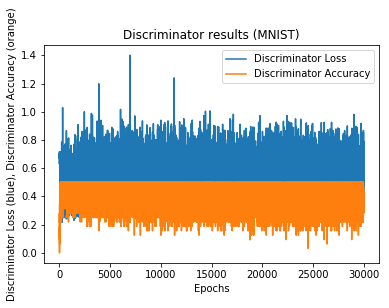

In [40]:
plt.plot(D_L)
plt.title('Discriminator results (MNIST)')
plt.xlabel('Epochs')
plt.ylabel('Discriminator Loss (blue), Discriminator Accuracy (orange)')
plt.legend(['Discriminator Loss', 'Discriminator Accuracy'])
plt.show()

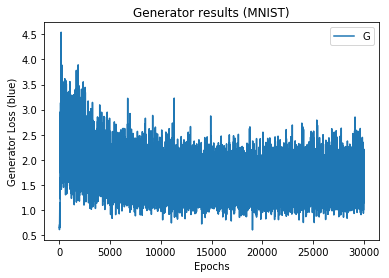

In [41]:
plt.plot(G_L)
plt.title('Generator results (MNIST)')
plt.xlabel('Epochs')
plt.ylabel('Generator Loss (blue)')
plt.legend('Generator Loss')
plt.show()

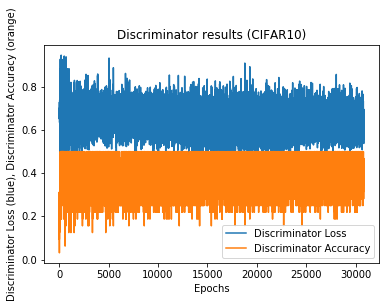

In [24]:
plt.plot(D_L)
plt.title('Discriminator results (CIFAR10)')
plt.xlabel('Epochs')
plt.ylabel('Discriminator Loss (blue), Discriminator Accuracy (orange)')
plt.legend(['Discriminator Loss', 'Discriminator Accuracy'])
plt.show()

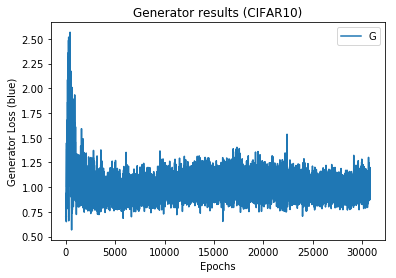

In [25]:
plt.plot(G_L)
plt.title('Generator results (CIFAR10)')
plt.xlabel('Epochs')
plt.ylabel('Generator Loss (blue)')
plt.legend('Generator Loss')
plt.show()